# This is a detailed analysis of the data taken on 20220613 and 2020614

In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py


In [2]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [3]:
fsamp=5000
res=50000
freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)    # change


In [4]:
def load_dir_reduced(dirname,file_prefix,max_files):
    '''
    Load time information from the h5 files in a loop into a list. Step size is fixed to 100. 
    '''   
    ## Load all filenames in directory
    var_list1 = []
    var_list2 = []
    var_list3 = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    print(len(files))
    step_size = 50
    for j in np.arange(0,max_files,step_size):
        for filename in files[j:j+step_size]:
            BDFs = BDF.BeadDataFile(dirname+filename)
            var_list1.append(BDFs.x2)
            var_list2.append(BDFs.cant_pos[1])
            var_list3.append(BDFs.y2)
    return var_list1,var_list2,var_list3

In [5]:
def data_to_amp_and_phase_single_axis(data,fsamp,res):
    data_det=signal.detrend(data)
    freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)    # change
    FFT=np.fft.rfft(data_det)
    norm = np.sqrt(2 / (res* fsamp))
    PSD = norm**2 * (FFT * FFT.conj()).real
    Phase =np.angle(FFT)
    return PSD,Phase

## verification of the methods comparability to previously used mlab.psd

# fsamp=5000
# res=50000
# data=f[0].x2
# a = data_to_amp_and_phase_single_axis(data,fsamp,res)
# b = matplotlib.mlab.psd(signal.detrend(data), Fs = fsamp, NFFT = res, window = mlab.window_none)
# plt.loglog(a[0],a[1])
# plt.loglog(b[1],b[0],alpha=0.5)

In [6]:
def loop_extract_PSD_and_phase(inList,fsamp,res,calibrationFactor=1):
    ampList = []
    phaseList=[]
    for i in range(len(inList)):
        data=inList[i]/calibrationFactor
        temp_ = data_to_amp_and_phase_single_axis(data,fsamp,res)
        ampList.append(temp_[0])
        phaseList.append(temp_[1])
    return ampList,phaseList

In [7]:
def extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True,calibrationFactorX=1,calibrationFactorY=1,fsamp=5000,res=50000):
    start=time.time()

    df= pd.DataFrame()
    fsamp=fsamp
    res=res
    freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)
    x2L,cPL,y2L = load_dir_reduced(folderName,file_prefix=filePrefix,max_files=maxFiles)
    xAmpList,xPhaseList = loop_extract_PSD_and_phase(x2L,fsamp,res,calibrationFactorX)
    yAmpList,yPhaseList = loop_extract_PSD_and_phase(y2L,fsamp,res,calibrationFactorY)
    
    df["cantPosY"] = cPL
    
    df["xAmp"] = x2L
    df["xPhase"] = xPhaseList
    df["xPSD"] = xAmpList
    #df["xASD"]=df["xPSD"].apply(lambda element: np.sqrt(element))
    
    df["yAmp"] = y2L
    df["yPhase"] = yPhaseList
    df["yPSD"] = yAmpList
    #df["yASD"]=df["yPSD"].apply(lambda element: np.sqrt(element))
    
    
    df["checkStd"]=df["xAmp"].apply(lambda element: np.std(element))
    

    if(filterStd==True):
        df=df[df["checkStd"]<20*df["checkStd"].median()]
    print("The process took %.2f" %(time.time()-start))
    print(df.info(memory_usage='deep'))

    return freqs,df

In [8]:
def plotQuickASD(fundamental,df_1,df_2,axis,label1,label2,offset,lowylim=1e-10,upylim=1e-4,lowxlim=10,upxlim=150,scaleFactor1=1,scaleFactor2=1,res=50000,fsamp=5000):

    xlabel="frequency [Hz]"
    ylabel="%s normalized ASD [m/$\sqrt{Hz}$]" %axis
    
        
    plt.plot(freqs,np.sqrt(df_1["%sPSD" %axis].sum()/scaleFactor1),color="black",alpha=1,lw=3,label=label1)
    plt.plot(freqs,np.sqrt(df_2["%sPSD" %axis].sum()/scaleFactor2),color="red",alpha=0.7,lw=3,label=label2)
    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.show()
    
    plt.plot(freqs[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],(np.sqrt(df_1["%sPSD" %axis].sum()/scaleFactor1))[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],color="black",alpha=1,lw=3,marker="*",ms=15,label=label1)
    plt.plot(freqs[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],(np.sqrt(df_2["%sPSD" %axis].sum()/scaleFactor2))[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],color="red",alpha=0.7,lw=3,marker="*",ms=15,label=label2)
    
    plt.plot(freqs[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],(np.sqrt(df_1["%sPSD" %axis].sum()/scaleFactor1))[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],color="blue",alpha=0.7,lw=3,ls="dashed",marker="*",ms=15,label=label1+" off-axis check at %d" %(fundamental+offset))
    plt.plot(freqs[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],(np.sqrt(df_2["%sPSD" %axis].sum()/scaleFactor2))[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],color="blue",alpha=0.7,lw=3,ls="dotted",marker="*",ms=15,label=label2+" off-axis check at %d"%(fundamental+offset))

    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [9]:
def plotQuickAlternatemethod(fundamental,df_1,df_2,label1,label2,offset,lowylim=1e-10,upylim=1e-4,lowxlim=10,upxlim=150,scaleFactor1=1,scaleFactor2=1,res=50000,fsamp=5000):

    data1=data_to_amp_and_phase_single_axis(df_1["xAmp"].sum(),5000,50000)[0]
    data2=data_to_amp_and_phase_single_axis(df_2["xAmp"].sum(),5000,50000)[0]            
    xlabel="frequency [Hz]"
    ylabel="%s sumPSD [a.u.]"
    plt.plot(freqs,data1/scaleFactor1,color="black",alpha=1,lw=3,label=label1)
    plt.plot(freqs,data2/scaleFactor2,color="red",alpha=0.5,lw=3,label=label2)
    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

    plt.plot(freqs[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],(data1/scaleFactor1)[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],color="black",alpha=1,lw=3,marker="*",ms=15,label=label1)
    plt.plot(freqs[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],(data2/scaleFactor2)[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],color="red",alpha=0.7,lw=3,marker="*",ms=15,label=label2)

    plt.plot(freqs[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],(data1/scaleFactor1)[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],color="blue",alpha=0.7,lw=3,ls="dashed",marker="*",ms=15,label=label1+" off-axis check at %d" %(fundamental+offset))
    plt.plot(freqs[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],(data2/scaleFactor2)[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],color="blue",alpha=0.7,lw=3,ls="dotted",marker="*",ms=15,label=label2+" off-axis check at %d"%(fundamental+offset))

    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()                       

## Calibration

In [10]:
# settings to the ASM003 from Gautam - settings are the same as for me
fExc = 13.1415
excAmp = 50e-3/2 * 15 #mV, the factor of 15 gets us to the actual voltage applied to the ASM003 piezos.
# Calibration numbers from elog 337
xCal, yCal = 7.83e-6, 5.54e-6 # urad/V
excAmpX, excAmpY = xCal*excAmp*1.27000000e-02, yCal*excAmp*1.27000000e-02 # m, last factor is to convert to motion at trap focus

In [27]:
folderName="/data/new_trap/20220613/ASMcal/Xexc/" 
filePrefix="ASMcal"
files = load_dir(folderName,file_prefix=filePrefix)
calibrationFactorX = np.mean([np.abs(digital_demod(files[i].x2,13.1415))/excAmpX for i in range(10)])
print(calibrationFactorX)
#freqs,df_NoShaking0= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
#df_NoShaking0.to_pickle("Results/NoShaking_0_20220613.npy")

100%|██████████| 10/10 [00:00<00:00, 206.47it/s]

10  files in folder
10  files loaded
19306.988944004694


In [30]:
folderName="/data/new_trap/20220607/ASMcal/Xexc/" 
filePrefix="ASMcal"
files = load_dir(folderName,file_prefix=filePrefix)
calibrationFactorX = np.mean([np.abs(digital_demod(files[i].x2,13.1415))/excAmpX for i in range(10)])
print(calibrationFactorX)
#freqs,df_NoShaking0= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
#df_NoShaking0.to_pickle("Results/NoShaking_0_20220613.npy")

100%|██████████| 10/10 [00:00<00:00, 213.68it/s]

10  files in folder
10  files loaded
11708.376218350246


In [31]:
folderName="/data/new_trap/20220526/ASMcal/Xexc/" 
filePrefix="ASMcal"
files = load_dir(folderName,file_prefix=filePrefix)
calibrationFactorX = np.mean([np.abs(digital_demod(files[i].x2,13.1415))/excAmpX for i in range(10)])
print(calibrationFactorX)
#freqs,df_NoShaking0= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
#df_NoShaking0.to_pickle("Results/NoShaking_0_20220613.npy")

100%|██████████| 10/10 [00:00<00:00, 40.64it/s]

10  files in folder
10  files loaded
61769.96258597658


In [22]:
folderName="/data/new_trap/20220613/ASMcal/Yexc/" 
filePrefix="ASMcal"
files = load_dir(folderName,file_prefix=filePrefix)
calibrationFactorY = np.mean([np.abs(digital_demod(files[i].y2,13.1415))/excAmpY for i in range(10)])
print(calibrationFactorY )

100%|██████████| 10/10 [00:00<00:00, 196.78it/s]

10  files in folder
10  files loaded
314581.46851090284


100%|██████████| 10/10 [00:00<00:00, 212.90it/s]

10  files in folder
10  files loaded
22132.531247148938


In [ ]:
folderName="/data/new_trap/20220613/ASMcal/Yexc/" 
filePrefix="ASMcal"
files = load_dir(folderName,file_prefix=filePrefix)
calibrationFactorY = np.mean([np.abs(digital_demod(files[i].y2,13.1415))/excAmpY for i in range(10)])
print(calibrationFactorY )

In [37]:
# folderName="/data/new_trap/20220613/NoShaking/0/" 
# filePrefix="NoShaking"
# freqs,df_NoShaking0= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
# df_NoShaking0.to_pickle("Results/NoShaking_0_20220613.npy")

# folderName="/data/new_trap/20220613/Shaking/1/" 
# filePrefix="Shaking"
# freqs,df_Shaking13= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
# df_Shaking13.to_pickle("Results/Shaking_1_20220613.npy")

# folderName="/data/new_trap/20220613/Shaking/2/" 
# filePrefix="Shaking"
# freqs,df_Shaking3= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
# df_Shaking3.to_pickle("Results/Shaking_2_20220613.npy")



1000
The process took 51.39
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
cantPosY    1000 non-null object
xAmp        1000 non-null object
xPhase      1000 non-null object
xPSD        1000 non-null object
yAmp        1000 non-null object
yPhase      1000 non-null object
yPSD        1000 non-null object
checkStd    1000 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.5 GB
None


In [97]:
#load the data
df_NoShaking0 = pd.read_pickle("Results/NoShaking_0_20220613.npy")
df_Shaking13 = pd.read_pickle("Results/Shaking_1_20220613.npy")
df_Shaking3 = pd.read_pickle("Results/Shaking_2_20220613.npy")


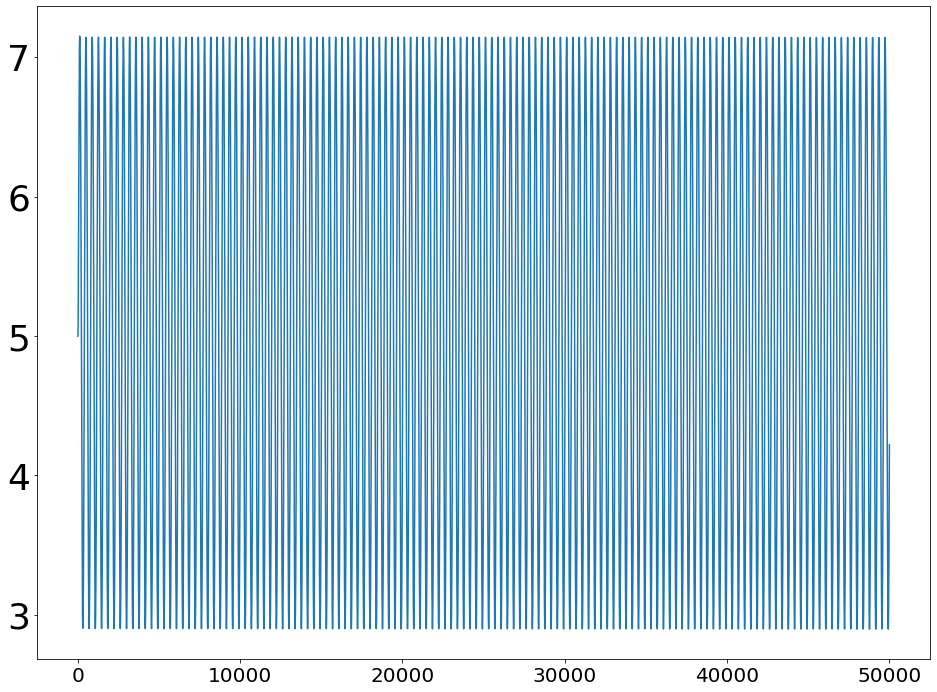

In [98]:
plt.plot(df_Shaking13.cantPosY[0])

In [81]:
def extract_correlation(df,calibrationFactorY,fDrive):
    maxC=[]
    argC=[]
    inPhaseC =[]
    for i in range(len(df)):
        c = 0
        c = correlation(df.cantPosY[i],df.yAmp[i]/calibrationFactorY,fsamp,fDrive)
        maxC.append(np.max(c))
        argC.append(np.argmax(c))
        inPhaseC.append(c[0])
    return maxC,argC,inPhaseC

In [82]:
c1,c2,c3=extract_correlation(df=df_Shaking13,calibrationFactorY=3.5e5,fDrive=13)

In [83]:
nc1,nc2,nc3=extract_correkation(df=df_NoShaking0,calibrationFactorY=3.5e5,fDrive=13)

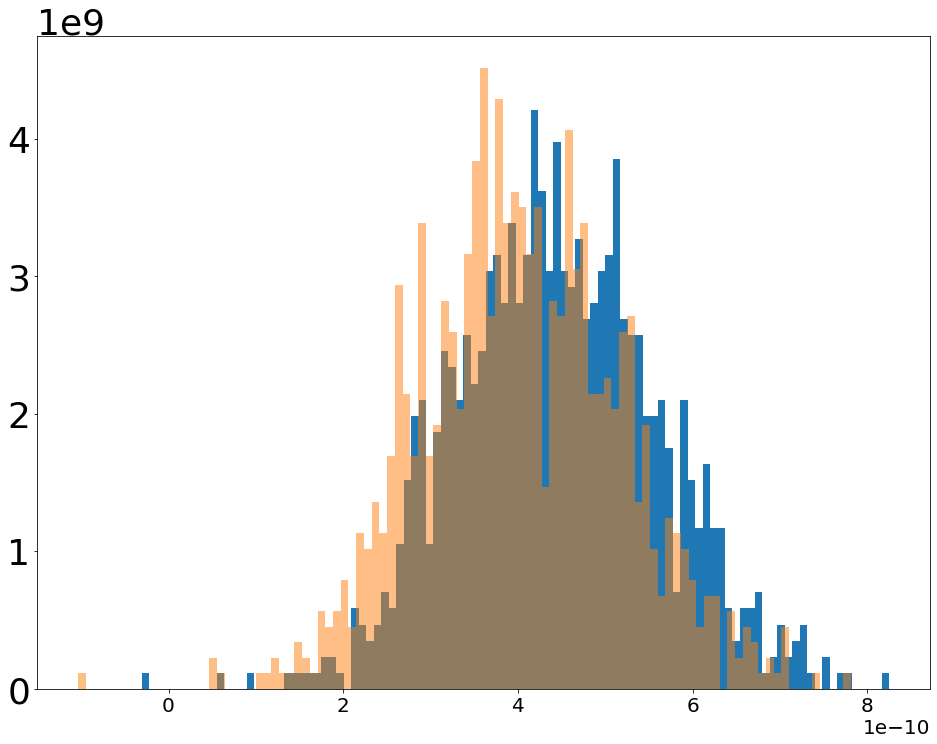

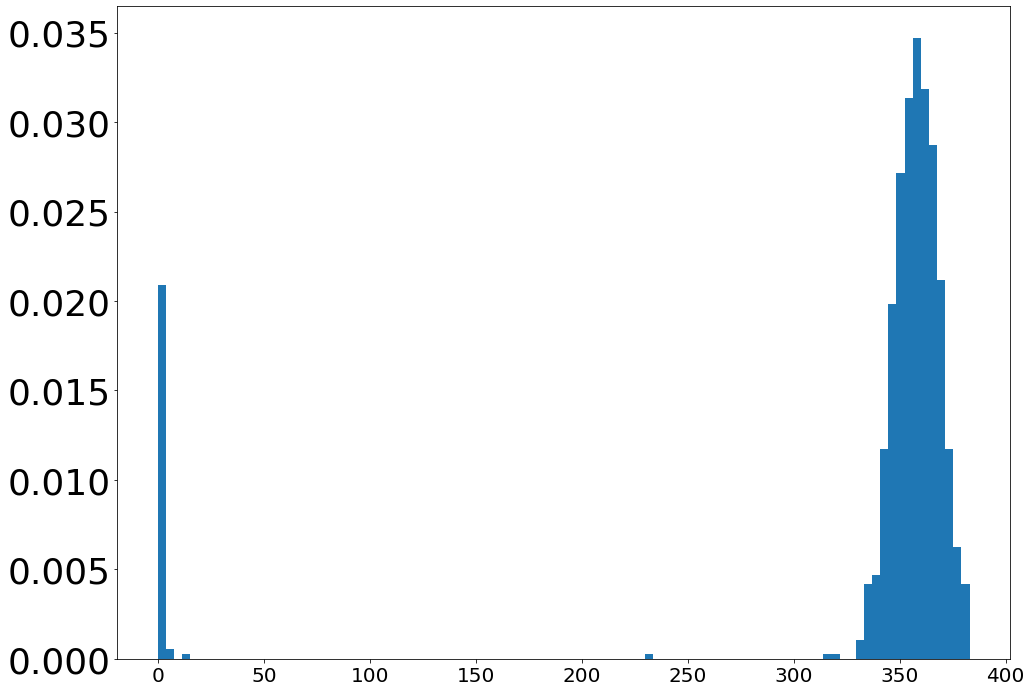

In [84]:
plt.hist(c1,density=True,bins=100)
plt.hist(c3,density=True,alpha=0.5,bins=100)
plt.show()
plt.hist(c2,density=True,bins=100)
plt.show()

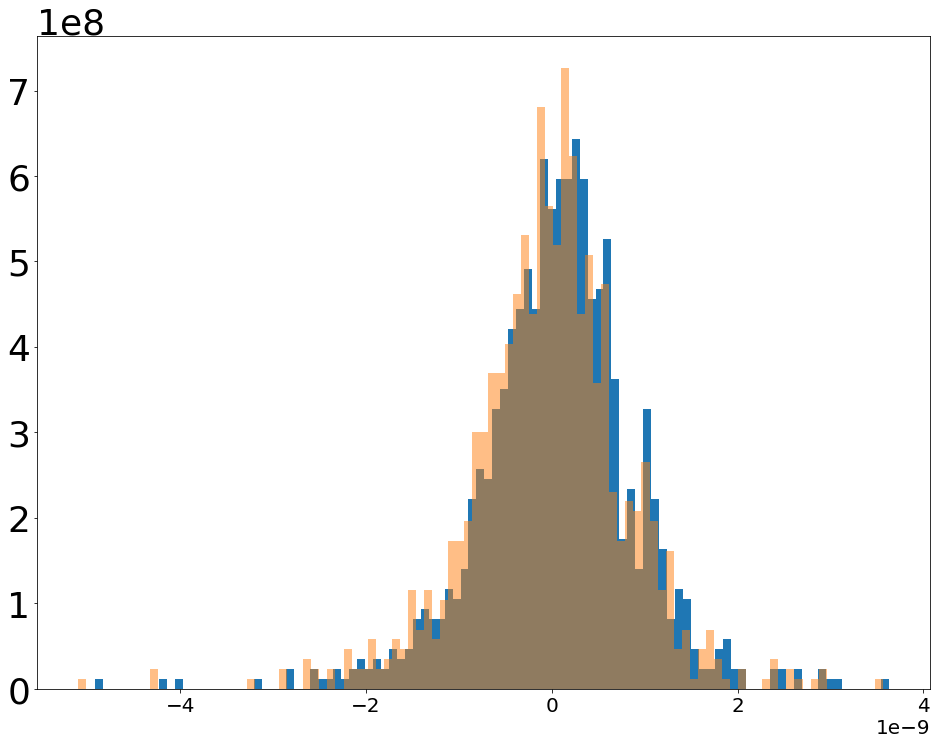

(array([0.00835509, 0.00887728, 0.00469974, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00234987, 0.00339426,
        0.00078329, 0.        , 0.0002611 , 0.        , 0.00365535,
        0.02872063, 0.03342037, 0.00208877, 0.0002611 , 0.        ,
        0.00052219, 0.00104439, 0.0002611 , 0.00208877, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0002611 ,
        0.00052219, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00182768, 0.01958225, 0.01383812, 0.00078329,
        0.        , 0.        , 0.0002611 , 0.00156658, 0.00104439,
        0.00417755, 0.0002611 , 0.        , 0.        , 0.        ,
        0.        , 0.0002611 , 0.00130548, 0.        , 0.        ,
        0.        , 0.        , 0.00052219, 0.00130548, 0.01070496,
        0.00469974, 0.        , 0.        , 0.        , 0.00052219,
        0.0002611 , 0.        , 0.00156658, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00

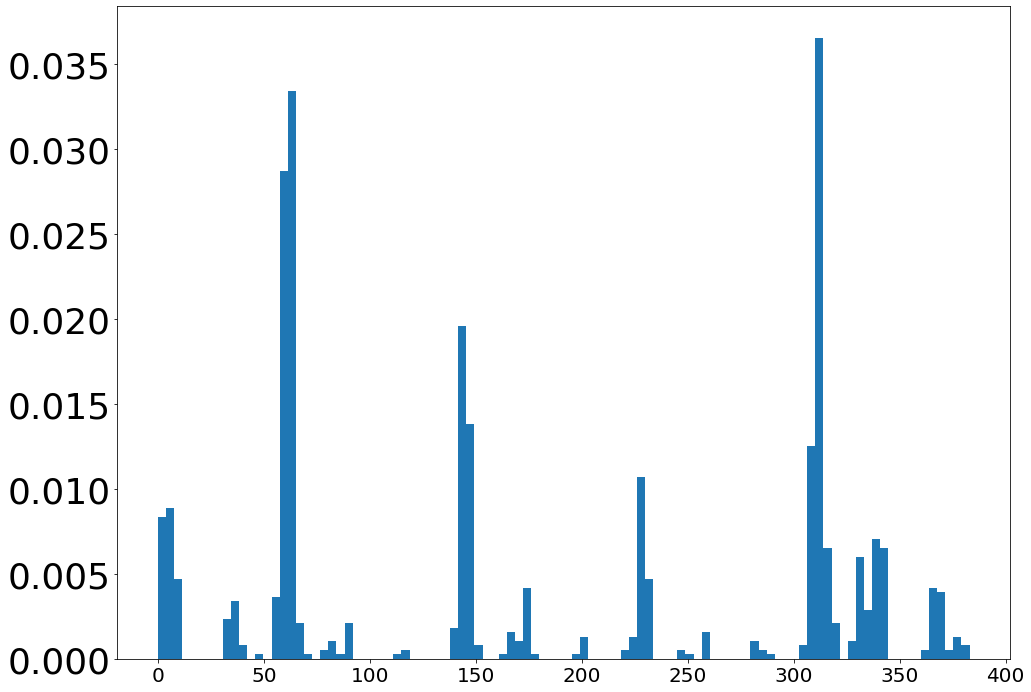

In [85]:
plt.hist(nc1,density=True,bins=100)
plt.hist(nc3,density=True,alpha=0.5,bins=100)
plt.show()
plt.hist(nc2,density=True,bins=100)

In [49]:
#plt.plot(inPhaseC)
#plt.plot(maxC)


## Let's look at phases

In [99]:
# transform the drive into phases
def add_driveFFT_for_harmonics(df,frequency):
    df["driveFFT"] = df["cantPosY"].apply(lambda element: data_to_amp_and_phase_single_axis(element,fsamp,res)[1][frequency*int(res/fsamp)::frequency*int(res/fsamp)])
    return df

In [100]:
df_Shaking13=add_driveFFT_for_harmonics(df_Shaking13,13)
#df_Shaking3=add_driveFFT_for_harmonics(df_Shaking3,3)

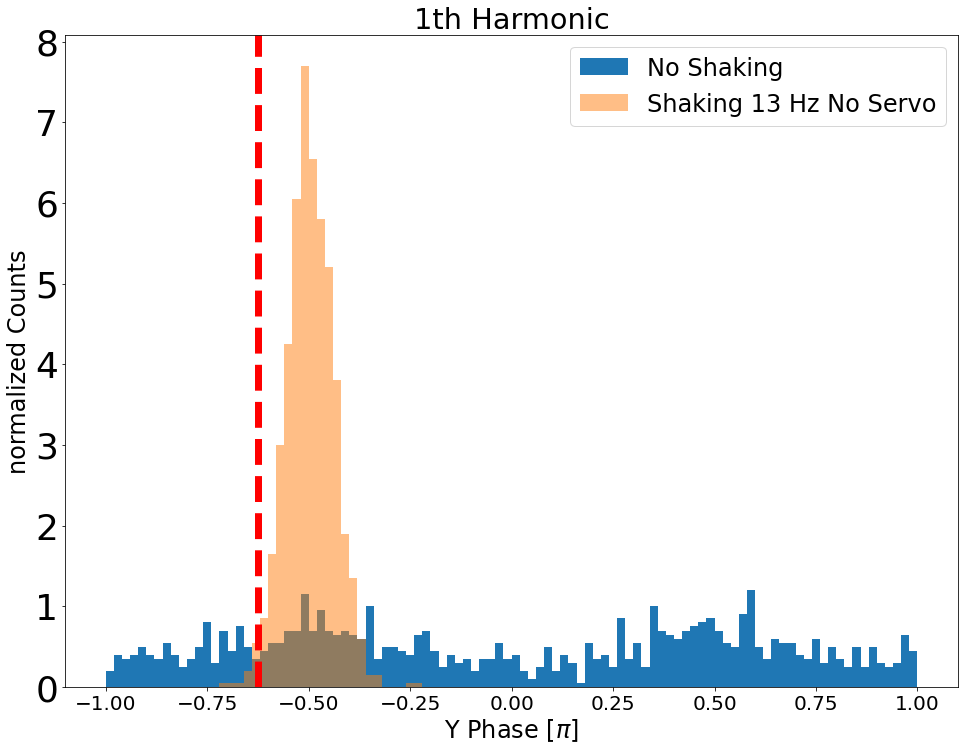

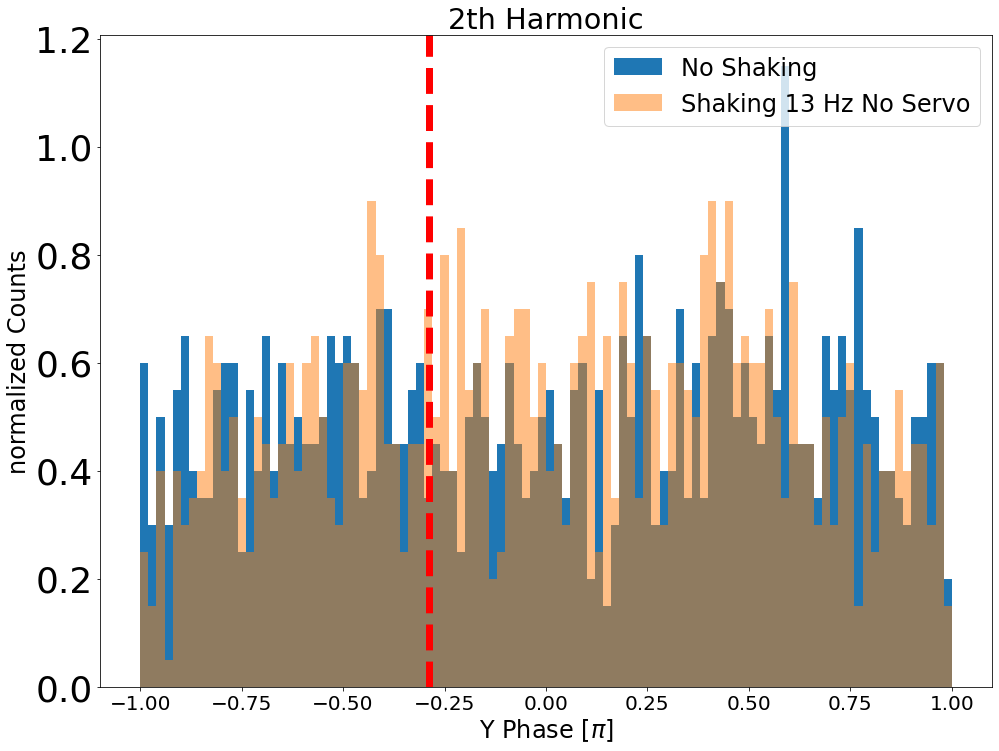

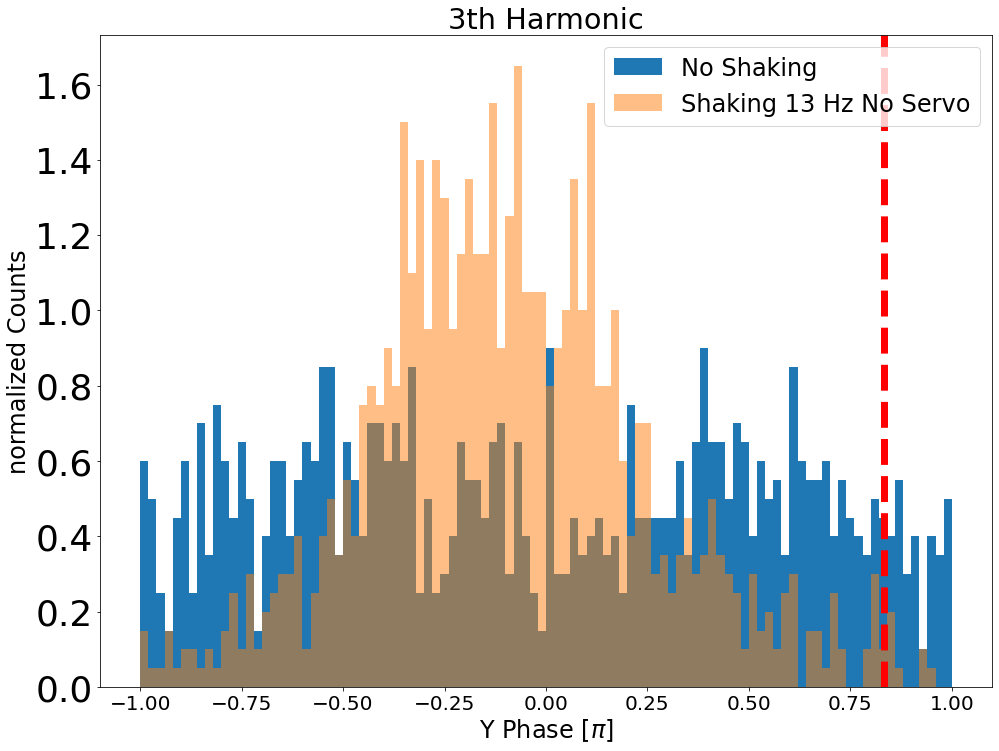

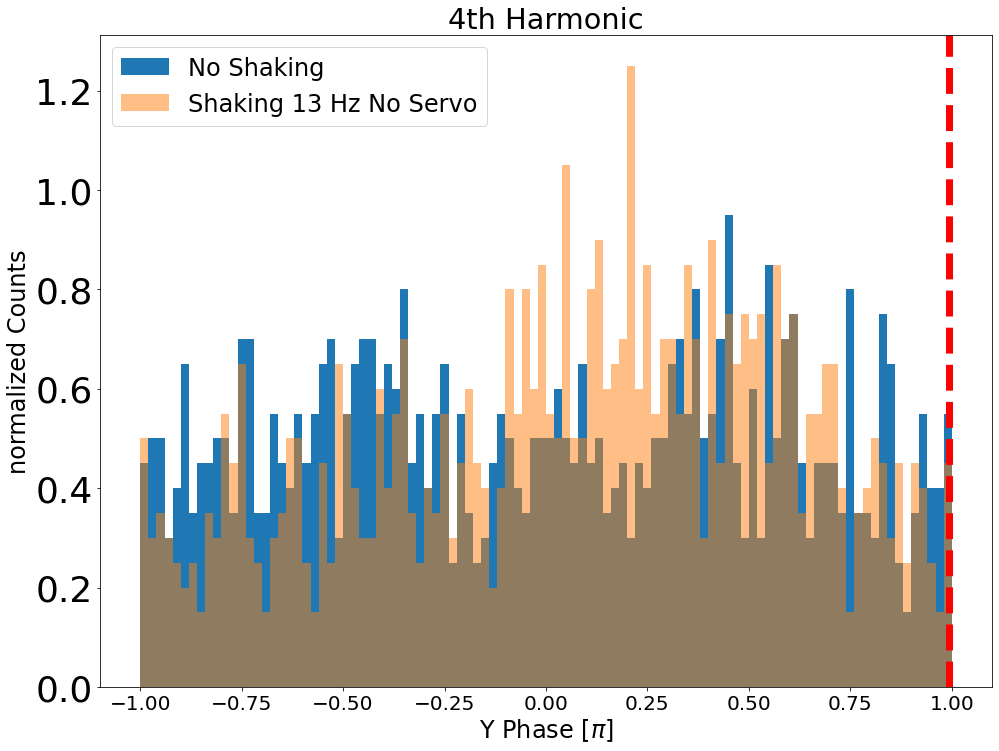

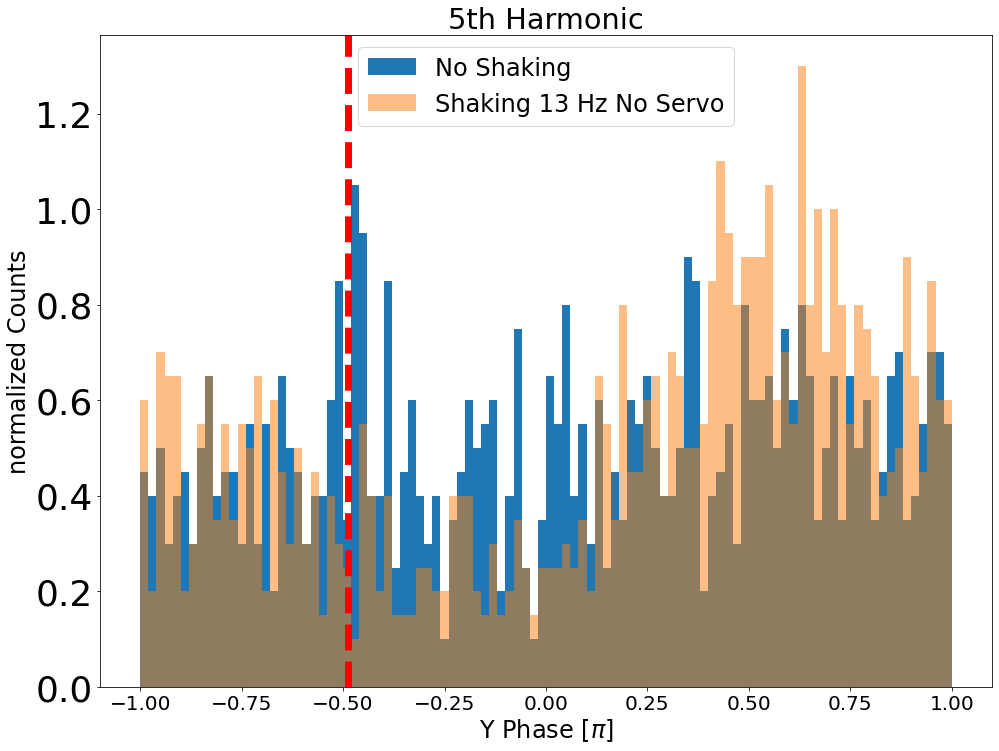

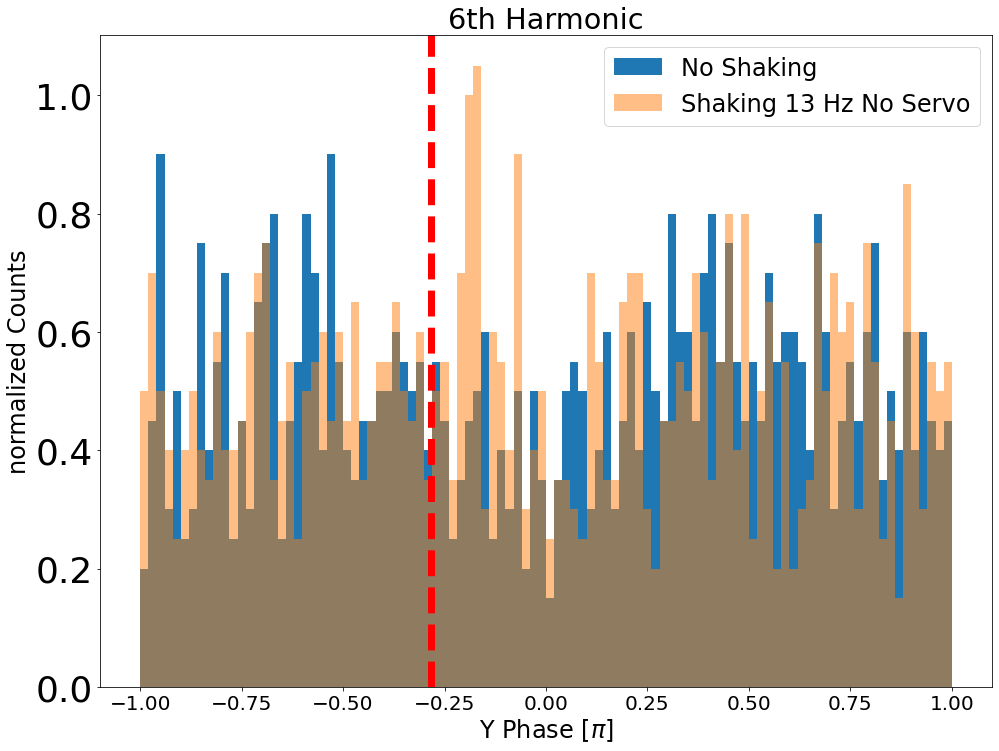

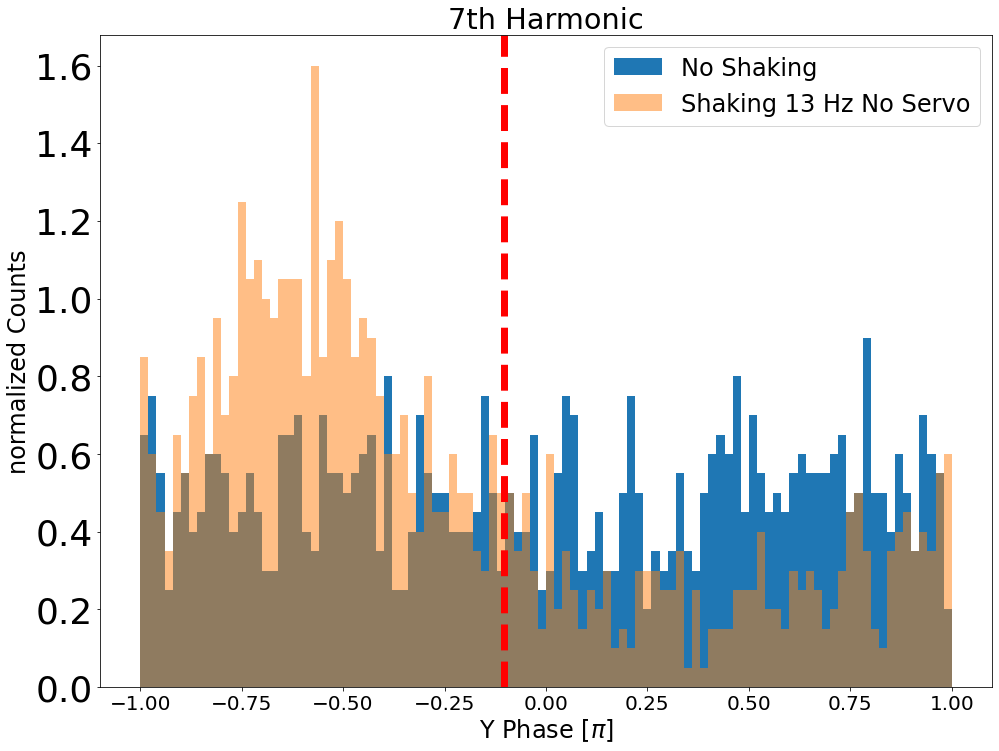

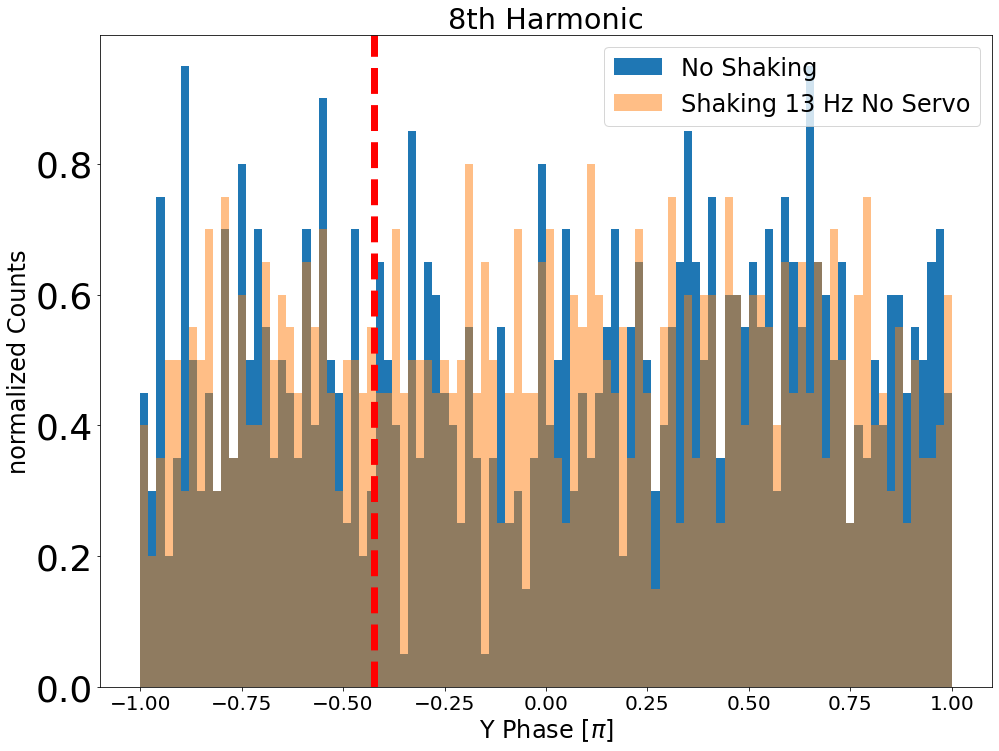

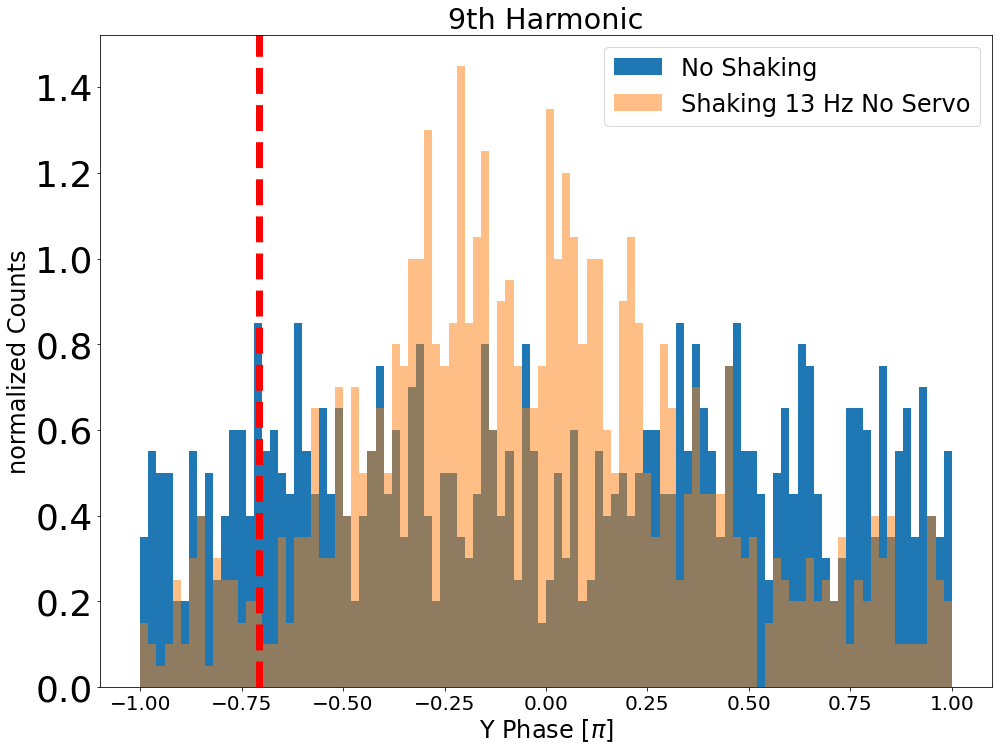

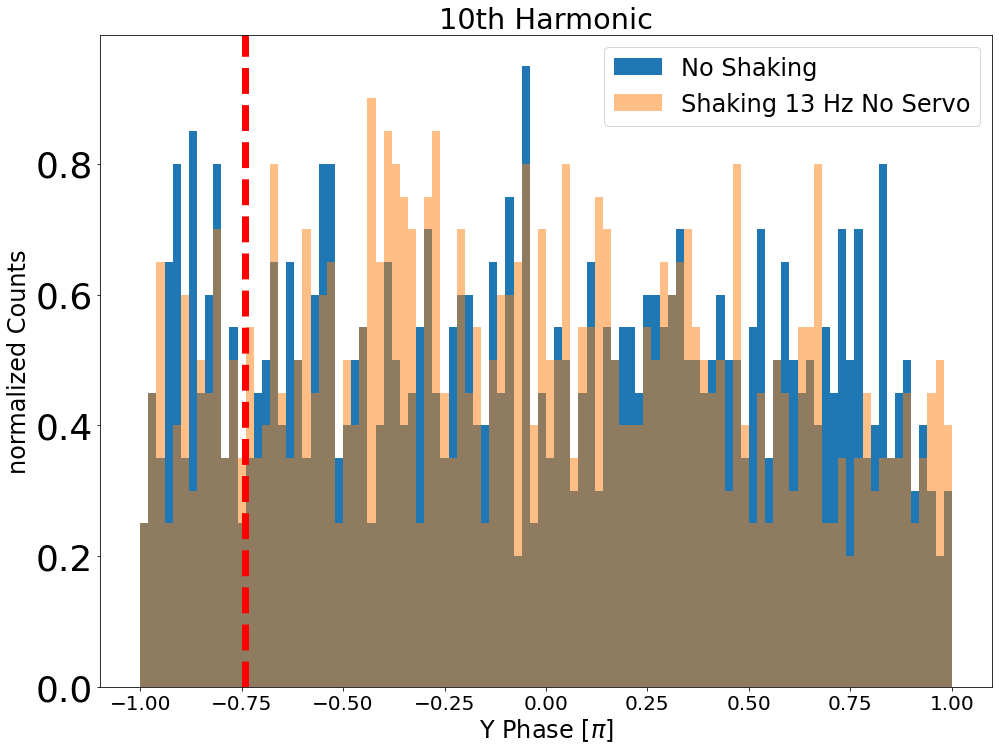

In [101]:
frequency=13
df0=df_NoShaking0
df1=df_Shaking13

for j in range(10):
    PhaseListY0 = []
    PhaseListY1 = []
    for i in range(len(df0)):
        PhaseListY0.append(df0["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListY1.append(df1["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("Y Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListY0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListY1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    plt.axvline(df1["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

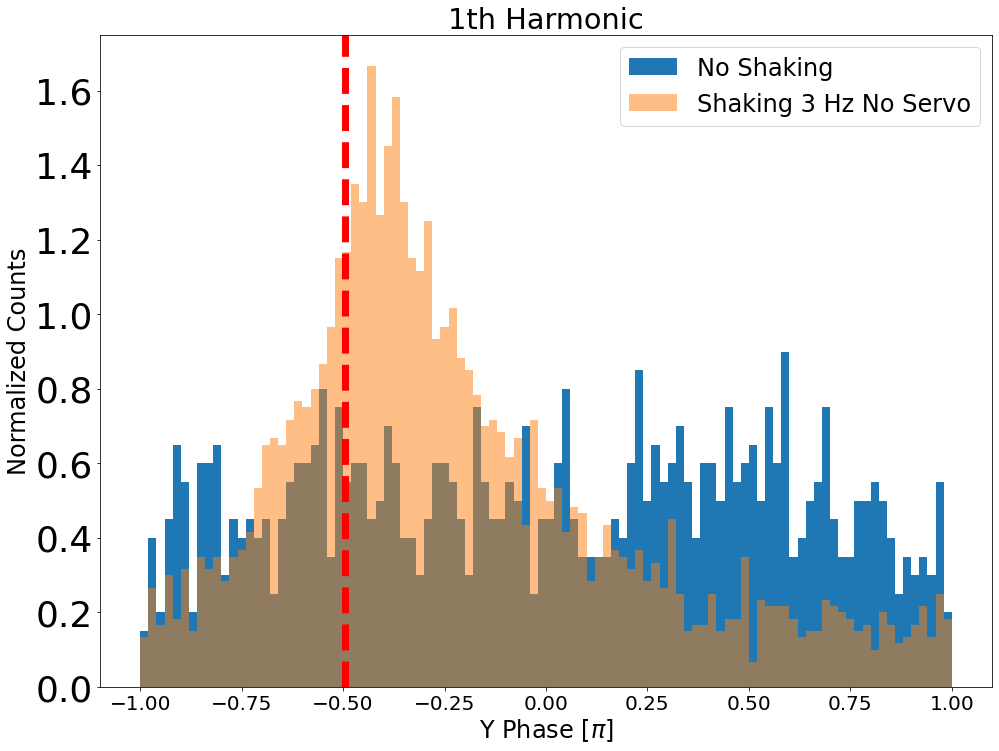

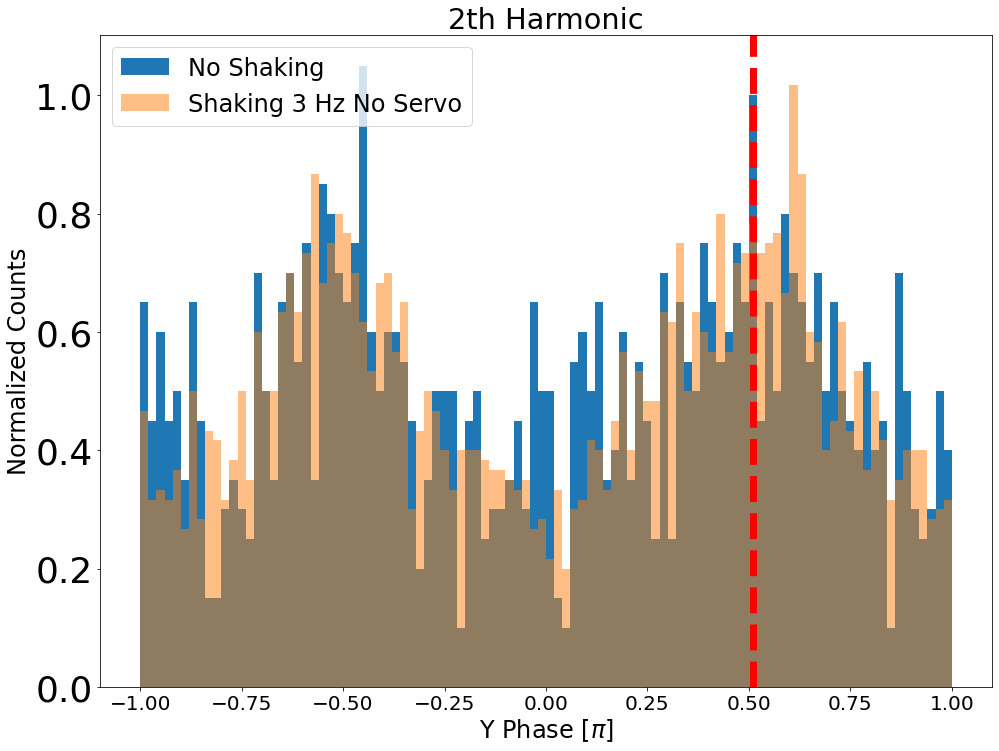

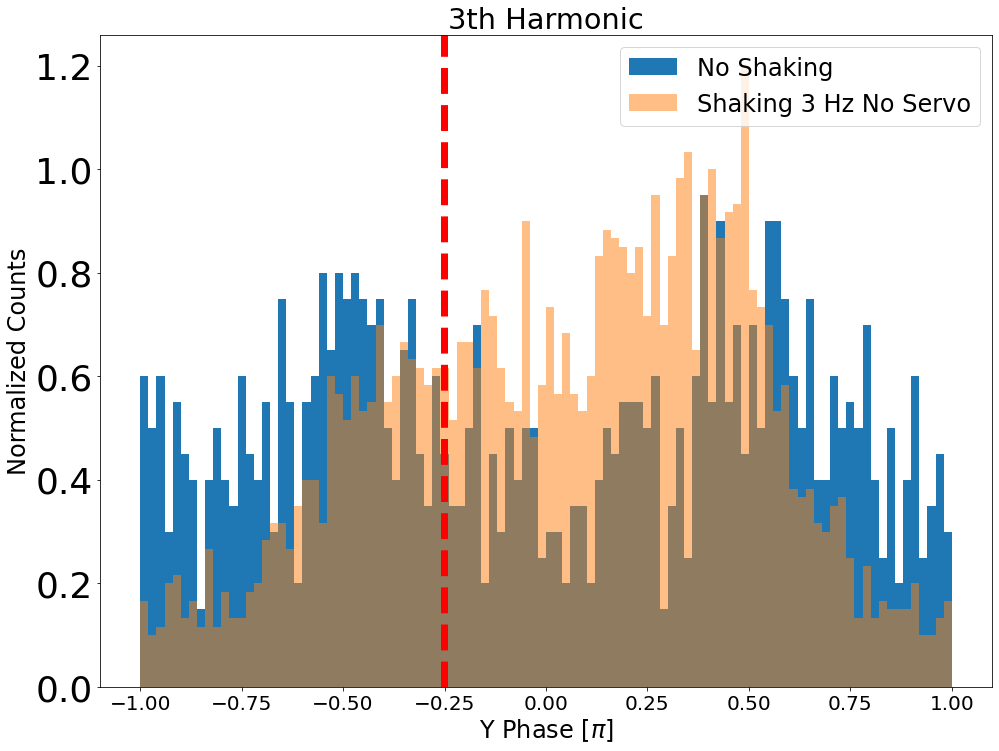

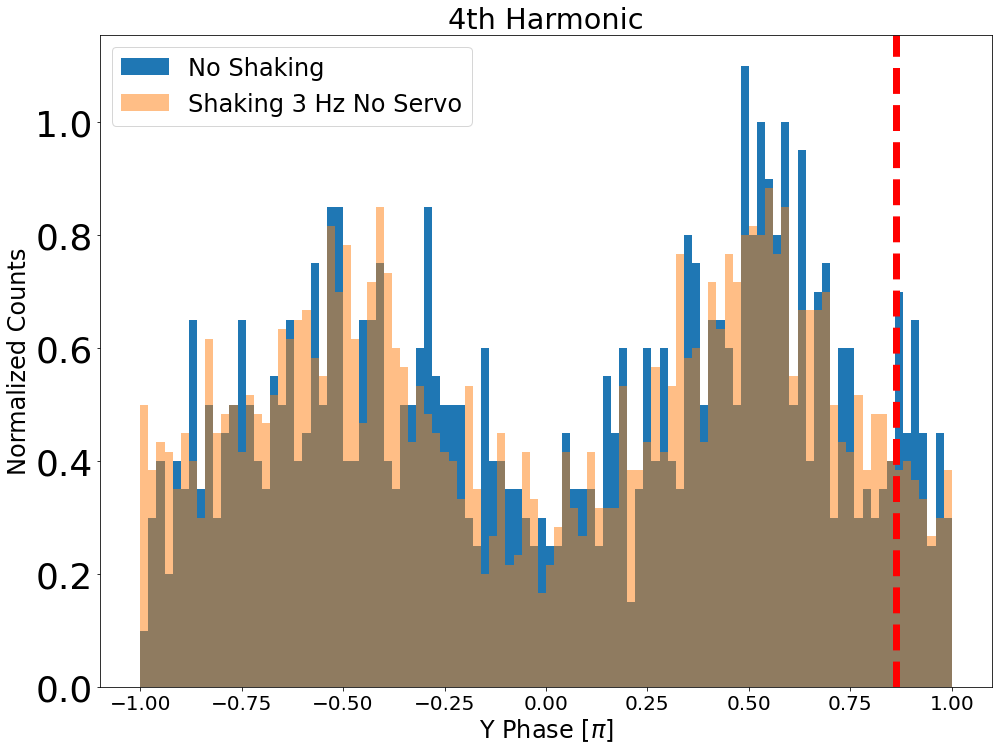

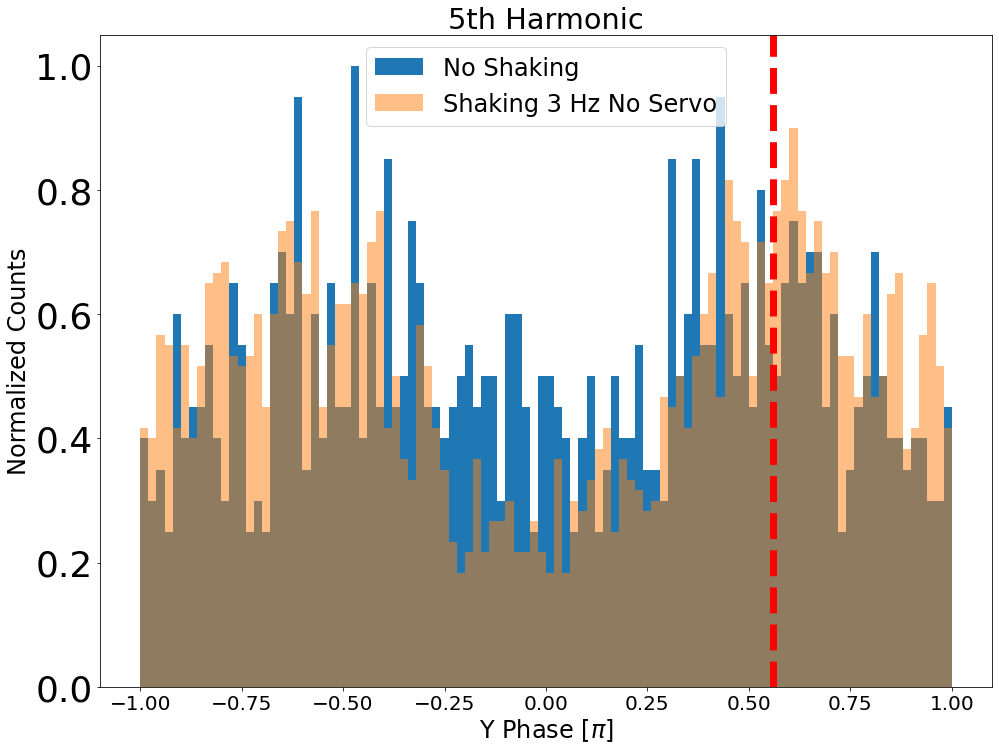

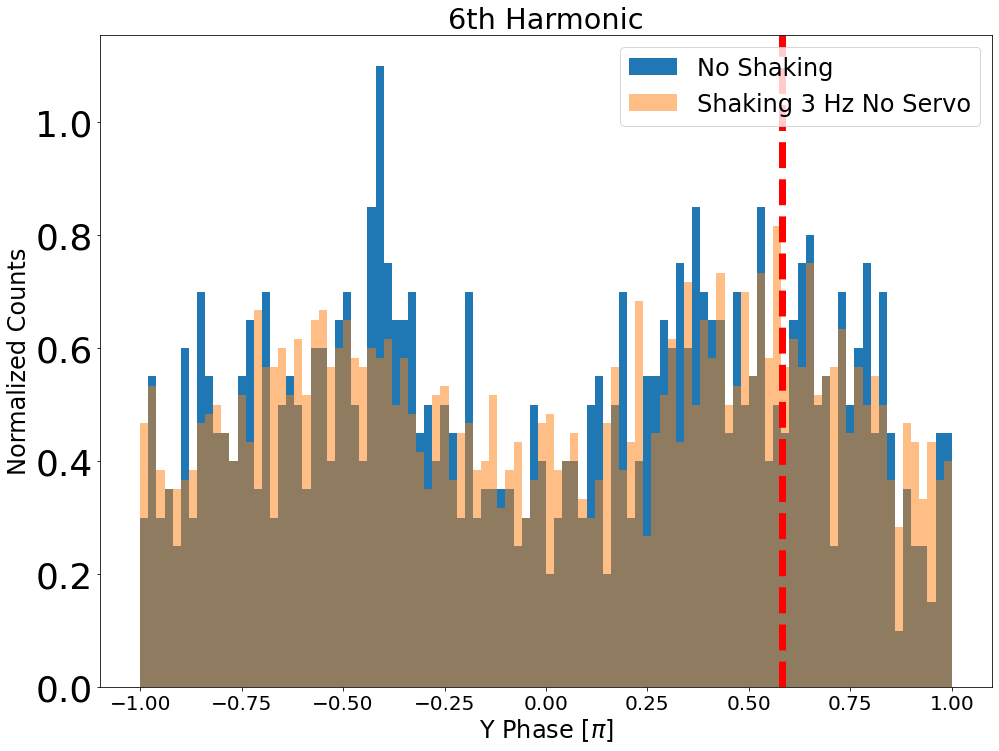

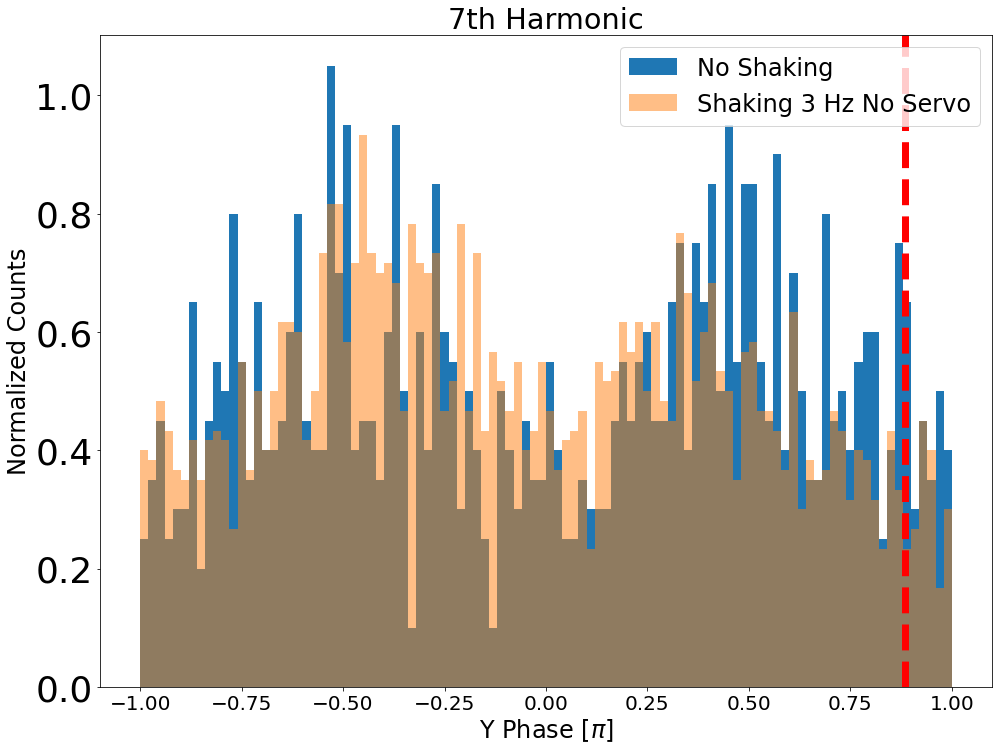

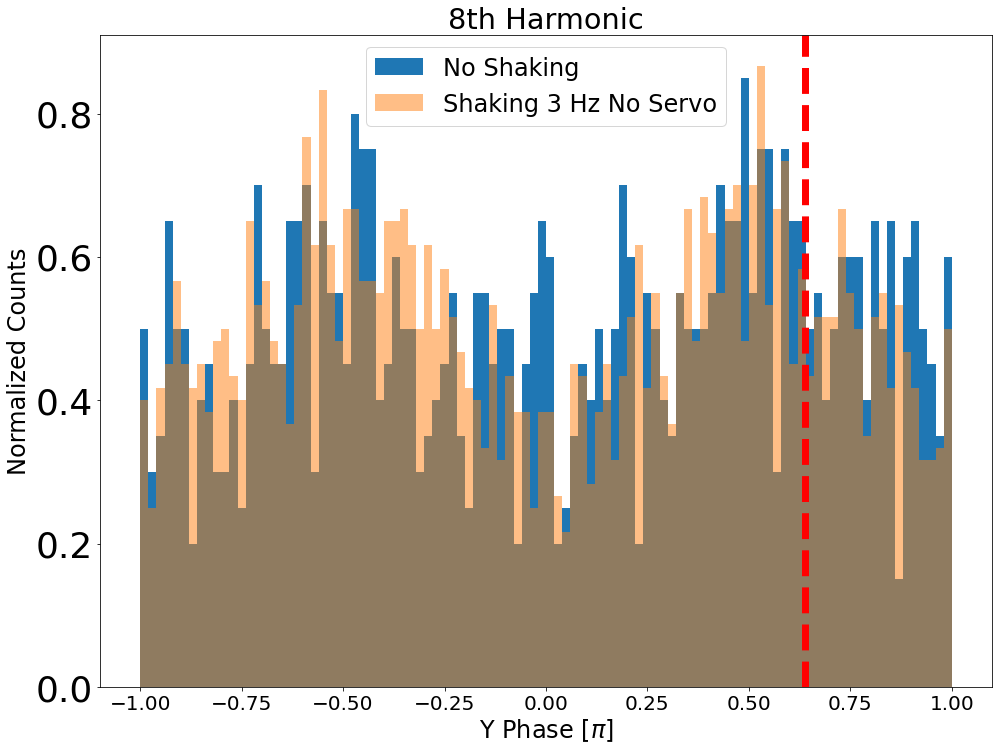

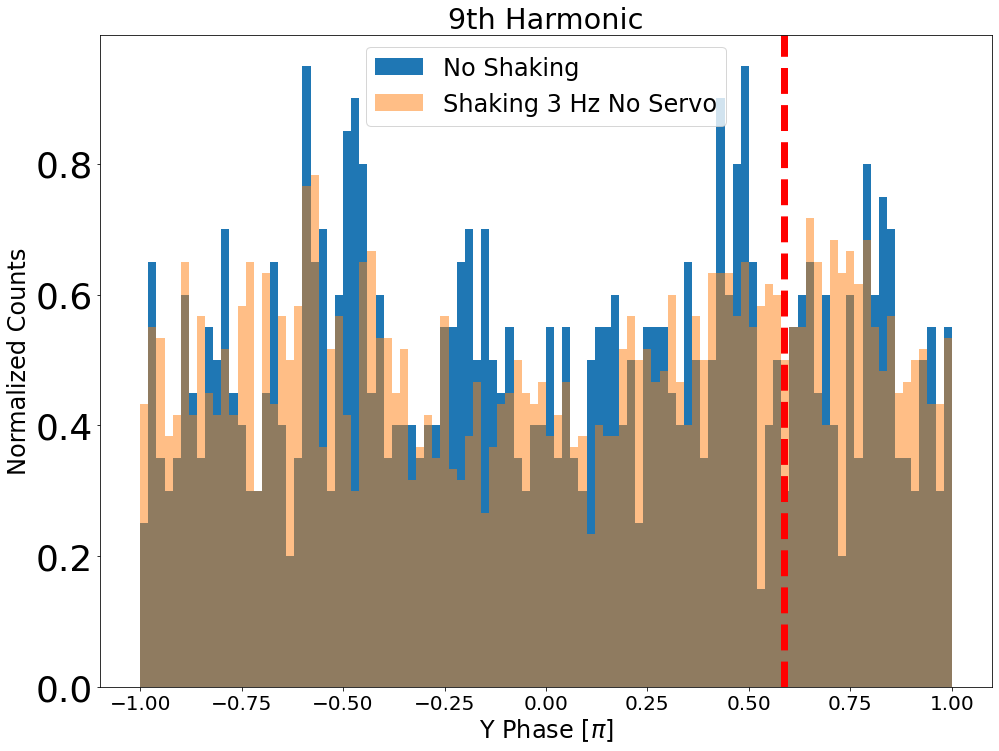

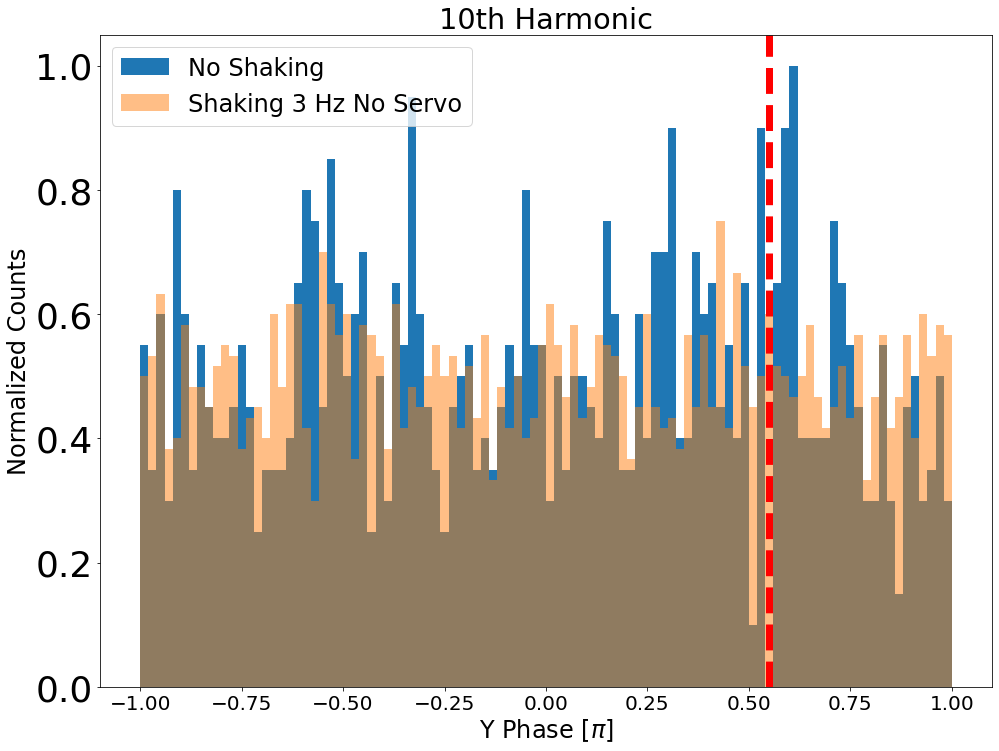

In [91]:
frequency=3
df0=df_NoShaking0
df1=df_Shaking3

for j in range(10):
    PhaseListY0 = []
    PhaseListY1 = []
    for i in range(len(df0)):
        PhaseListY0.append(df0["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListY1.append(df1["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("Y Phase [$\pi$]")
    plt.ylabel("Normalized Counts")
    plt.hist(PhaseListY0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListY1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    plt.axvline(df1["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

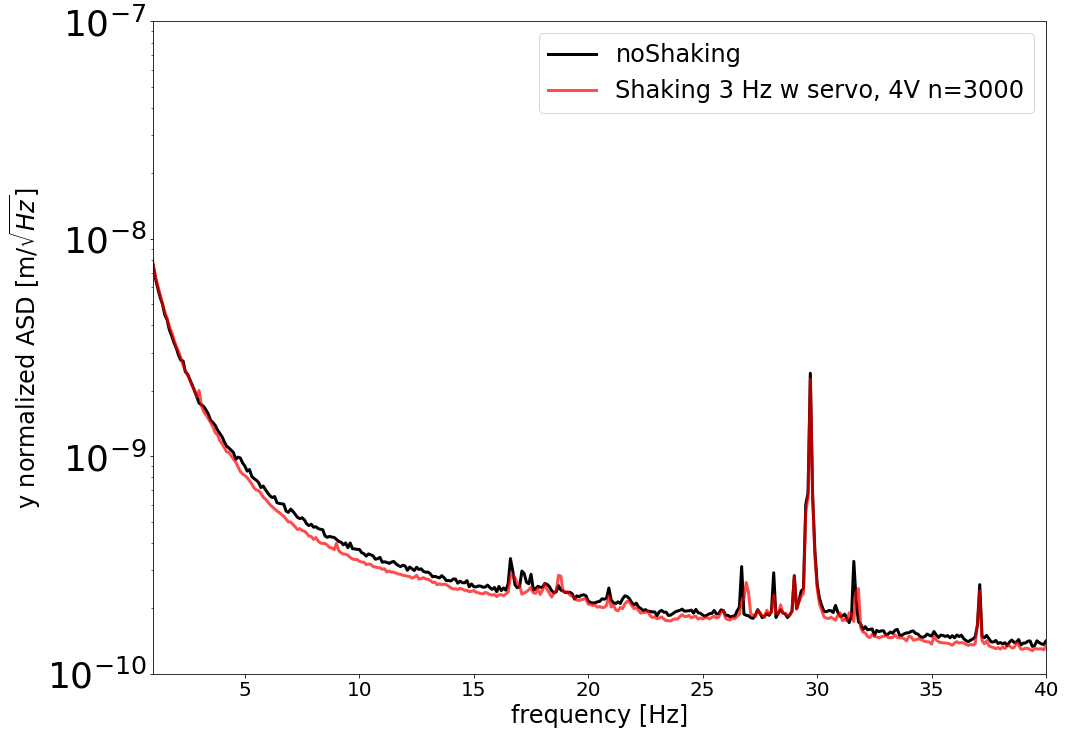

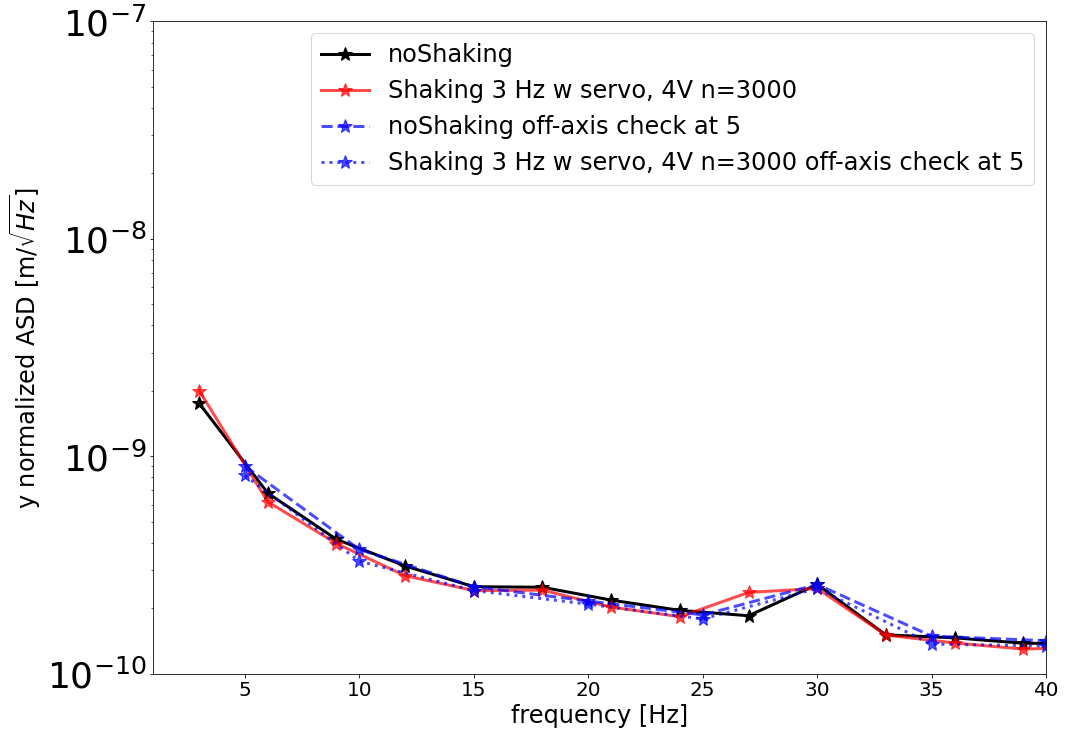

In [81]:
data1=df_NoShaking0
data2=df_Shaking3
plotQuickASD(3,df_1=data1,df_2=data2,axis="y",label1="noShaking",label2="Shaking 3 Hz w servo, 4V n=%d" %(len(data2)),offset=2,lowylim=1e-10,upylim=1e-7,lowxlim=1,upxlim=40,scaleFactor1=len(data1),scaleFactor2=len(data2))

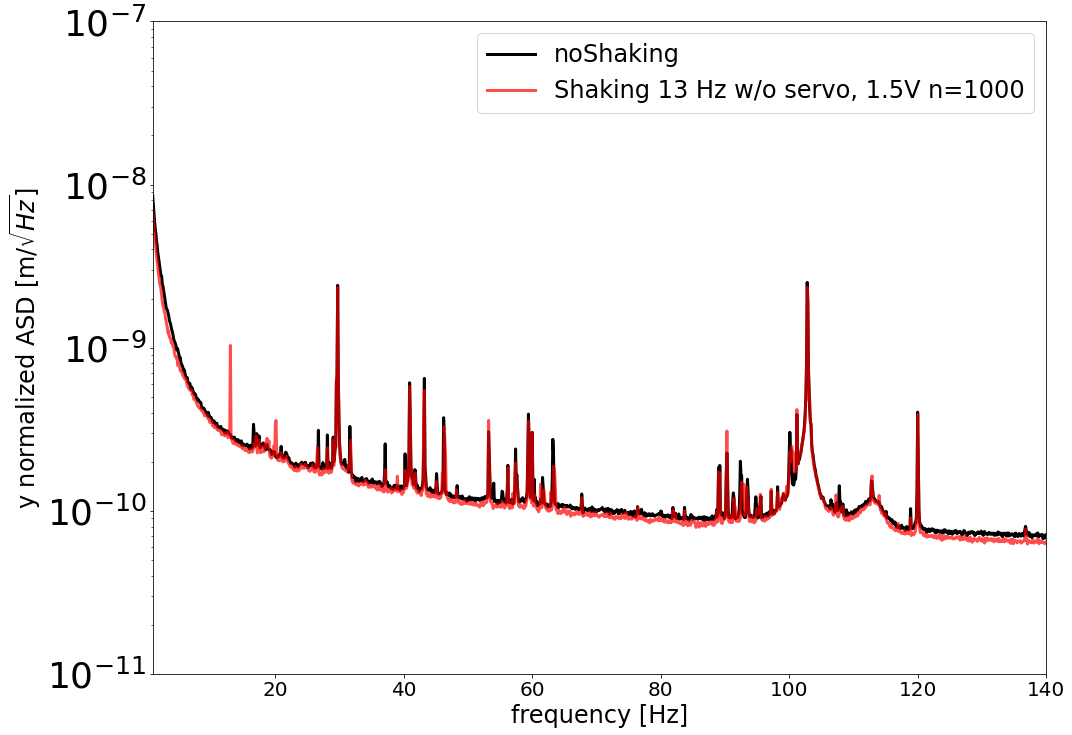

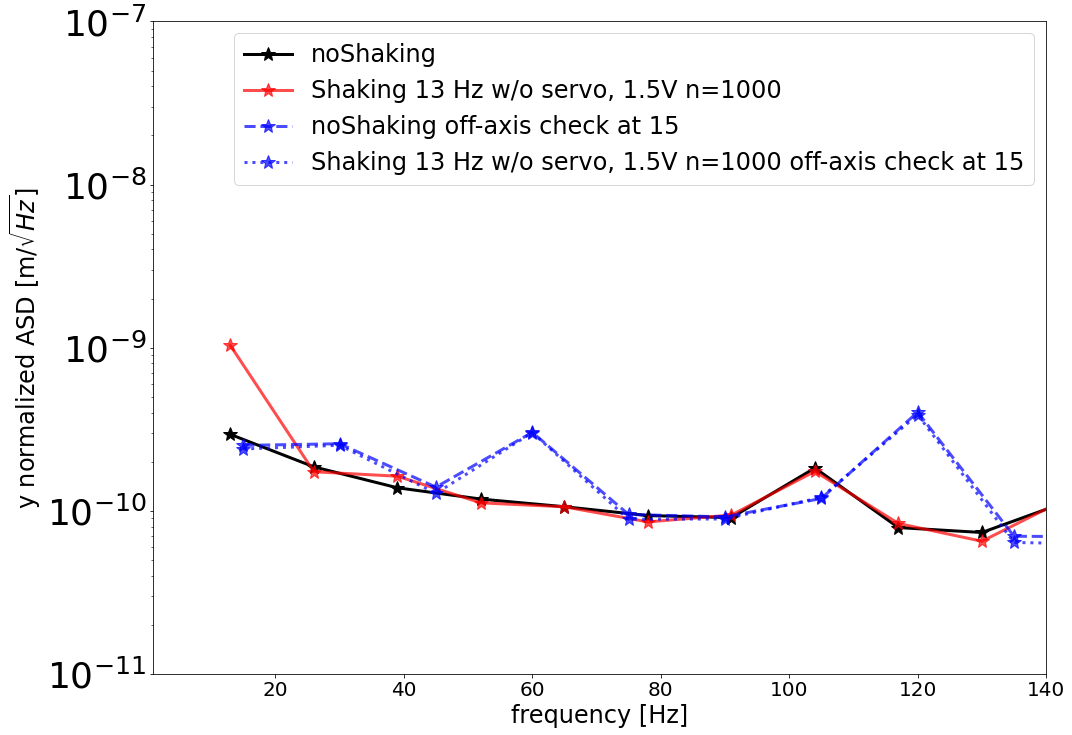

In [84]:
data1=df_NoShaking0
data2=df_Shaking13
plotQuickASD(13,df_1=data1,df_2=data2,axis="y",label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=1e-11,upylim=1e-7,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

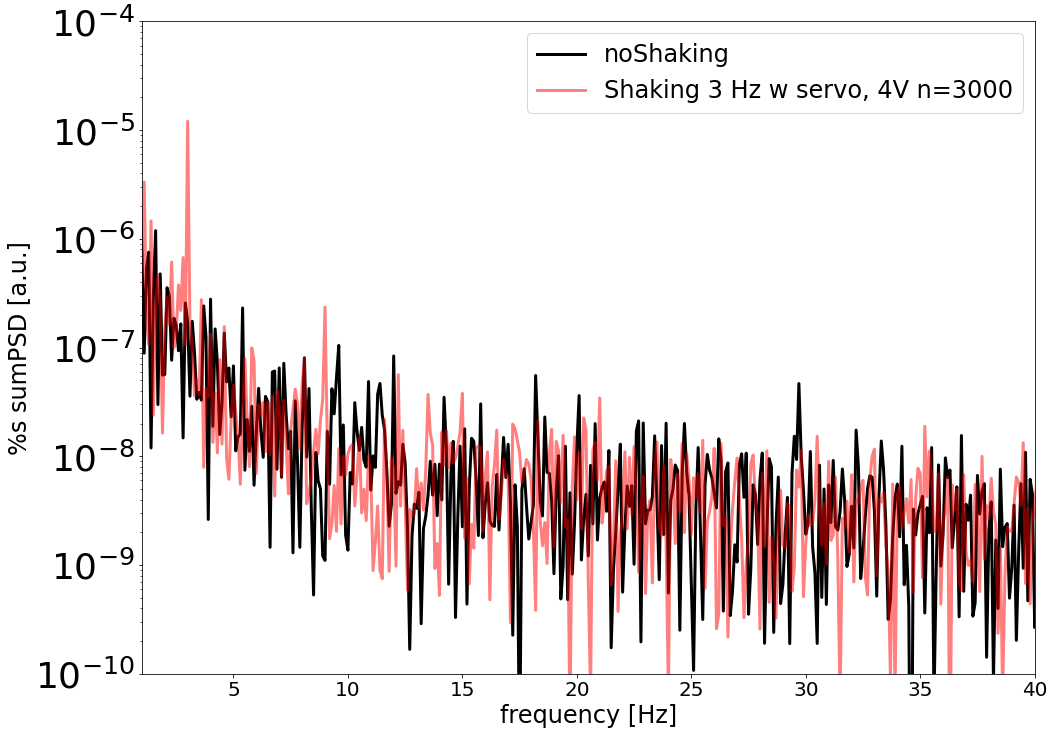

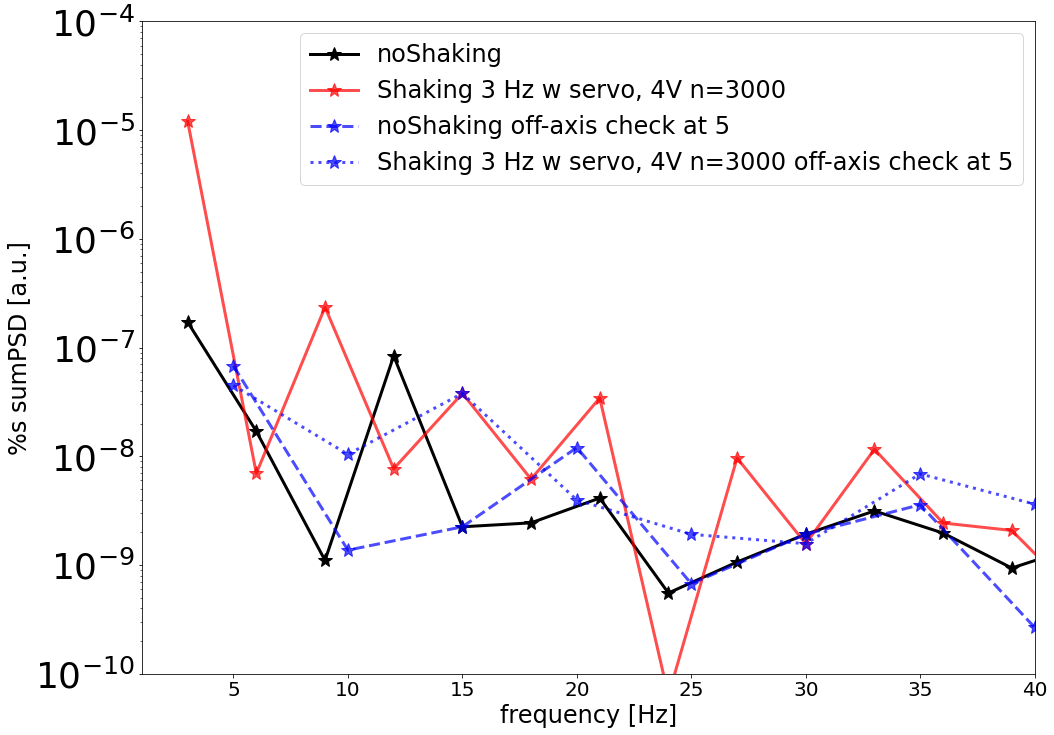

In [86]:
data1=df_NoShaking0
data2=df_Shaking3
plotQuickAlternatemethod(3,df_1=data1,df_2=data2,label1="noShaking",label2="Shaking 3 Hz w servo, 4V n=%d" %(len(data2)),offset=2,lowylim=1e-10,upylim=1e-4,lowxlim=1,upxlim=40,scaleFactor1=len(data1),scaleFactor2=len(data2))

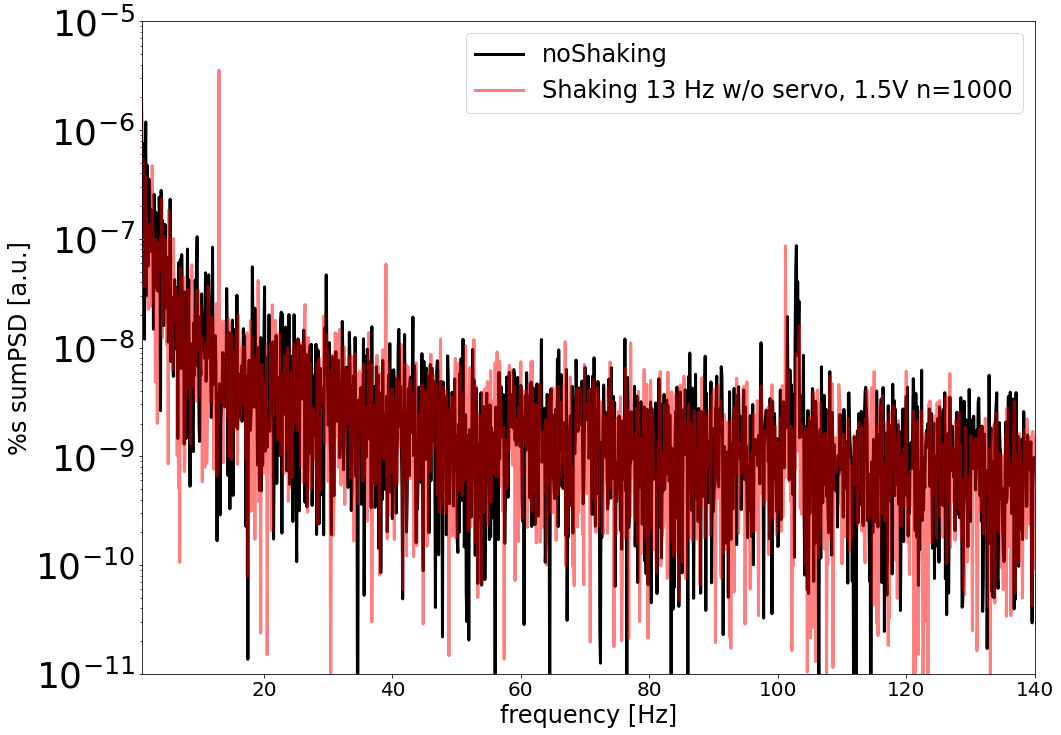

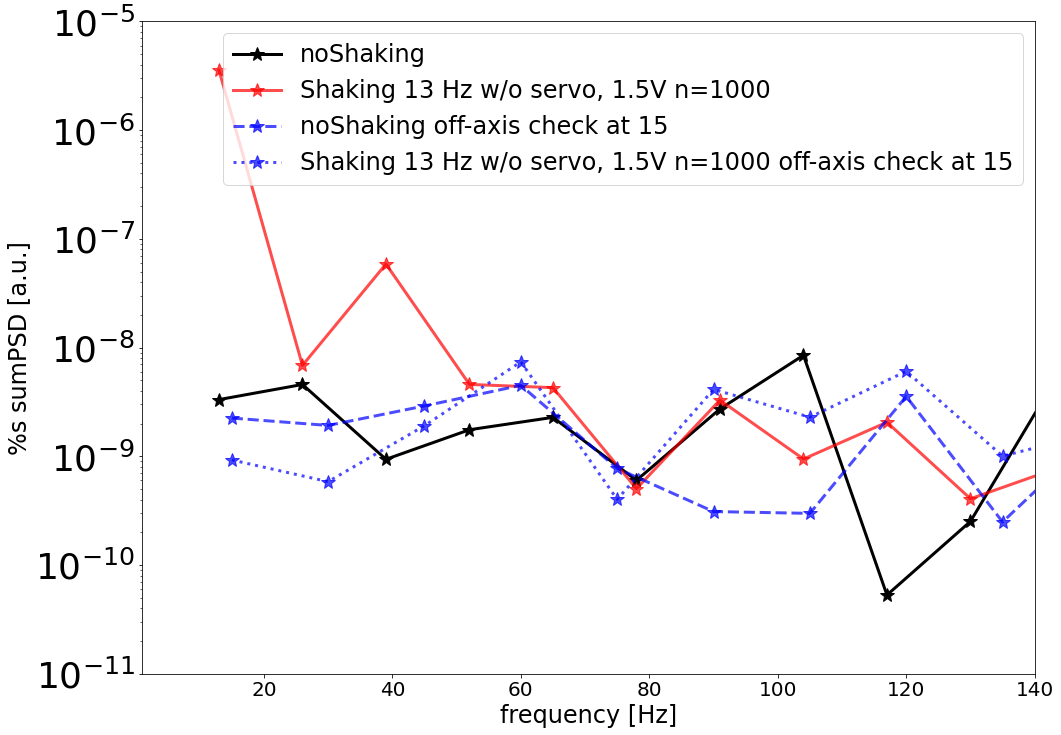

In [89]:
data1=df_NoShaking0
data2=df_Shaking13
plotQuickAlternatemethod(13,df_1=data1,df_2=data2,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=1e-11,upylim=1e-5,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

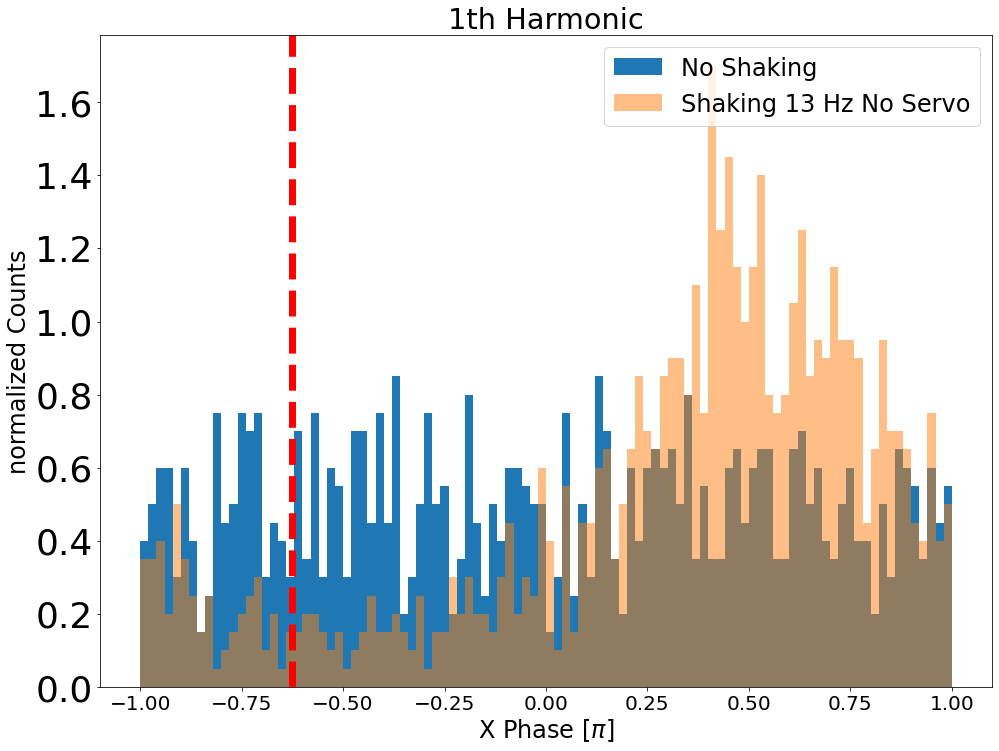

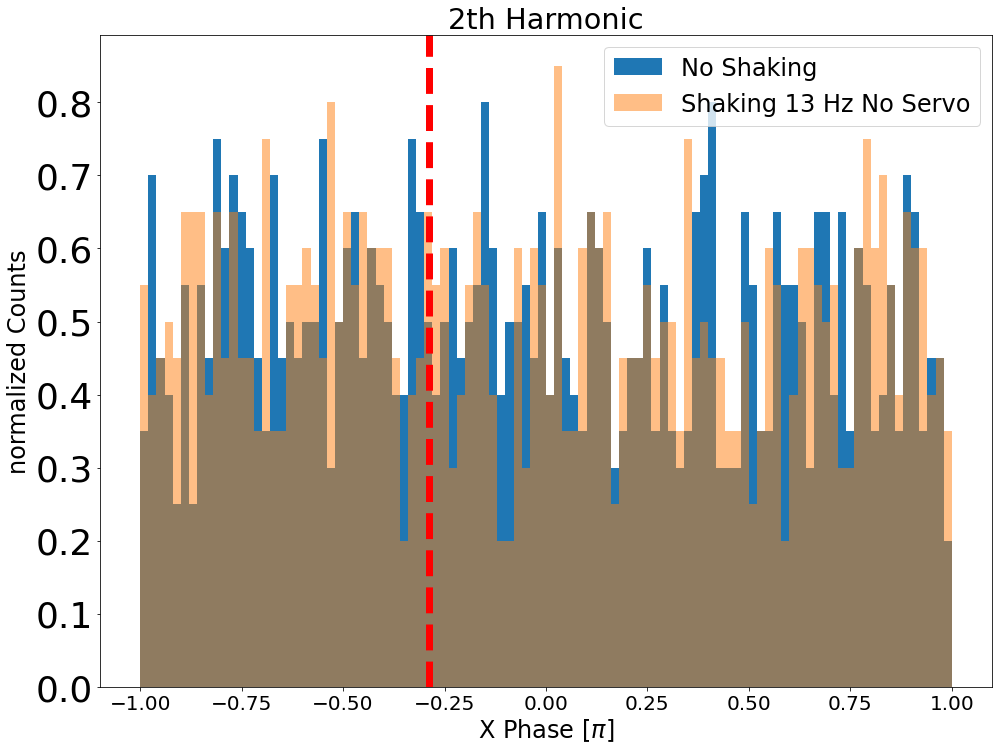

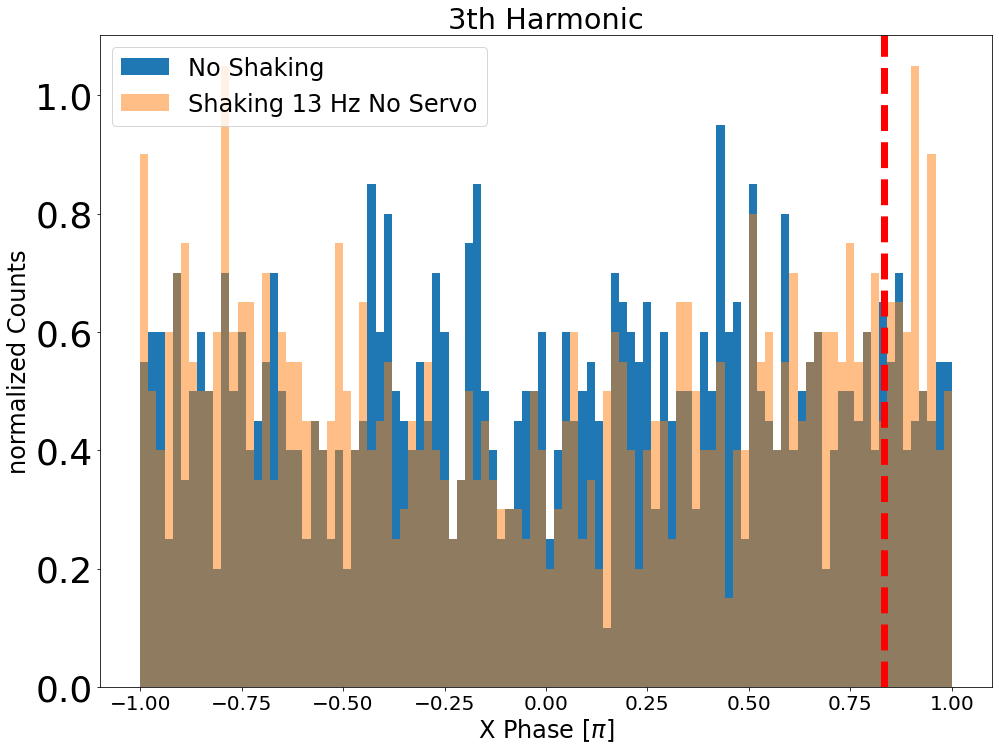

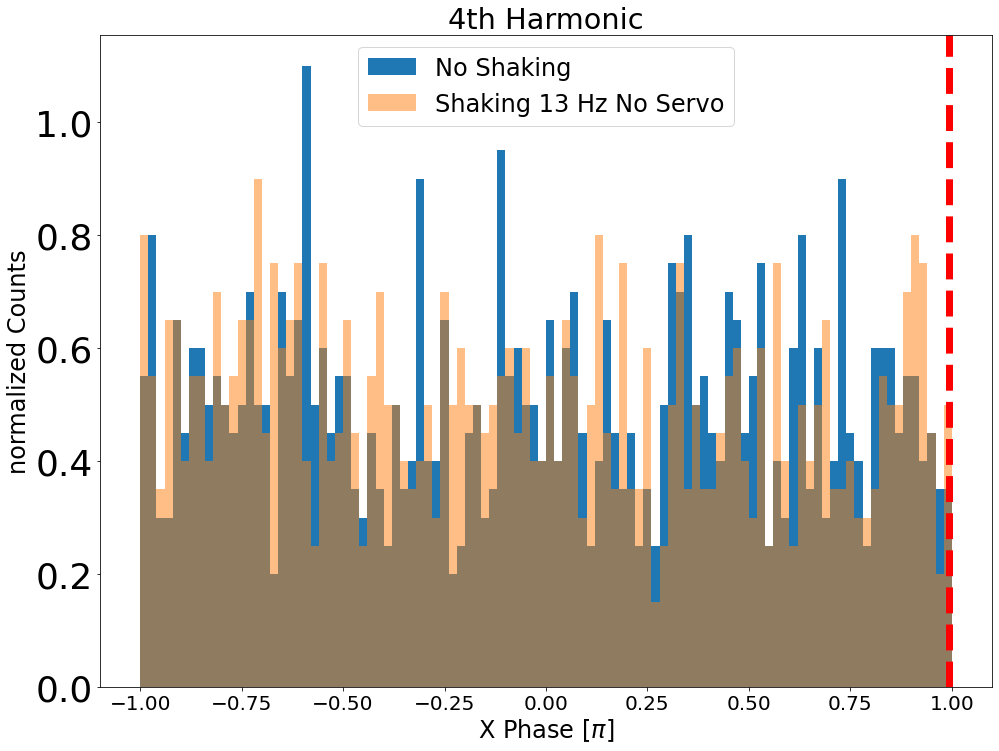

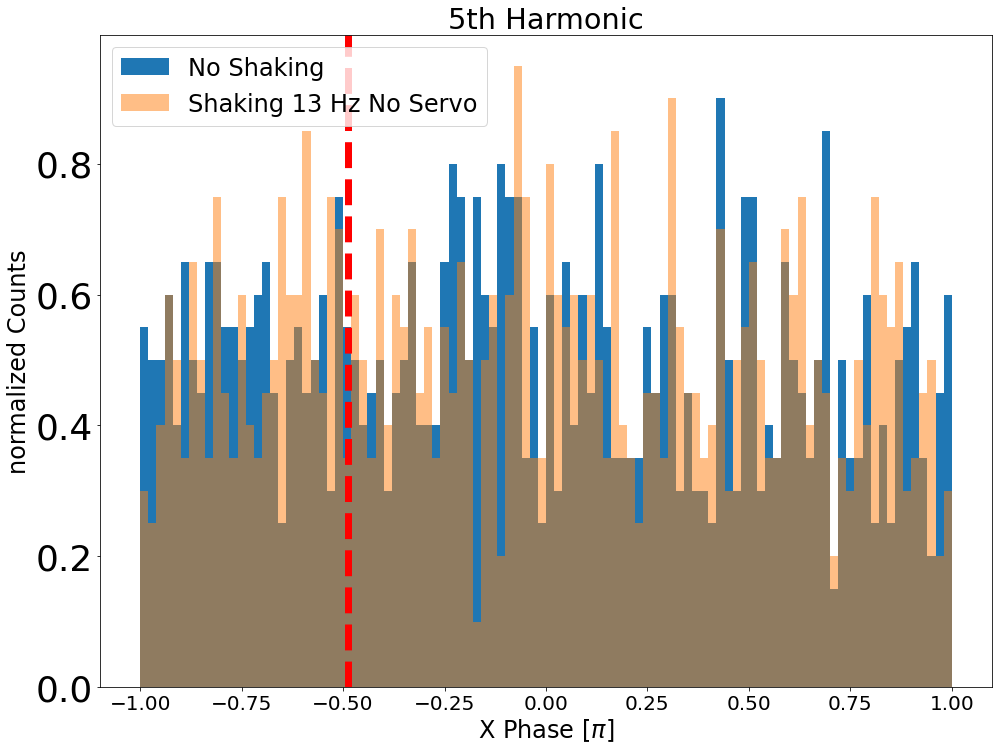

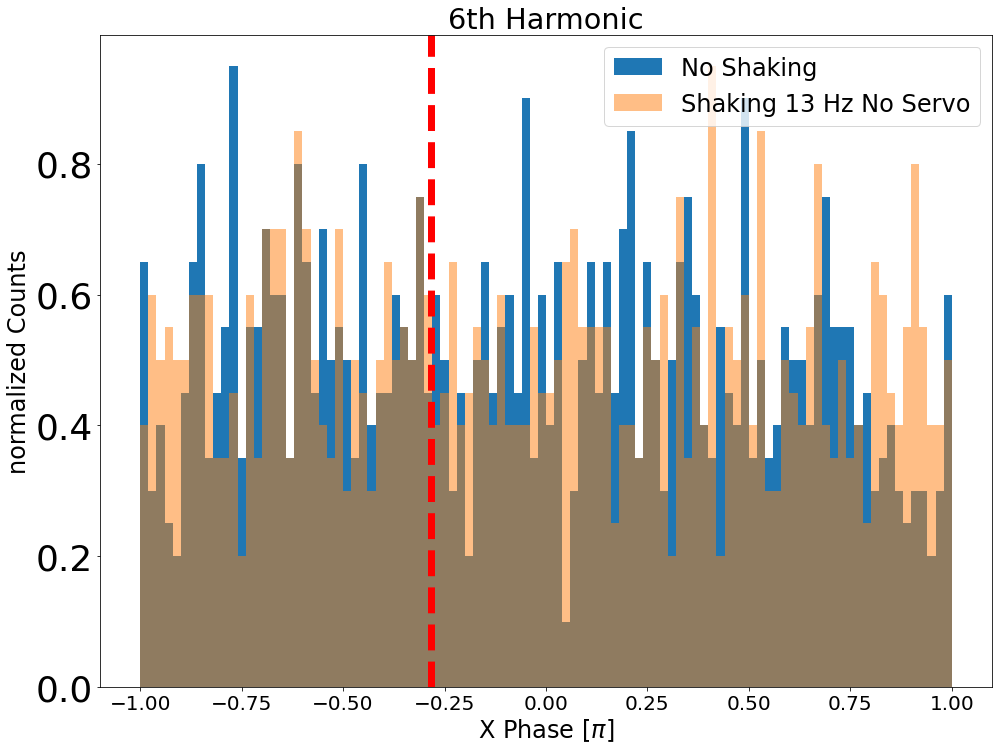

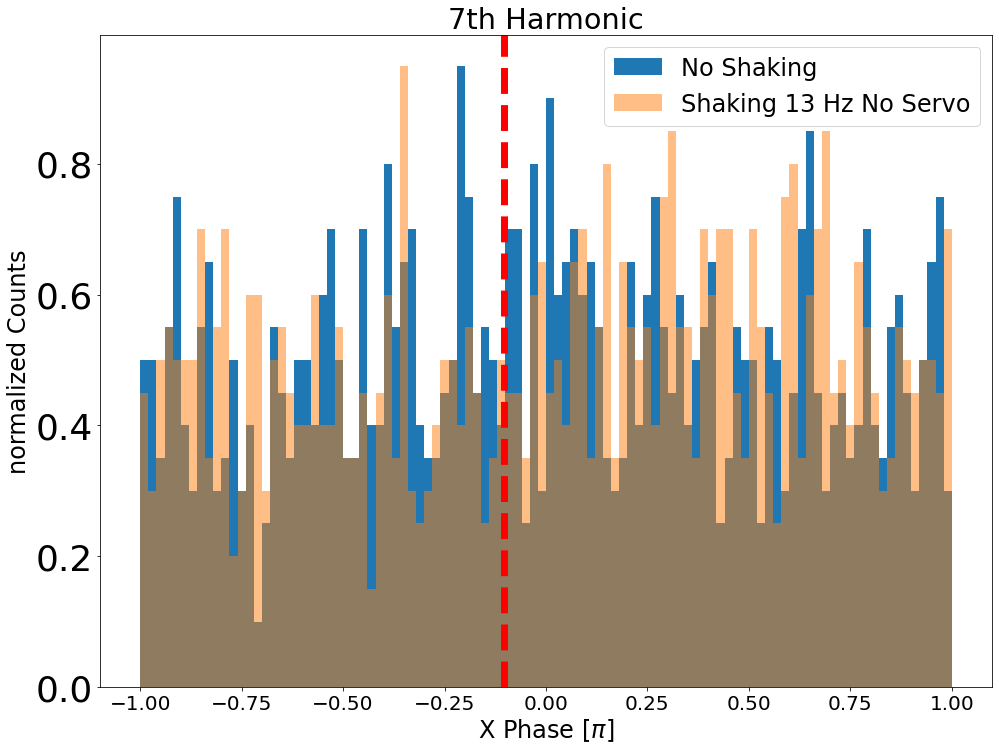

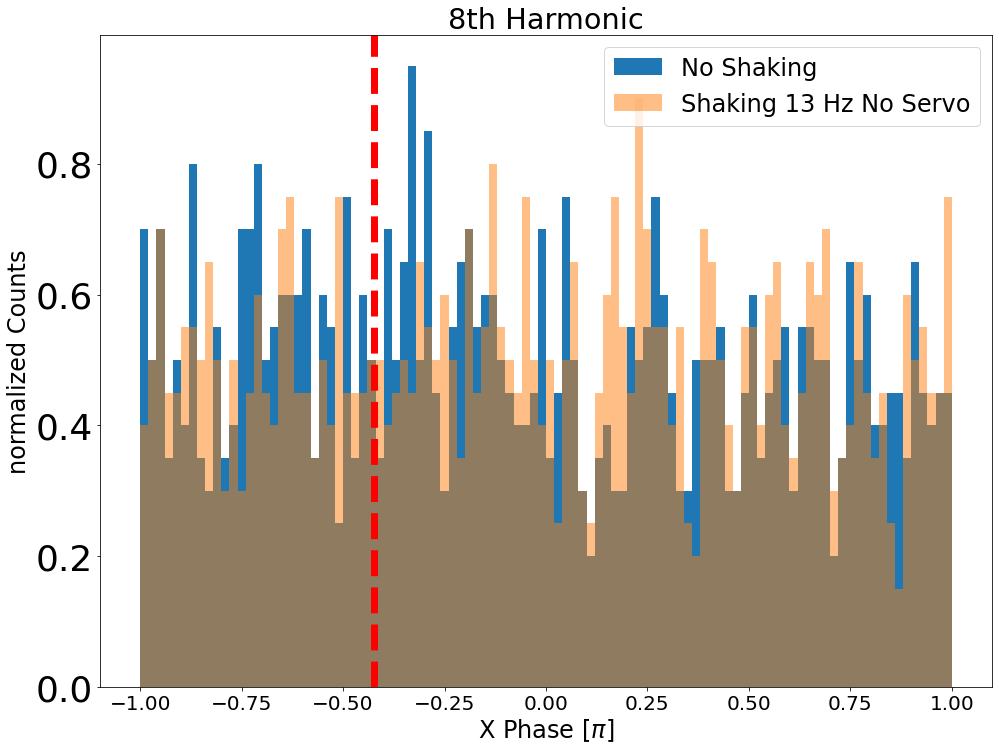

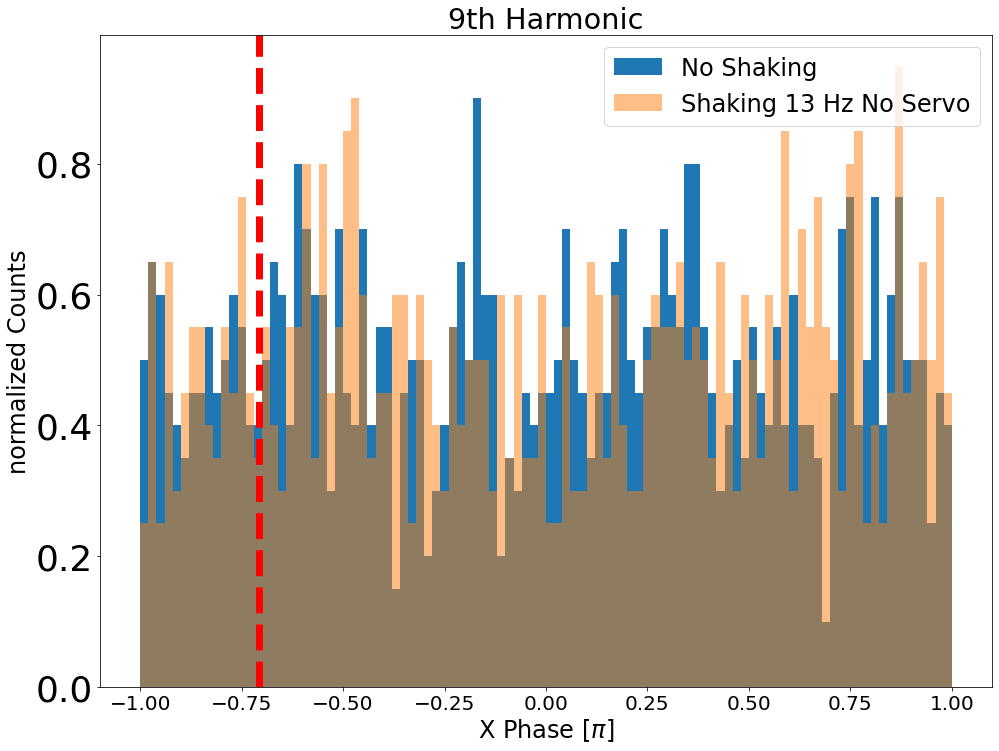

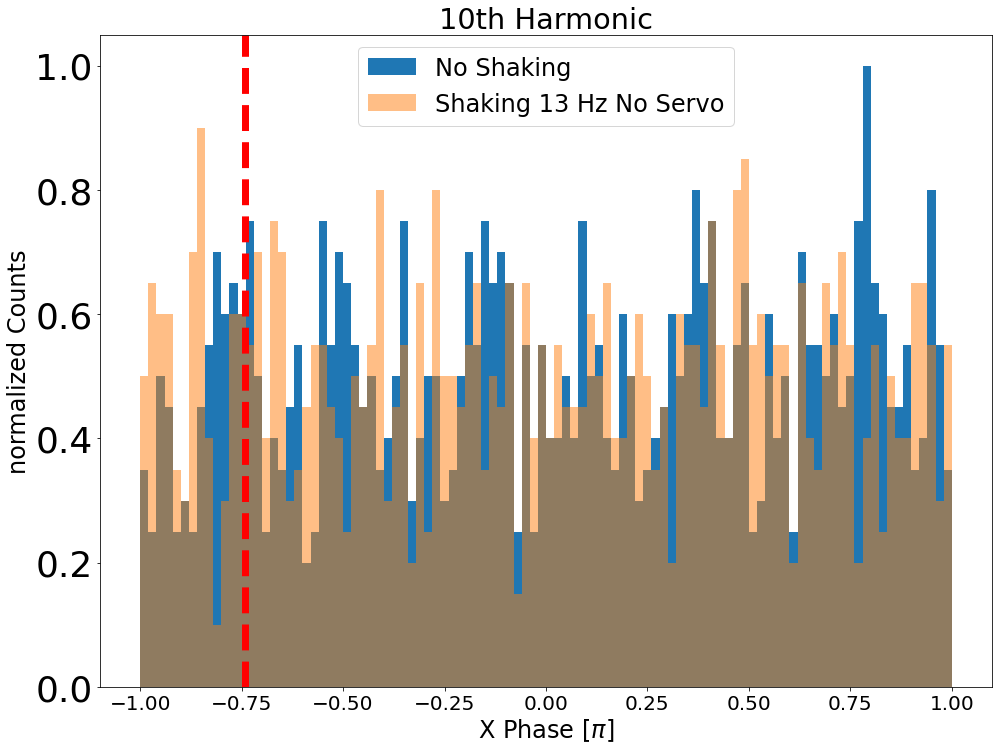

In [93]:
frequency=13
df0=df_NoShaking0
df1=df_Shaking13

for j in range(10):
    PhaseListX0 = []
    PhaseListX1 = []
    for i in range(len(df0)):
        PhaseListX0.append(df0["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListX1.append(df1["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("X Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListX0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListX1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    plt.axvline(df1["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

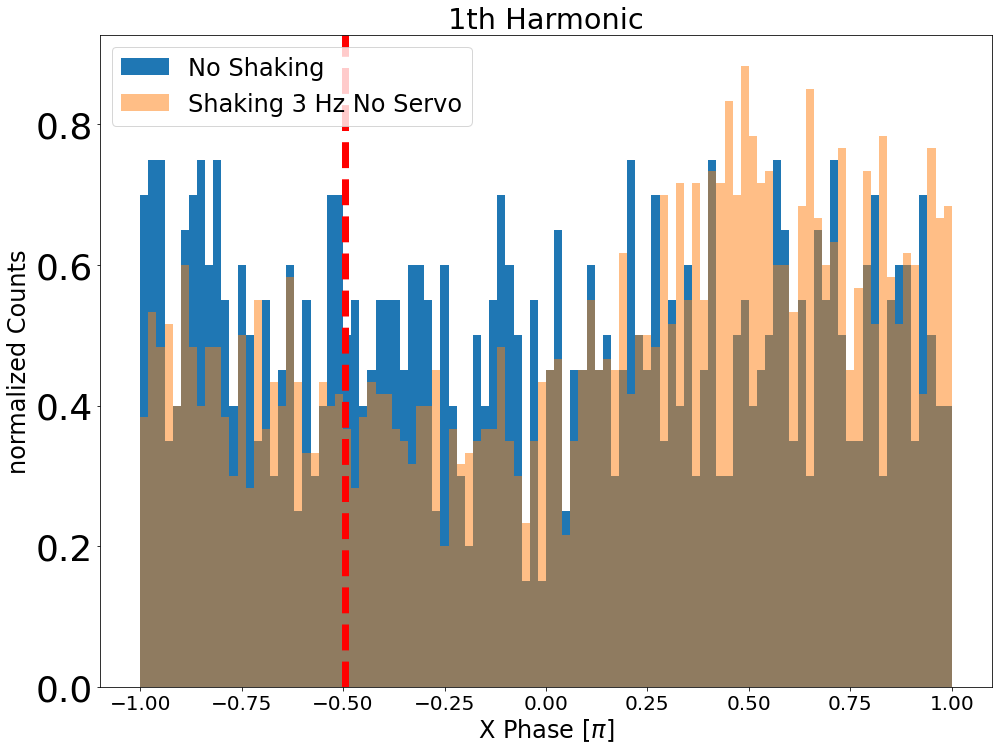

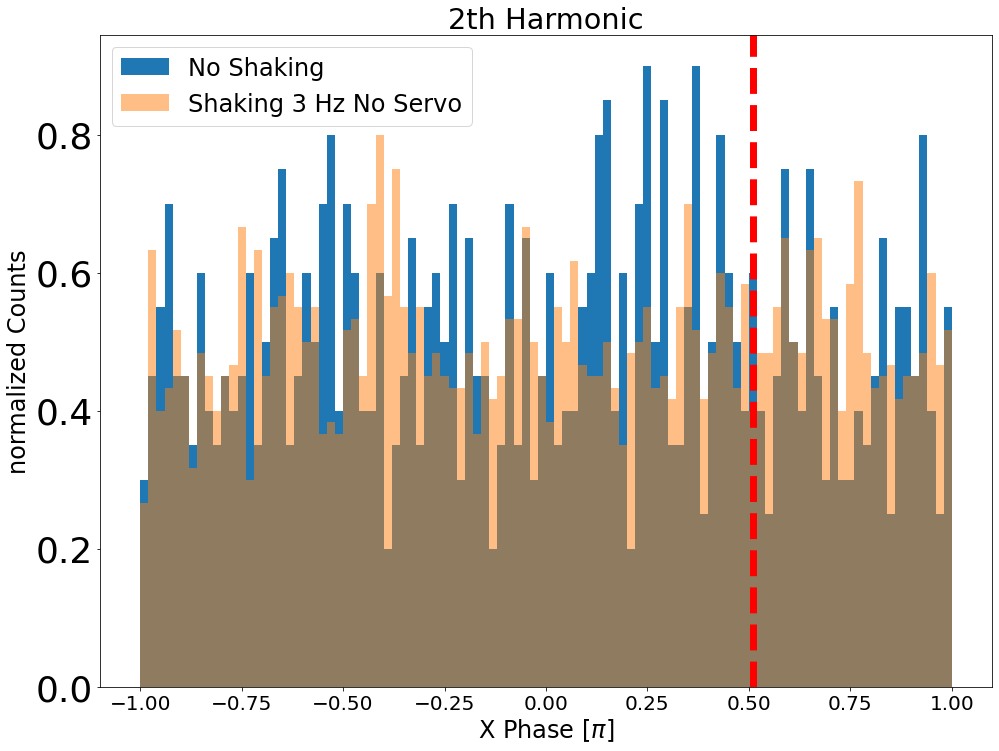

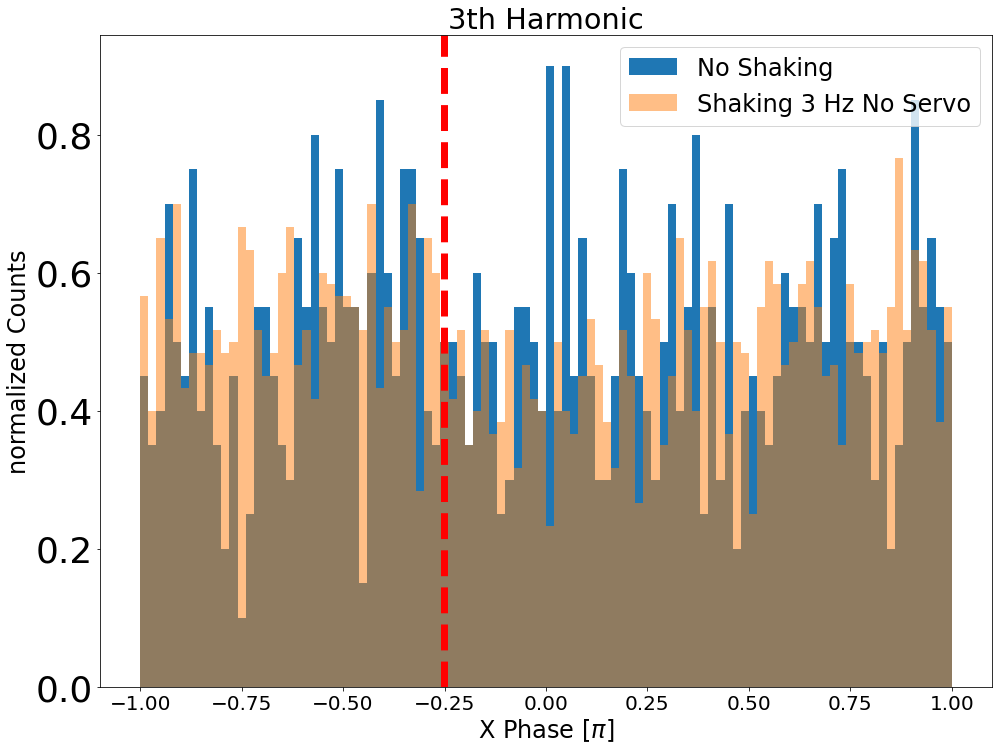

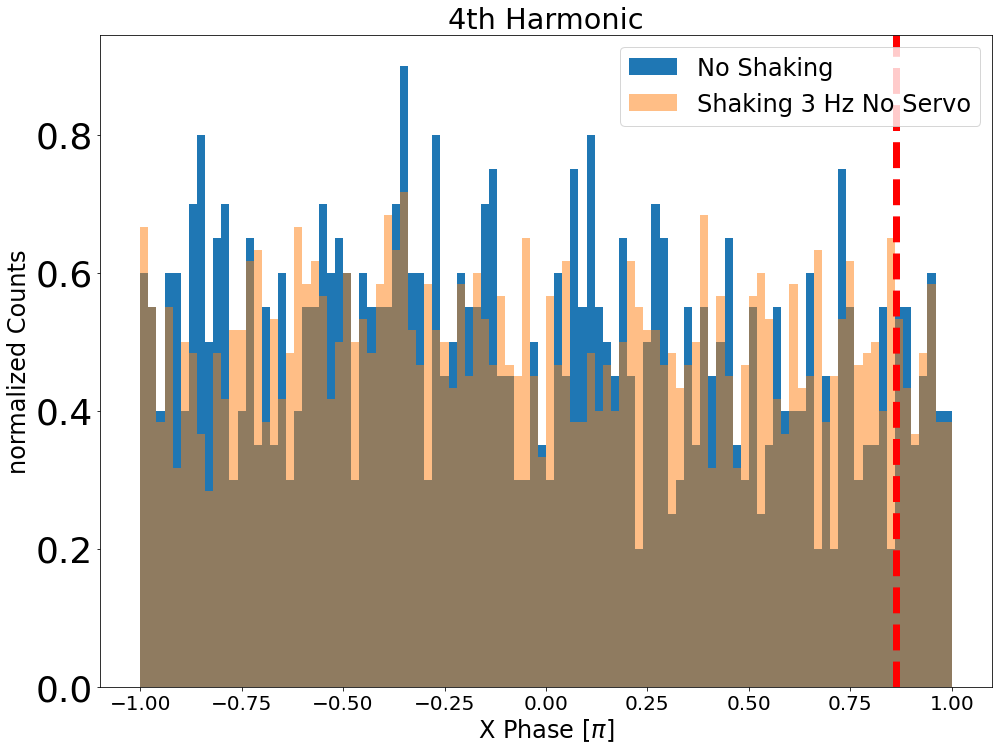

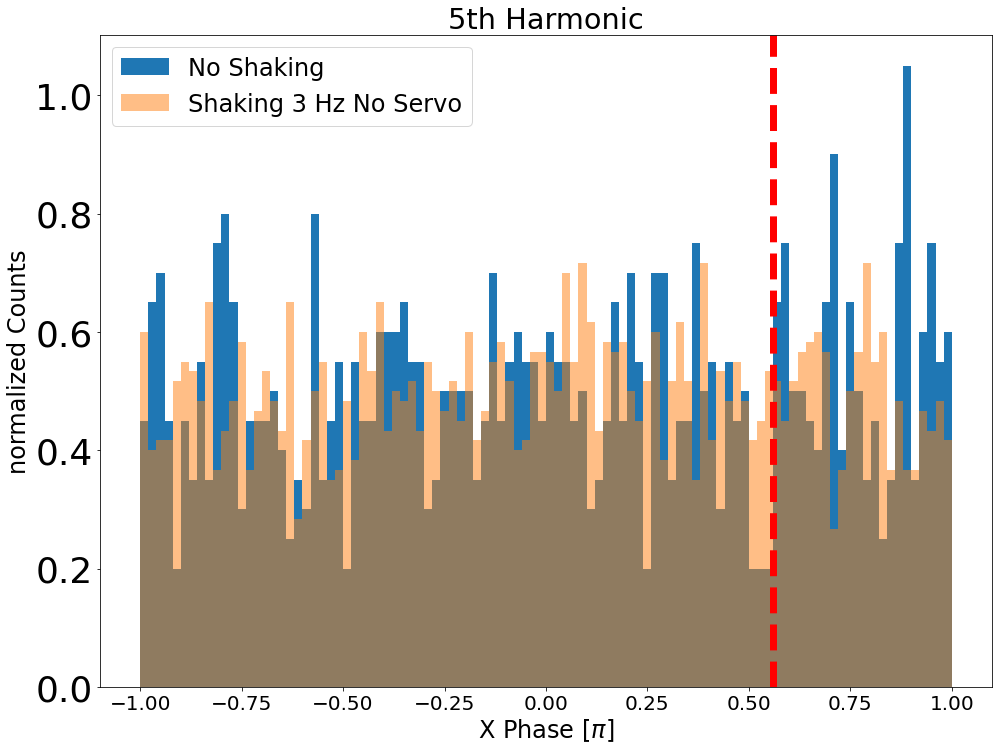

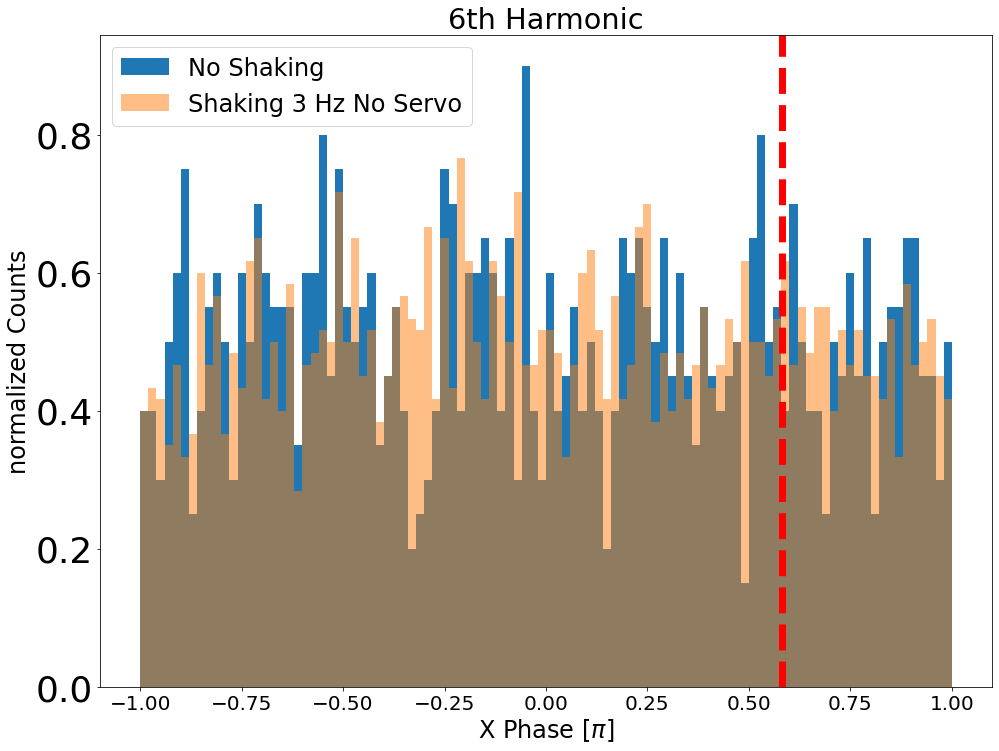

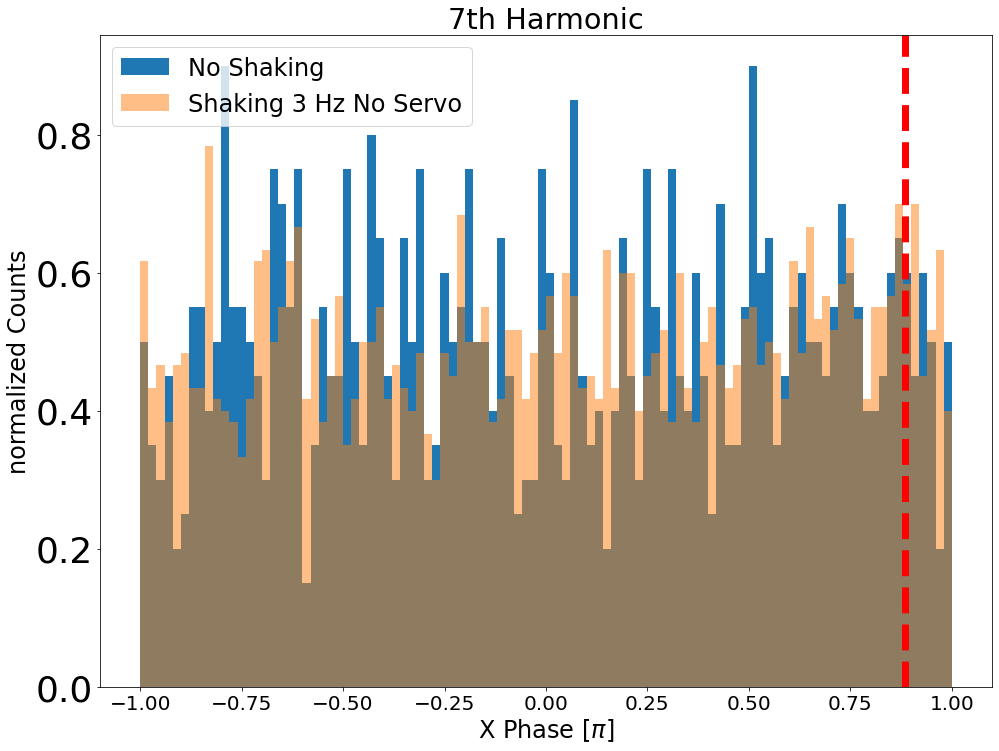

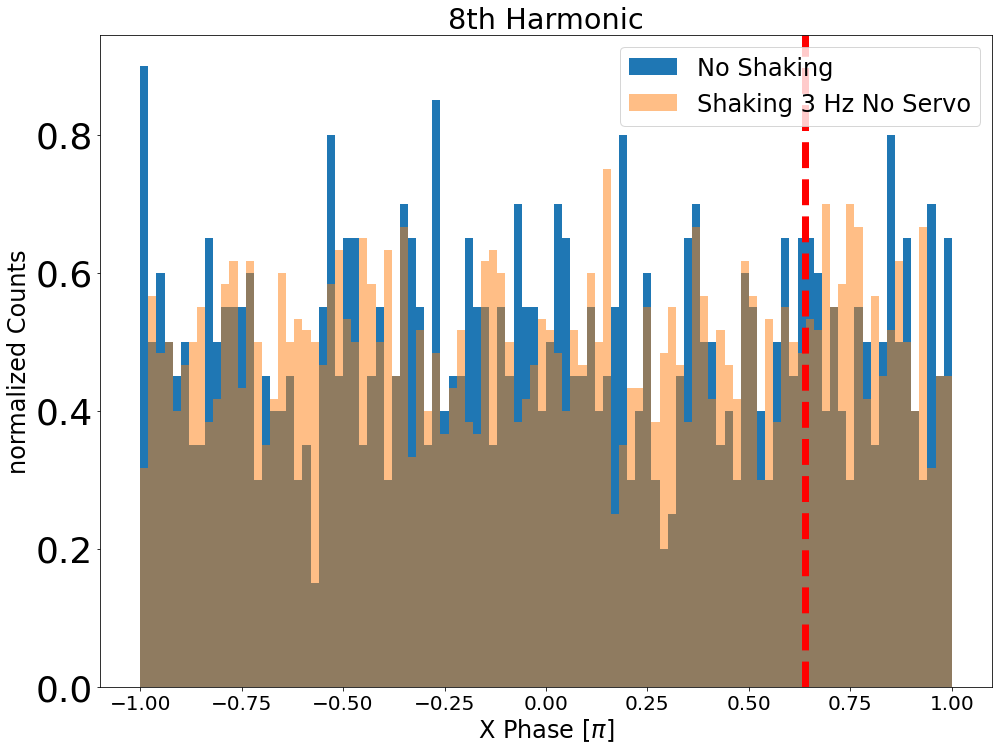

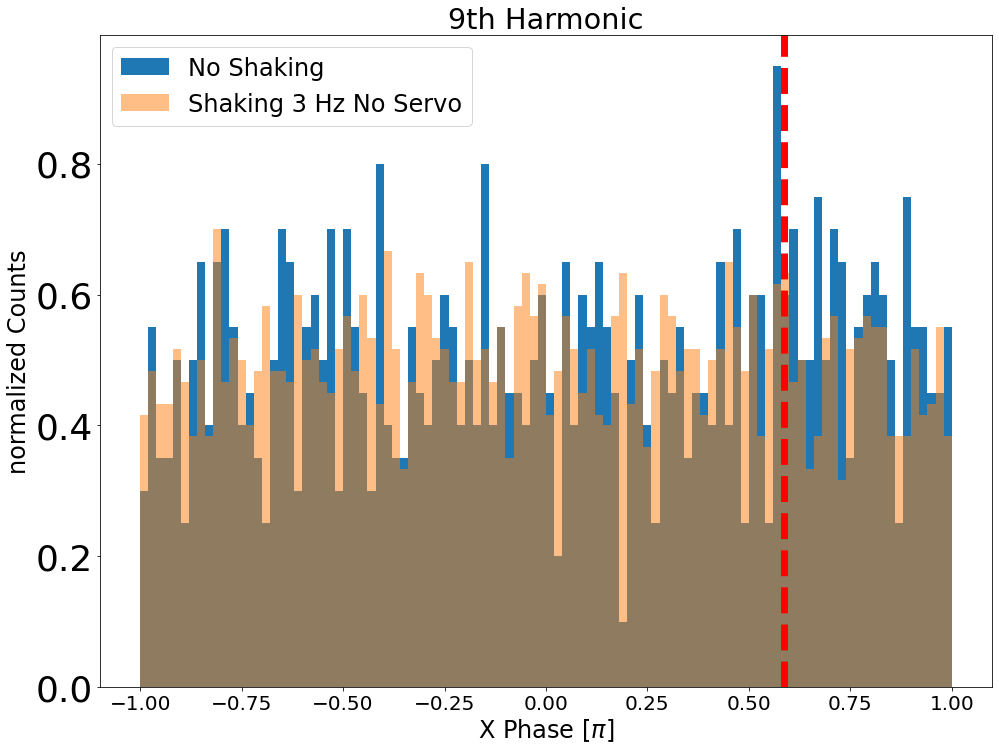

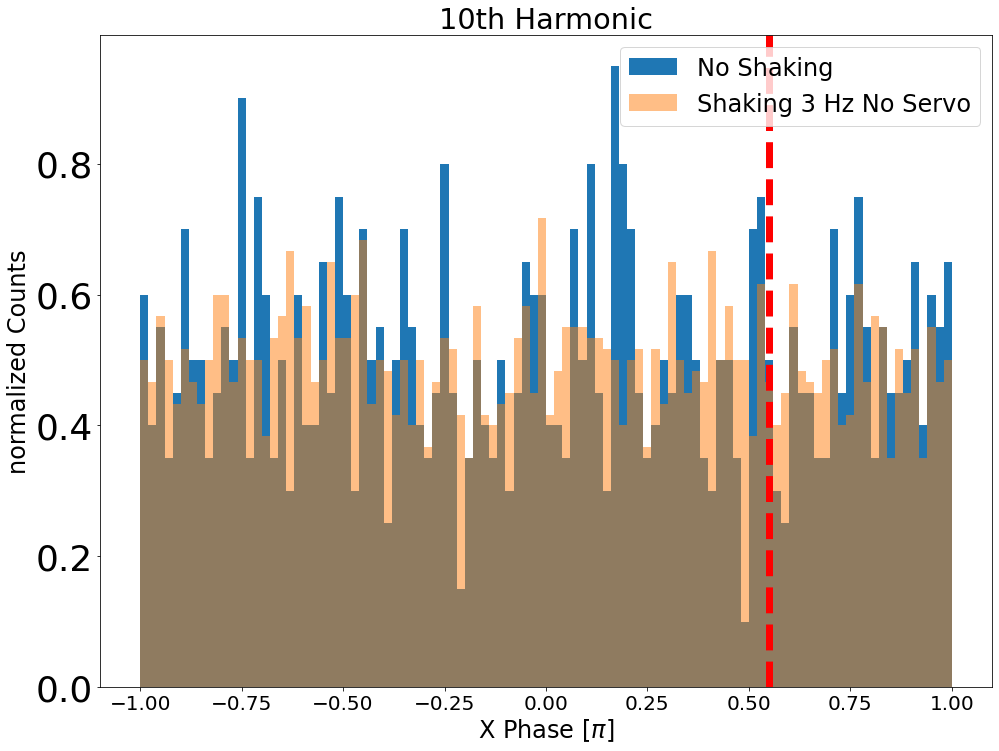

In [94]:
frequency=3
df0=df_NoShaking0
df1=df_Shaking3

for j in range(10):
    PhaseListX0 = []
    PhaseListX1 = []
    for i in range(len(df0)):
        PhaseListX0.append(df0["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListX1.append(df1["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("X Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListX0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListX1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    plt.axvline(df1["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

## now load data before EC removal

In [99]:
# folderName="/data/new_trap/20220605/VibrationTest/NoShaking/0/" 
# filePrefix="NoShaking"
# freqs,df_NoShaking0_before= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
# df_NoShaking0_before.to_pickle("Results/NoShaking_0_20220605.npy")

# folderName="/data/new_trap/20220605/VibrationTest/Shaking/1/" 
# filePrefix="Shaking"
# freqs,df_Shaking13_before= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
# df_Shaking13_before.to_pickle("Results/Shaking_1_20220605.npy")


1000
The process took 18.81
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
cantPosY    1000 non-null object
xAmp        1000 non-null object
xPhase      1000 non-null object
xPSD        1000 non-null object
yAmp        1000 non-null object
yPhase      1000 non-null object
yPSD        1000 non-null object
checkStd    1000 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.5 GB
None
1000
The process took 59.01
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
cantPosY    1000 non-null object
xAmp        1000 non-null object
xPhase      1000 non-null object
xPSD        1000 non-null object
yAmp        1000 non-null object
yPhase      1000 non-null object
yPSD        1000 non-null object
checkStd    1000 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.5 GB
None


In [101]:
#load the data
df_NoShaking0_before = pd.read_pickle("Results/NoShaking_0_20220605.npy")
df_Shaking13_before = pd.read_pickle("Results/Shaking_1_20220605.npy")


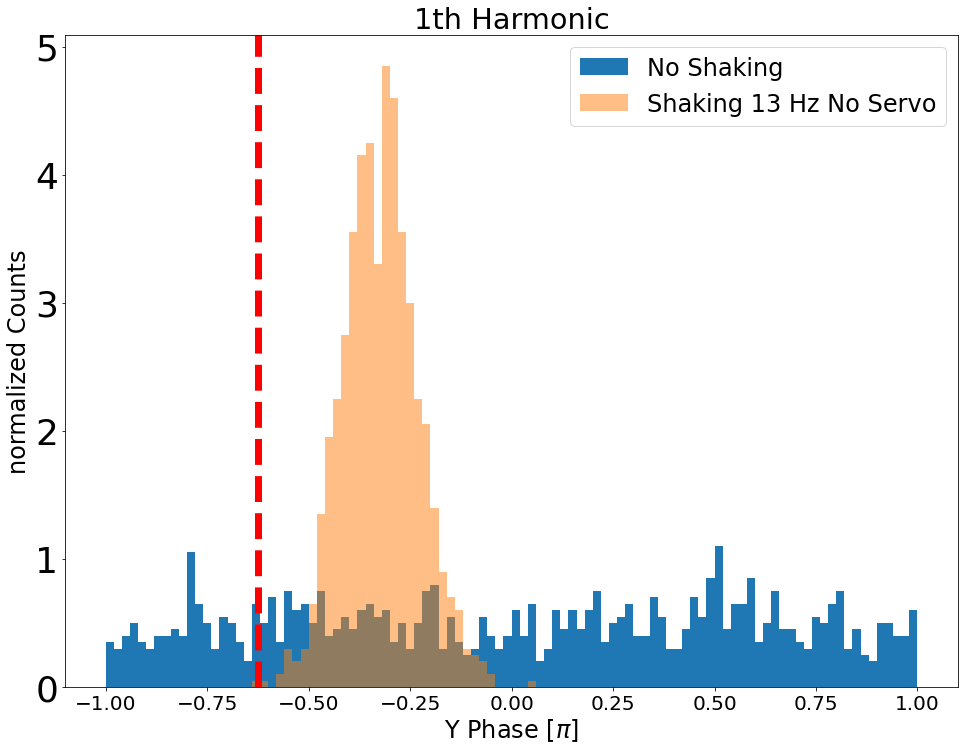

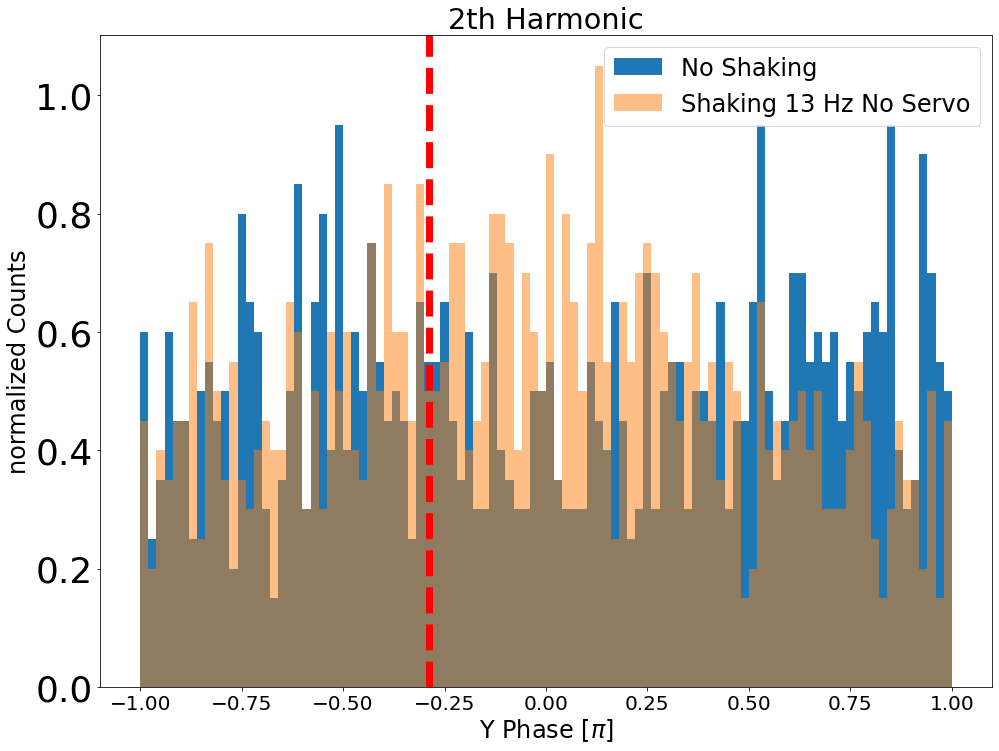

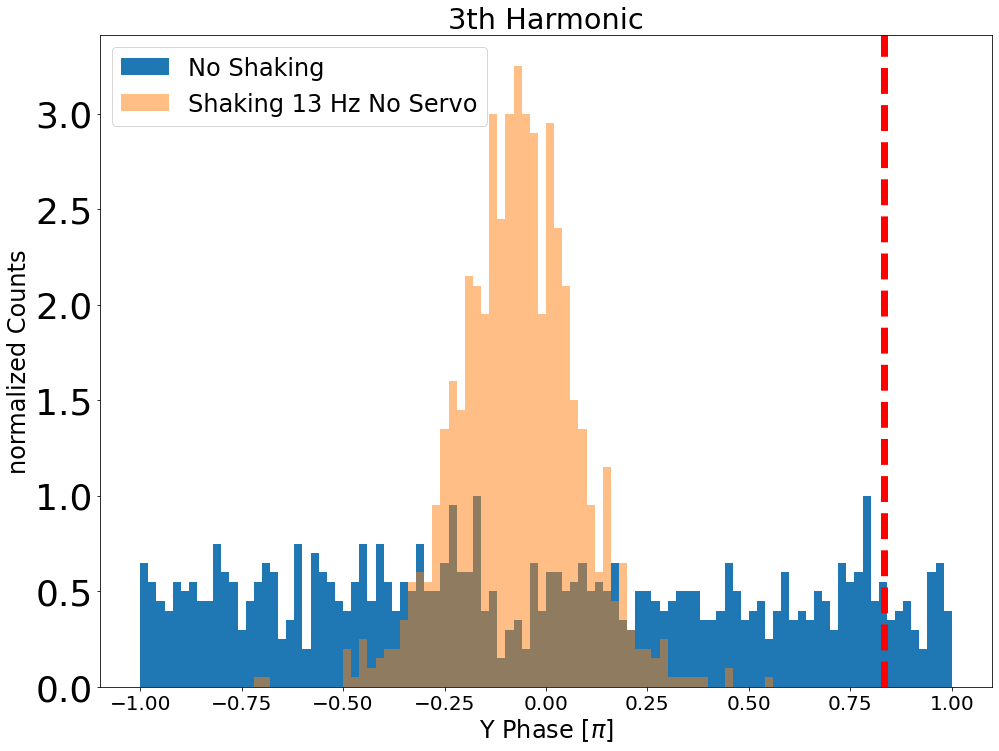

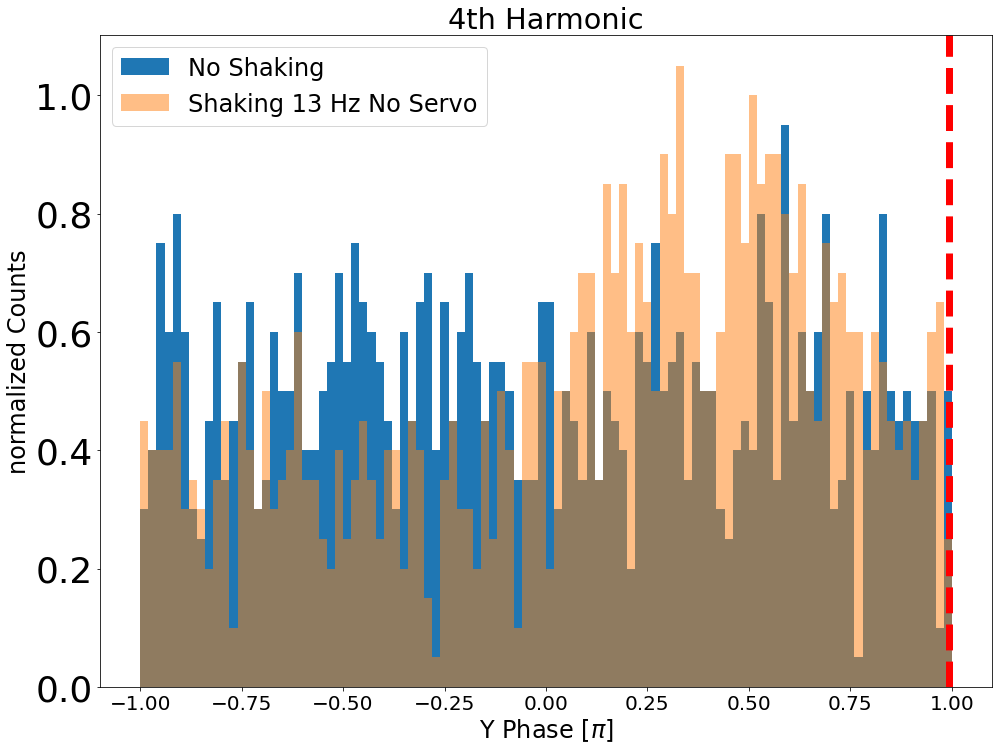

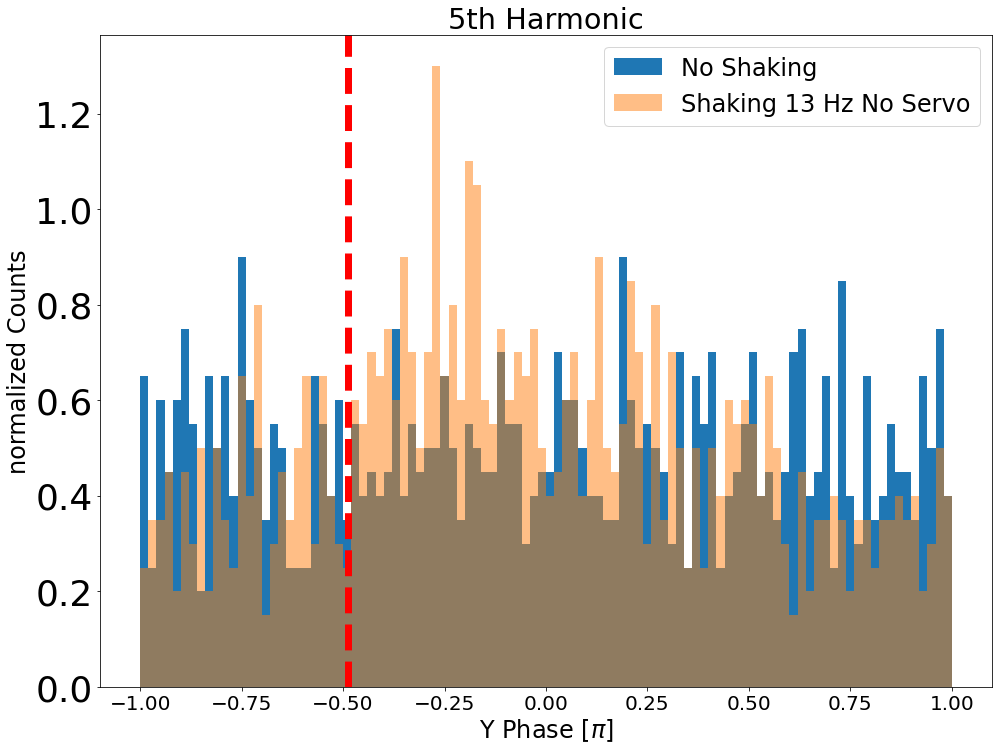

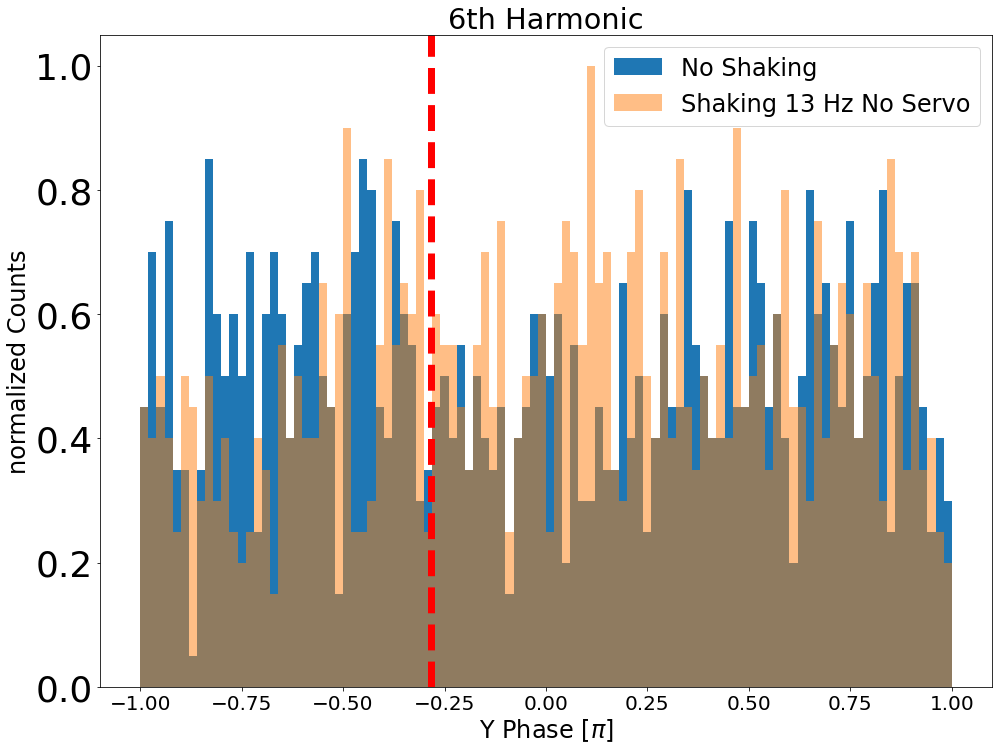

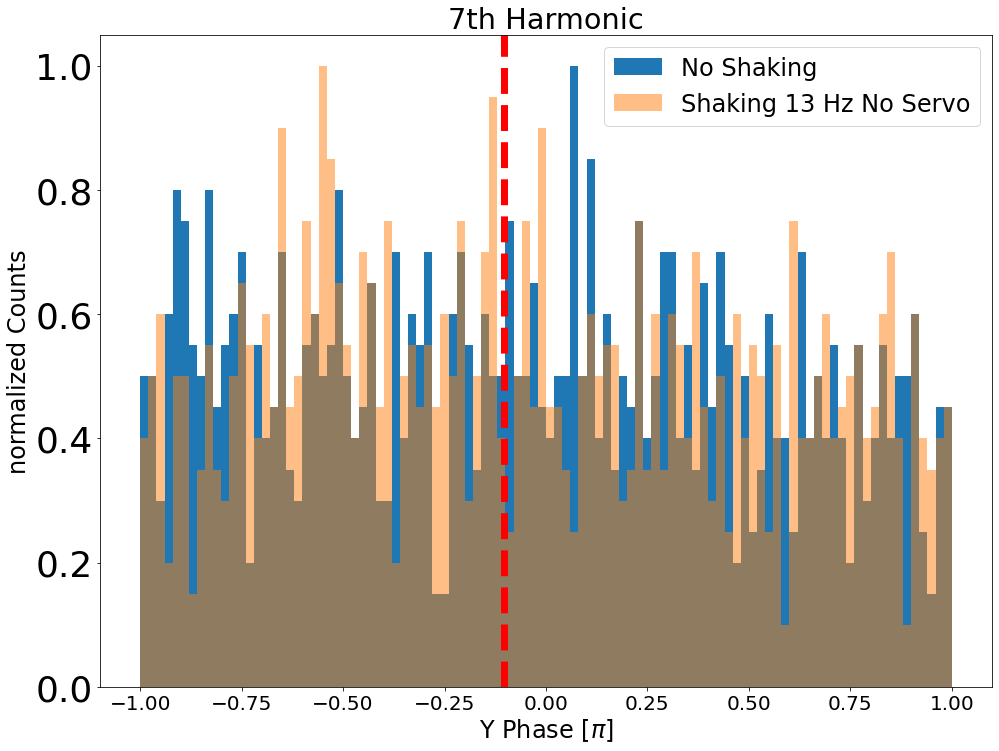

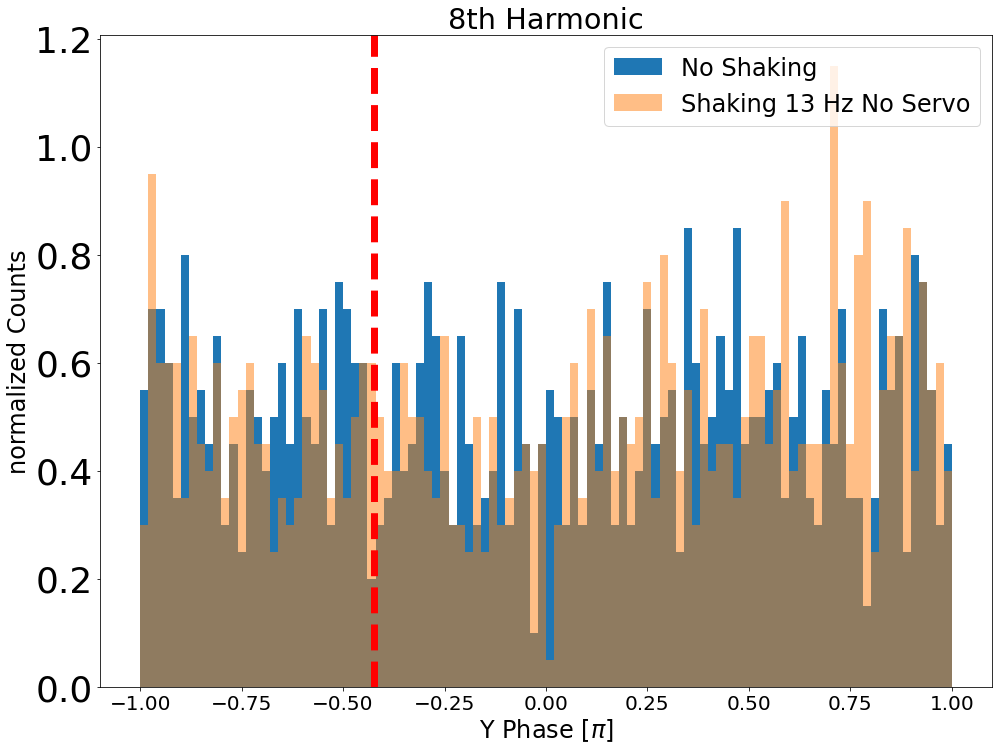

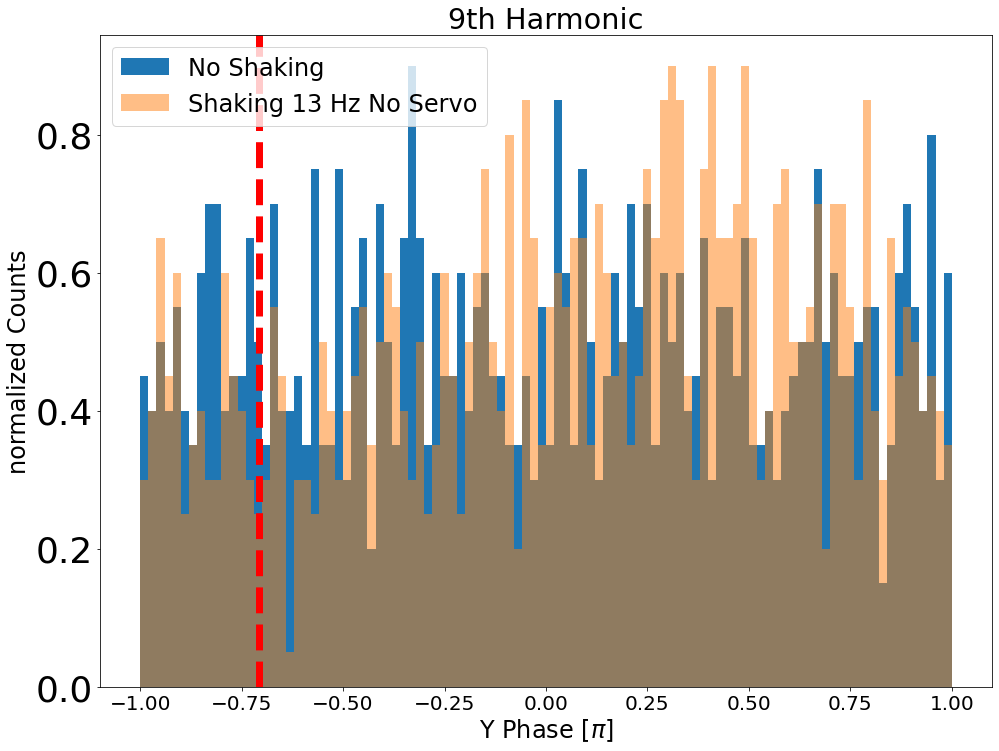

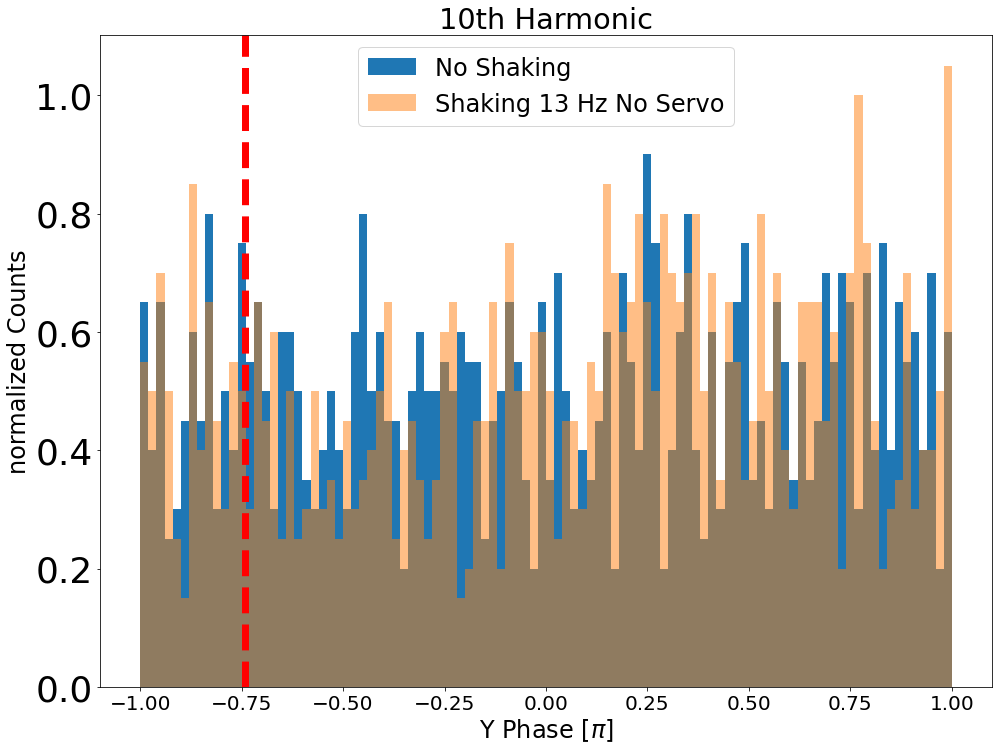

In [105]:
frequency=13
df0=df_NoShaking0_before
df1=df_Shaking13_before

for j in range(10):
    PhaseListY0 = []
    PhaseListY1 = []
    for i in range(len(df0)):
        PhaseListY0.append(df0["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListY1.append(df1["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("Y Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListY0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListY1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    plt.axvline(df_Shaking13["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

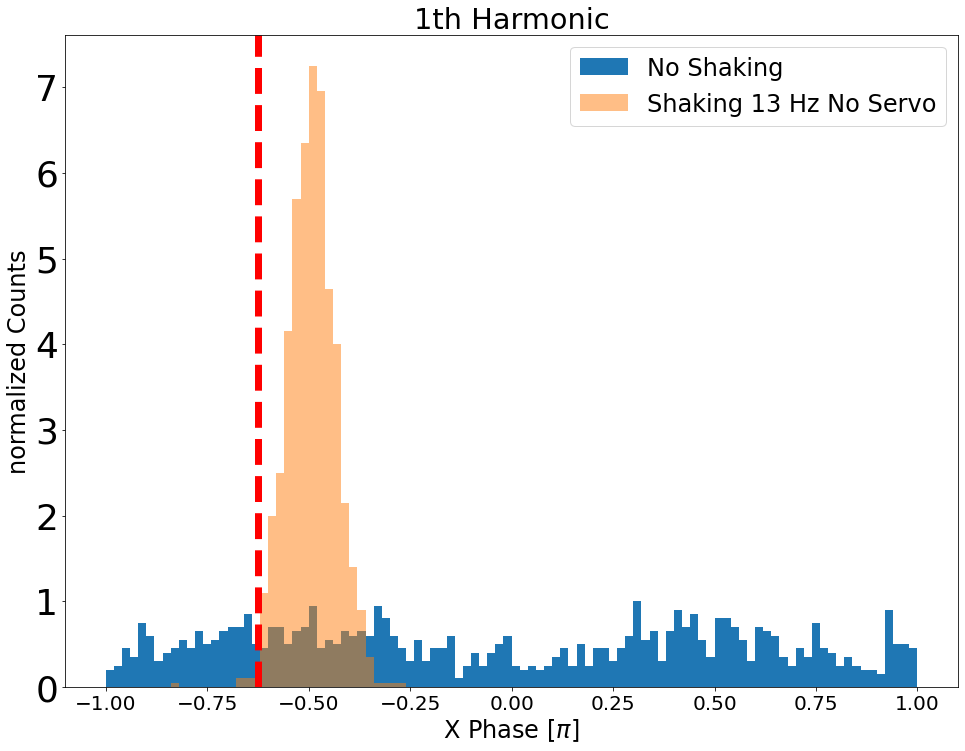

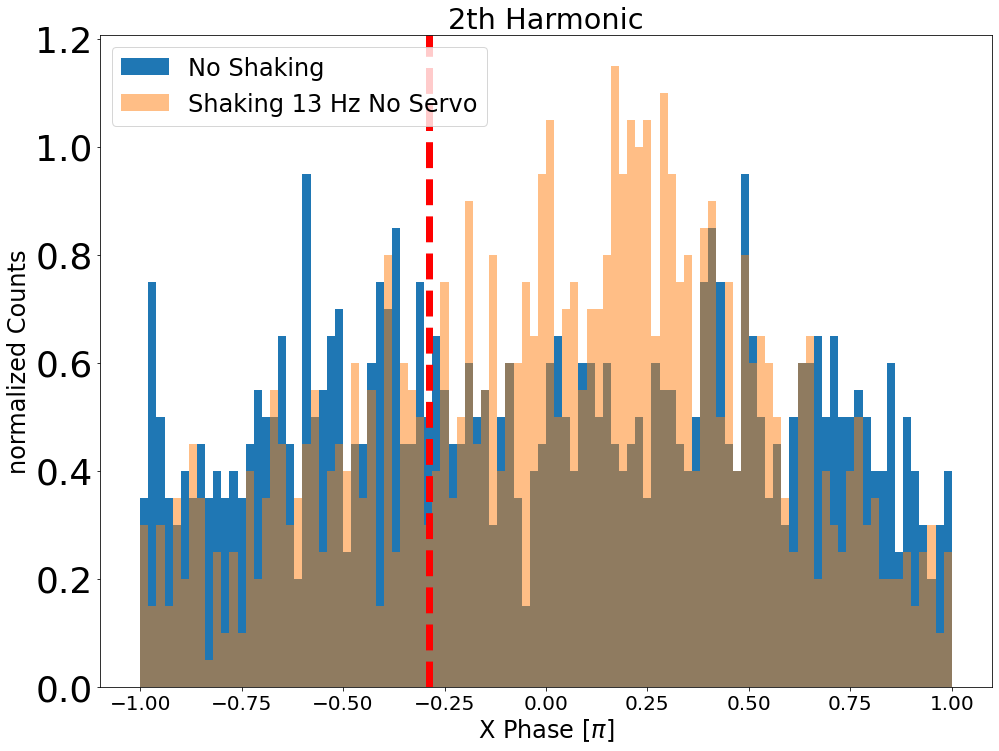

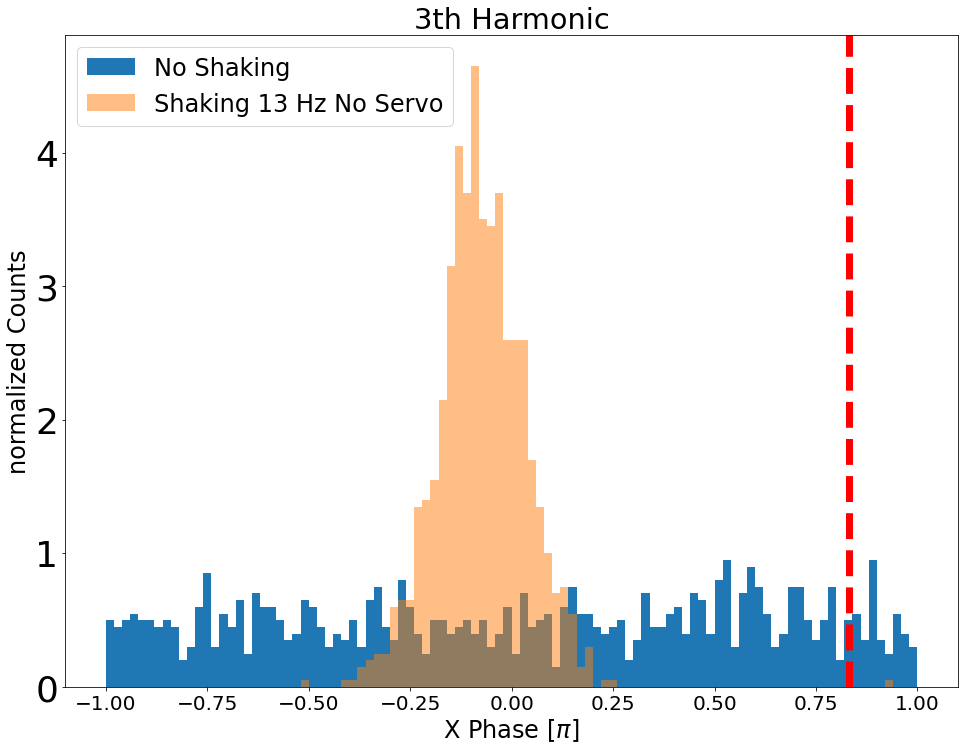

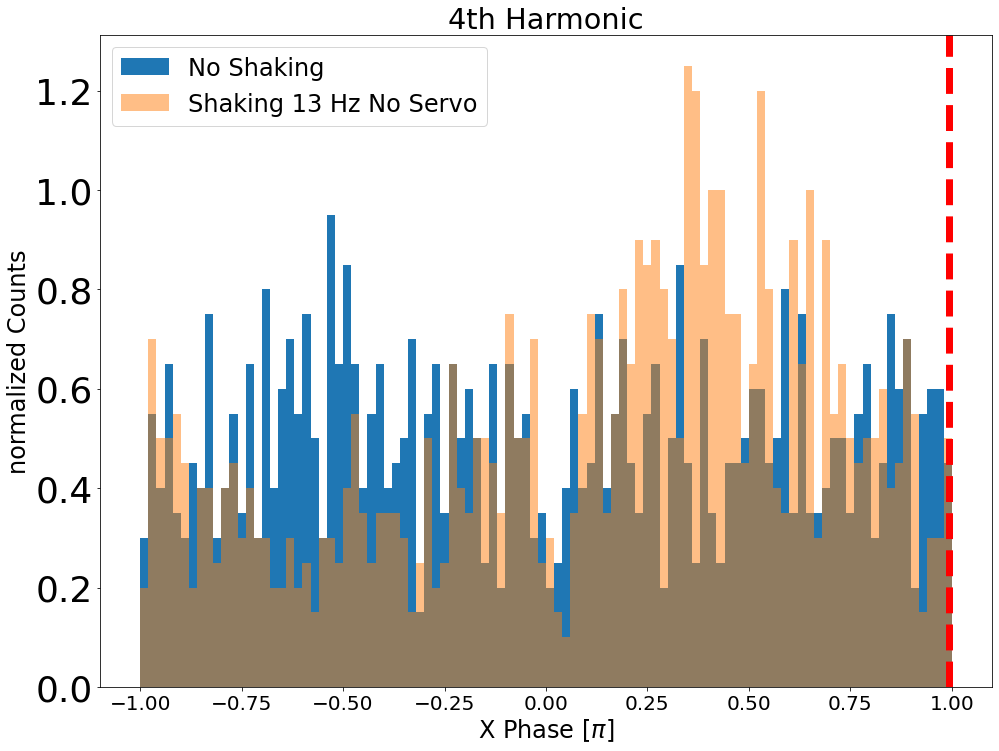

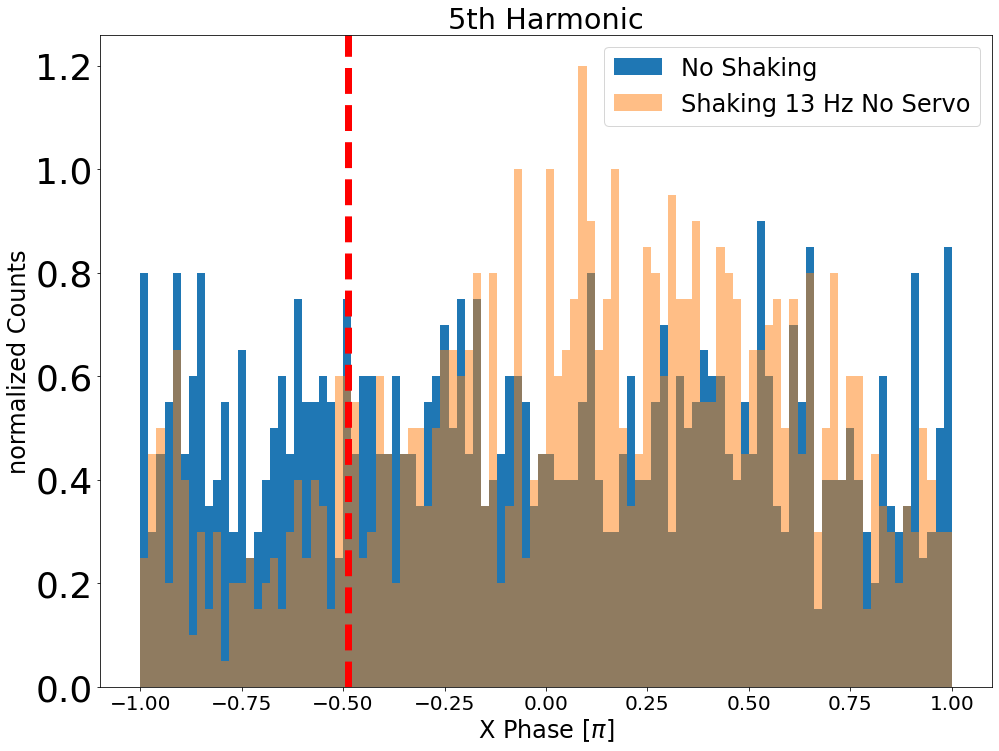

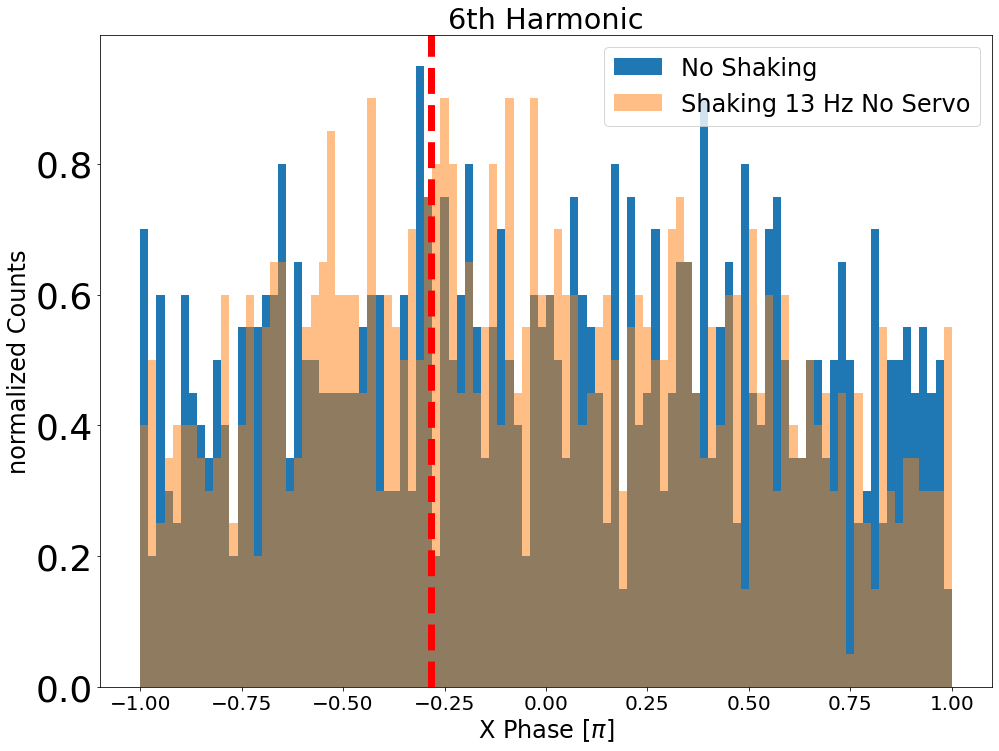

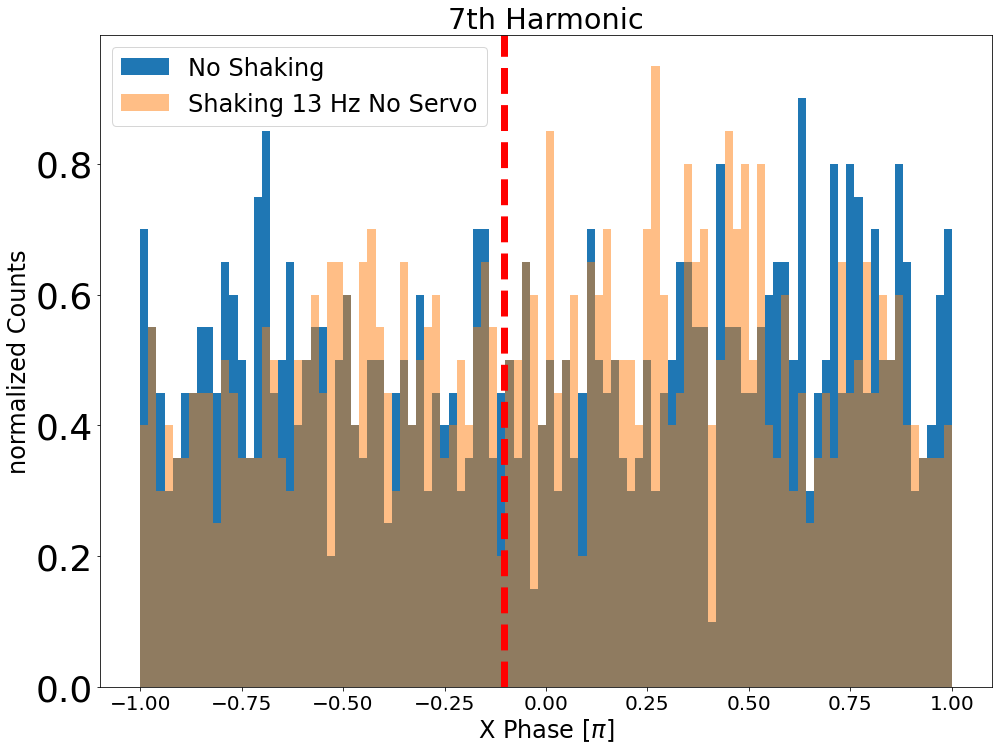

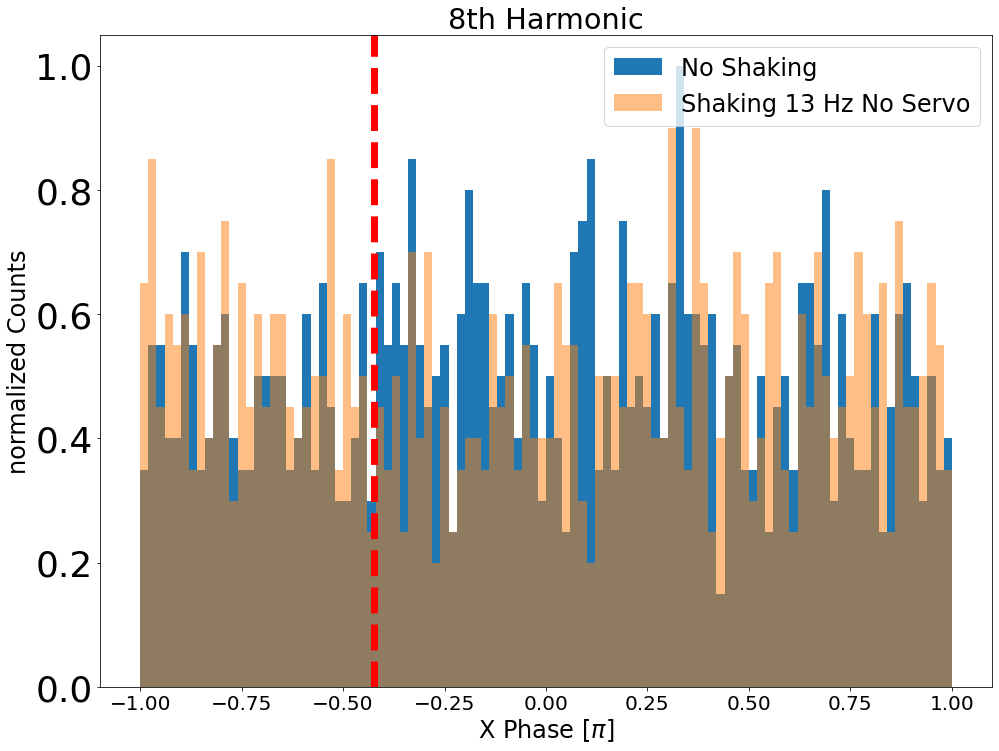

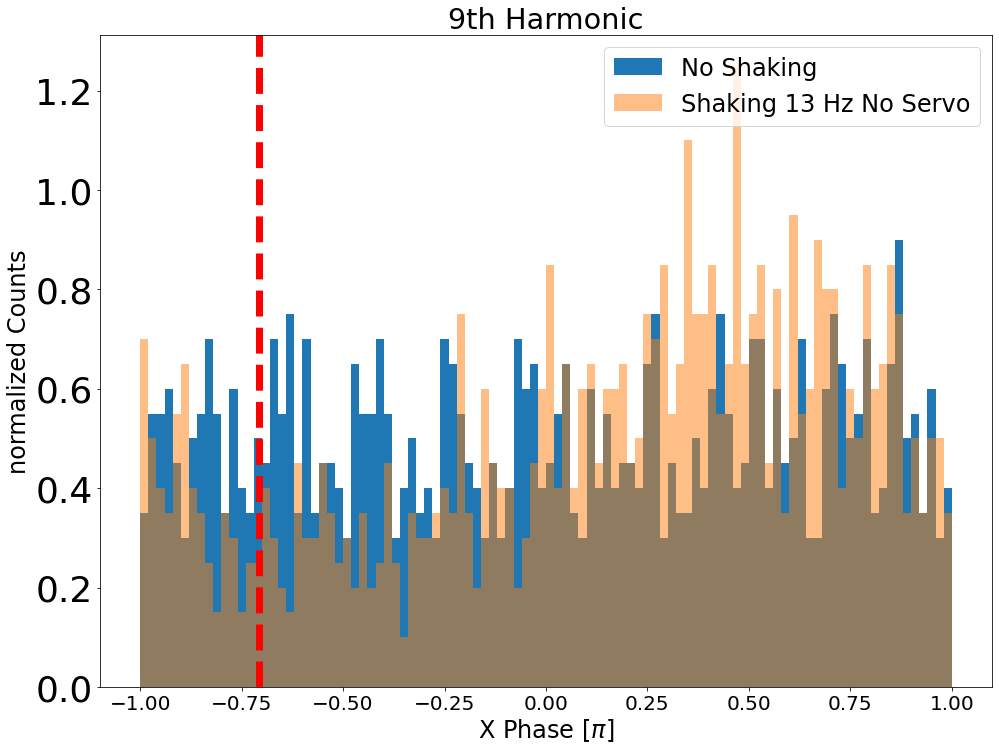

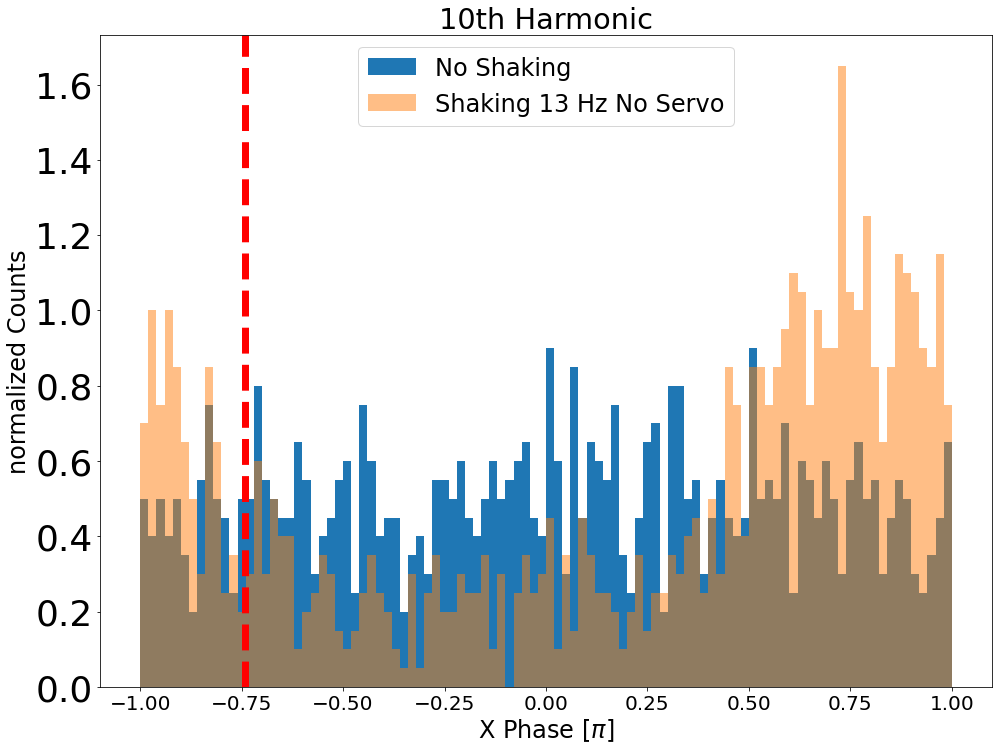

In [110]:
frequency=13
df0=df_NoShaking0_before
df1=df_Shaking13_before

for j in range(10):
    PhaseListX0 = []
    PhaseListX1 = []
    for i in range(len(df0)):
        PhaseListX0.append(df0["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListX1.append(df1["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("X Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListX0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListX1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    plt.axvline(df_Shaking13["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

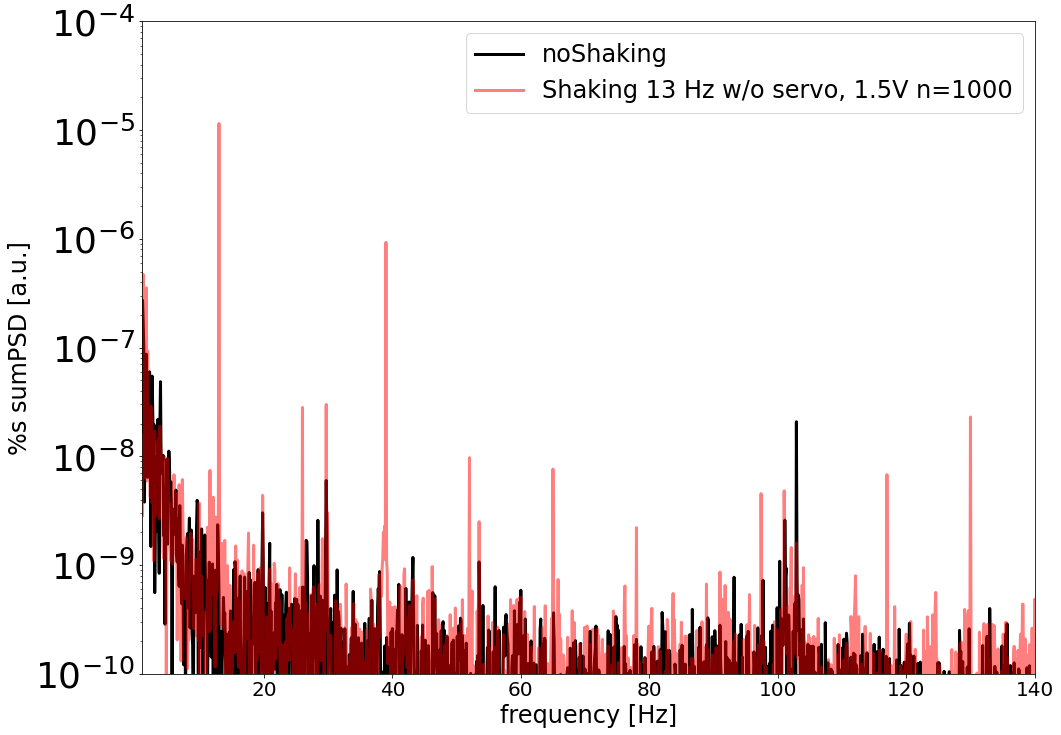

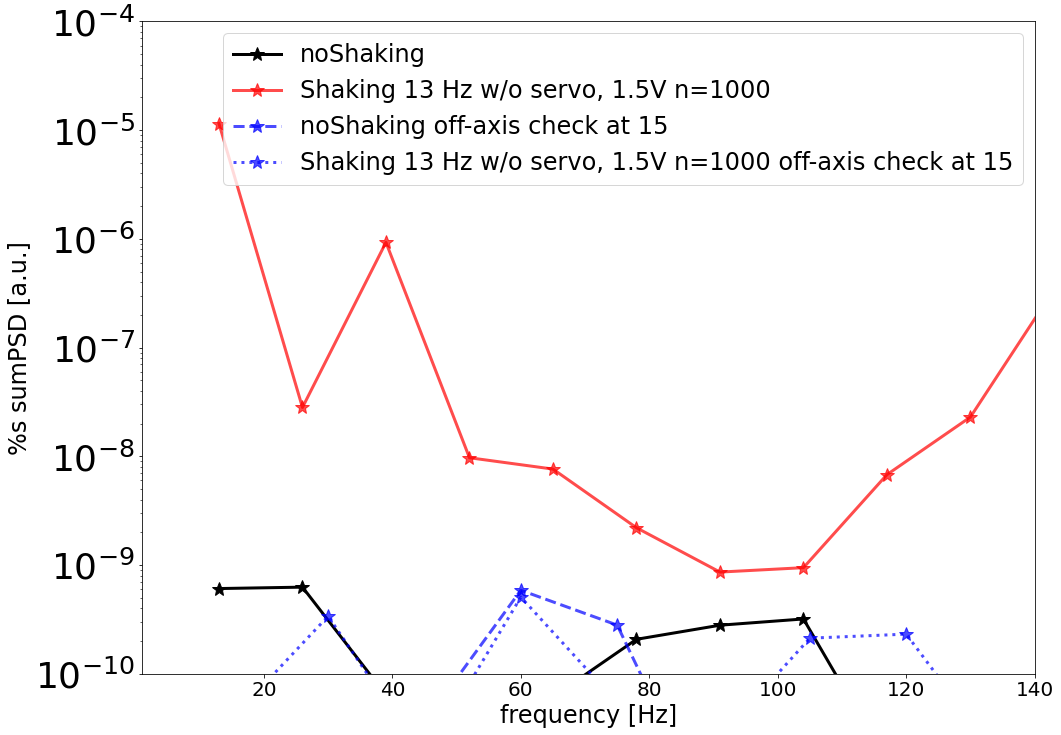

In [108]:
data1=df_NoShaking0_before
data2=df_Shaking13_before
plotQuickAlternatemethod(13,df_1=data1,df_2=data2,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=1e-10,upylim=1e-4,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

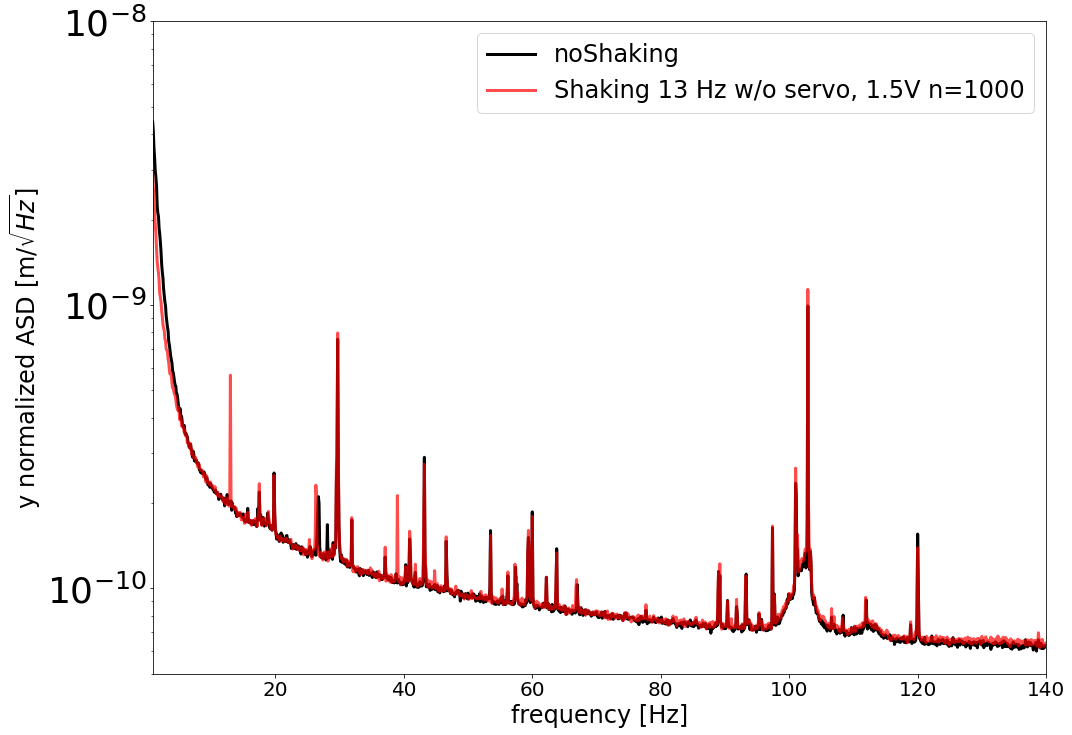

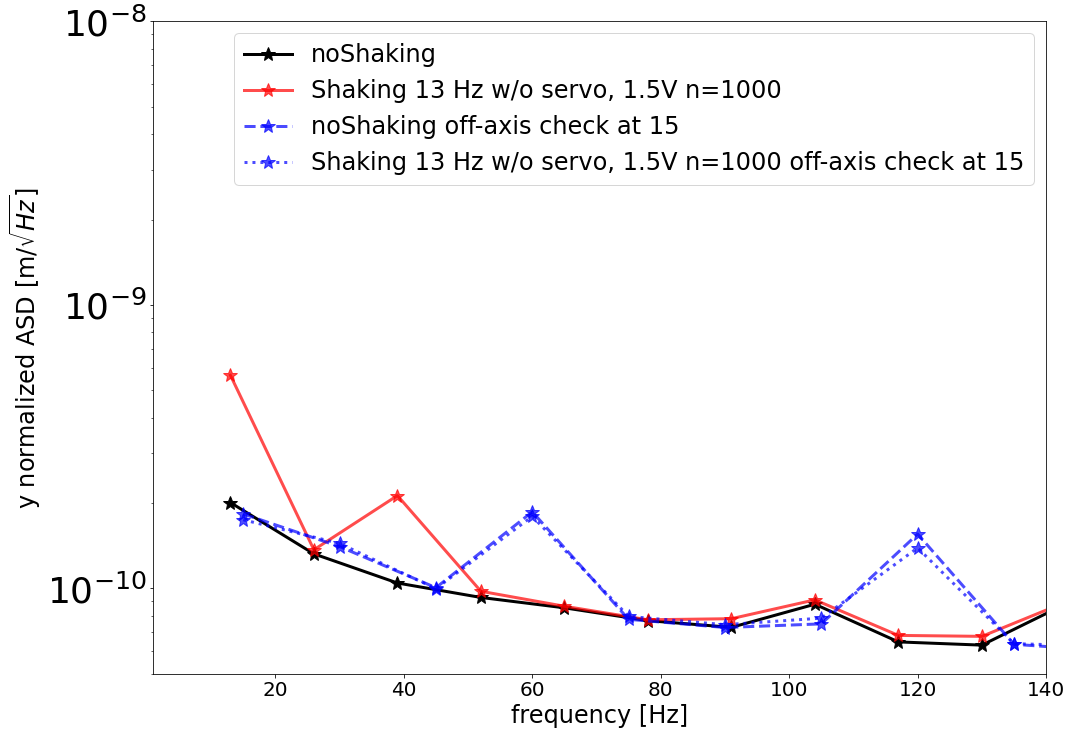

In [117]:
data1=df_NoShaking0_before
data2=df_Shaking13_before
plotQuickASD(13,df_1=data1,df_2=data2,axis="y",label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=5e-11,upylim=1e-8,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

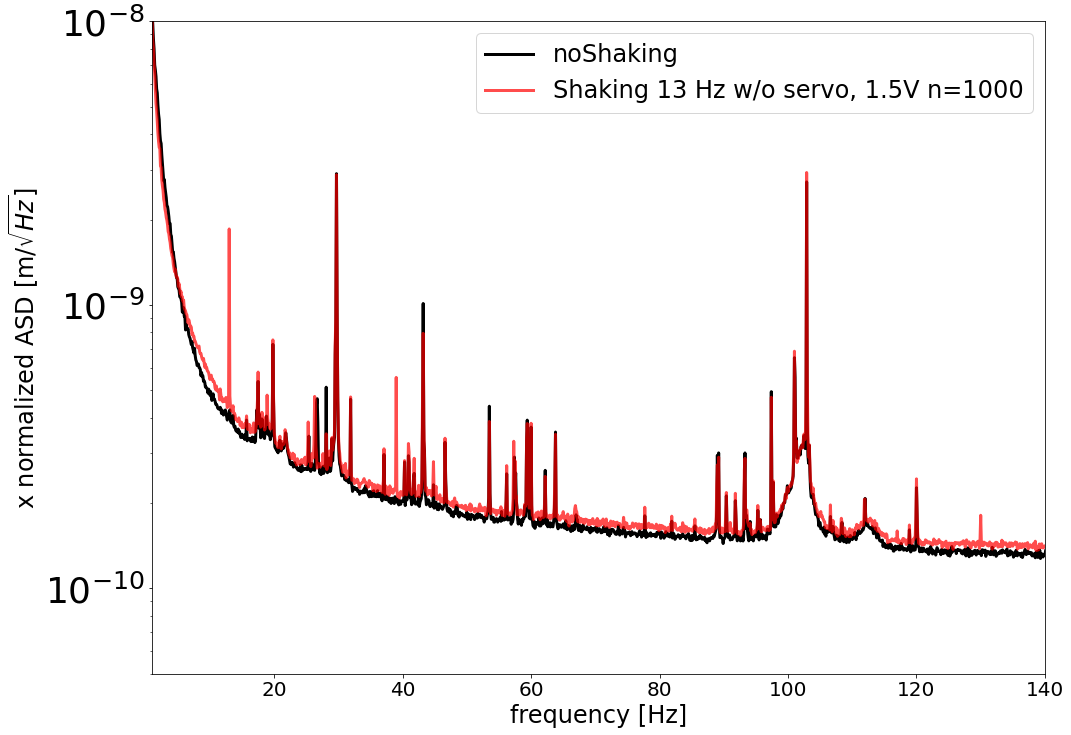

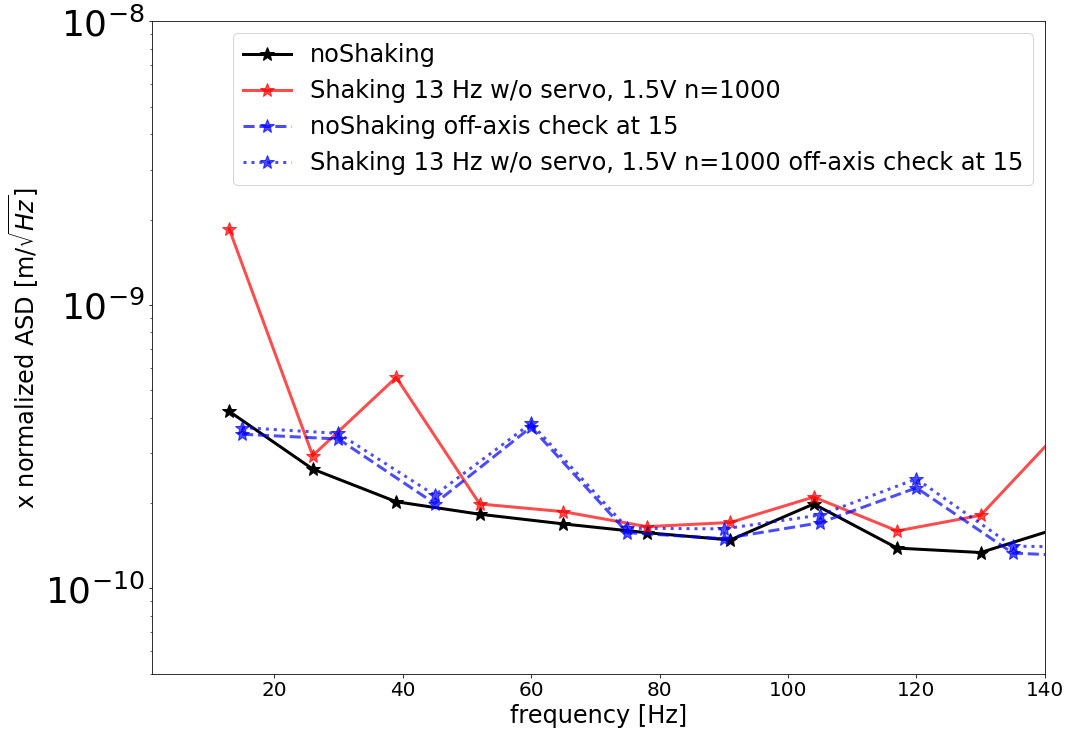

In [118]:
data1=df_NoShaking0_before
data2=df_Shaking13_before
plotQuickASD(13,df_1=data1,df_2=data2,axis="x",label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=5e-11,upylim=1e-8,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

In [10]:
## Old data

In [11]:
folderName="/data/new_trap/20220526/Bead0/NoShaking/1/" 
filePrefix="NoShaking"
freqs,df_NoShaking0_20220526= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
df_NoShaking0_20220526.to_pickle("Results/NoShaking_1_20220526.npy")

folderName="/data/new_trap/20220526/Bead0/Shaking/13Hz/NoServo/1/" 
filePrefix="Shaking"
freqs,df_Shaking13_20220526= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=6e4,calibrationFactorY=3.5e5)
df_Shaking13_20220526.to_pickle("Results/Shaking_1_20220526.npy")


1000
The process took 60.05
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
cantPosY    1000 non-null object
xAmp        1000 non-null object
xPhase      1000 non-null object
xPSD        1000 non-null object
yAmp        1000 non-null object
yPhase      1000 non-null object
yPSD        1000 non-null object
checkStd    1000 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.5 GB
None
1000
The process took 58.68
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
cantPosY    1000 non-null object
xAmp        1000 non-null object
xPhase      1000 non-null object
xPSD        1000 non-null object
yAmp        1000 non-null object
yPhase      1000 non-null object
yPSD        1000 non-null object
checkStd    1000 non-null float64
dtypes: float64(1), object(7)
memory usage: 1.5 GB
None


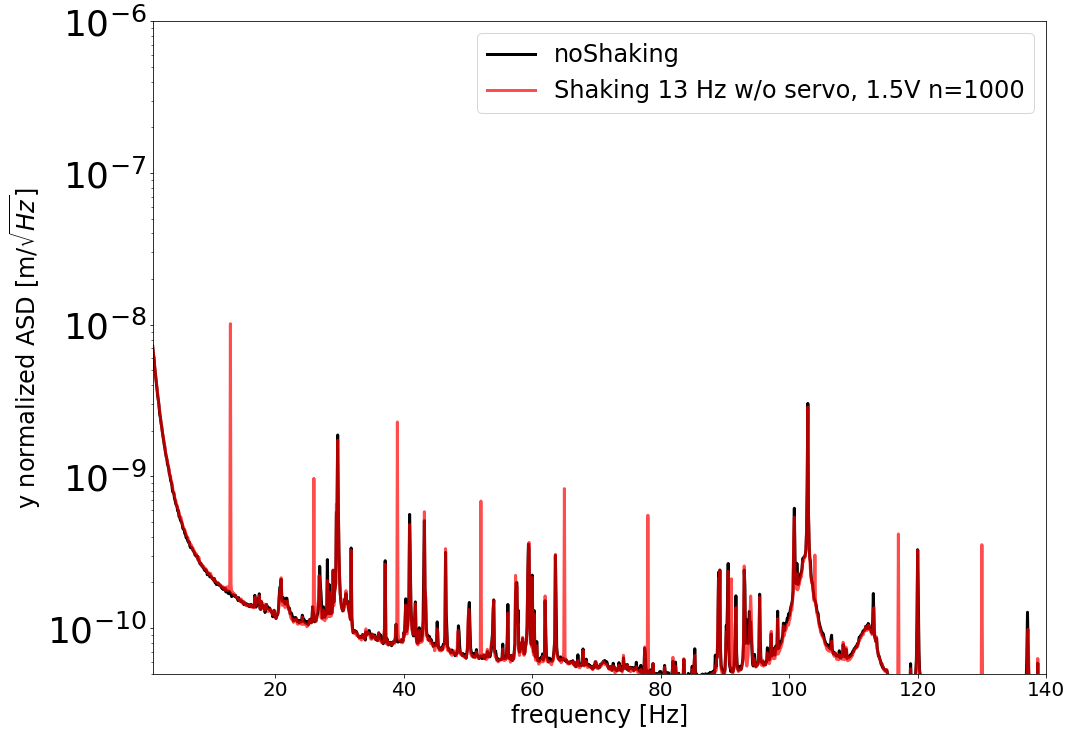

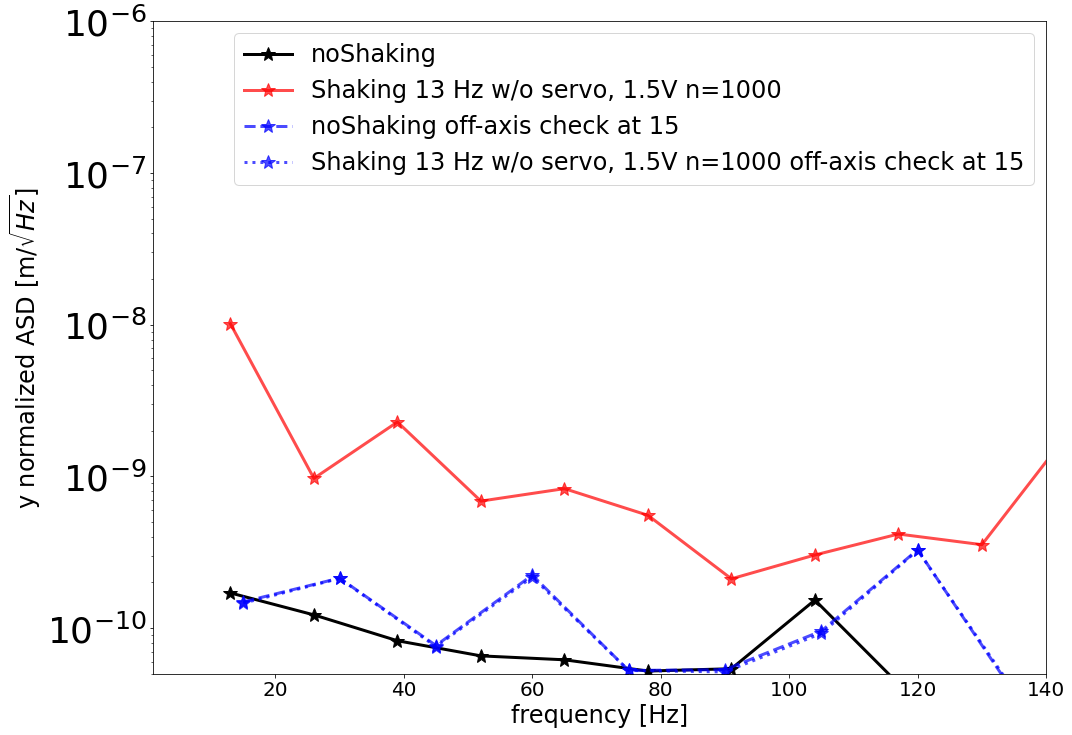

In [14]:
data1=df_NoShaking0_20220526
data2=df_Shaking13_20220526
plotQuickASD(13,df_1=data1,df_2=data2,axis="y",label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=5e-11,upylim=1e-6,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

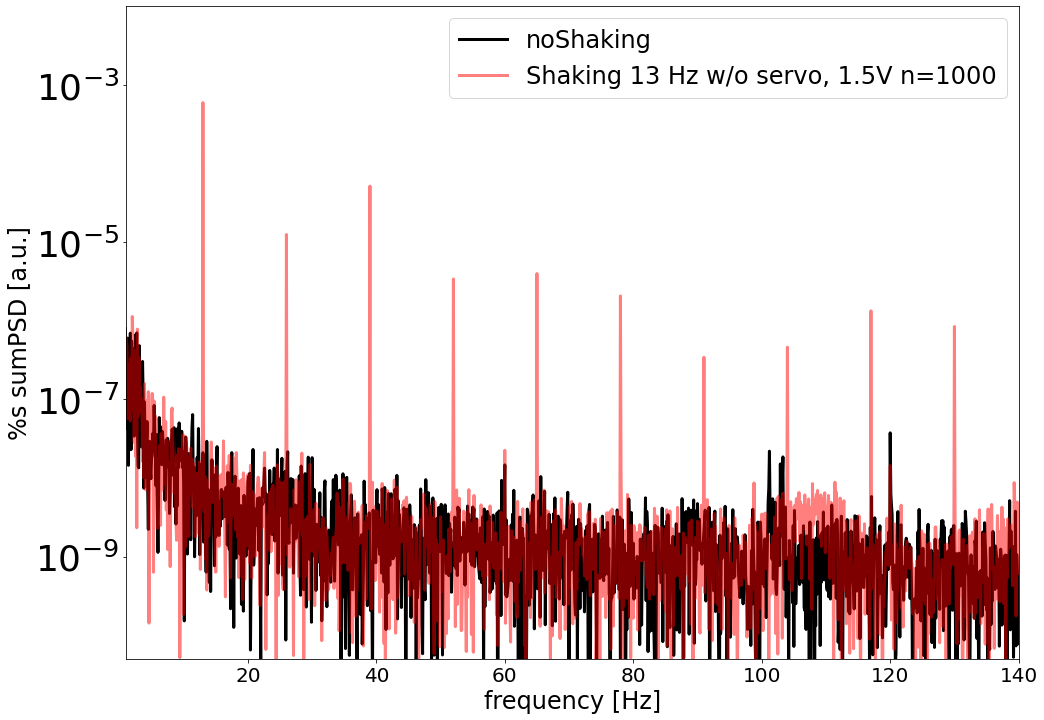

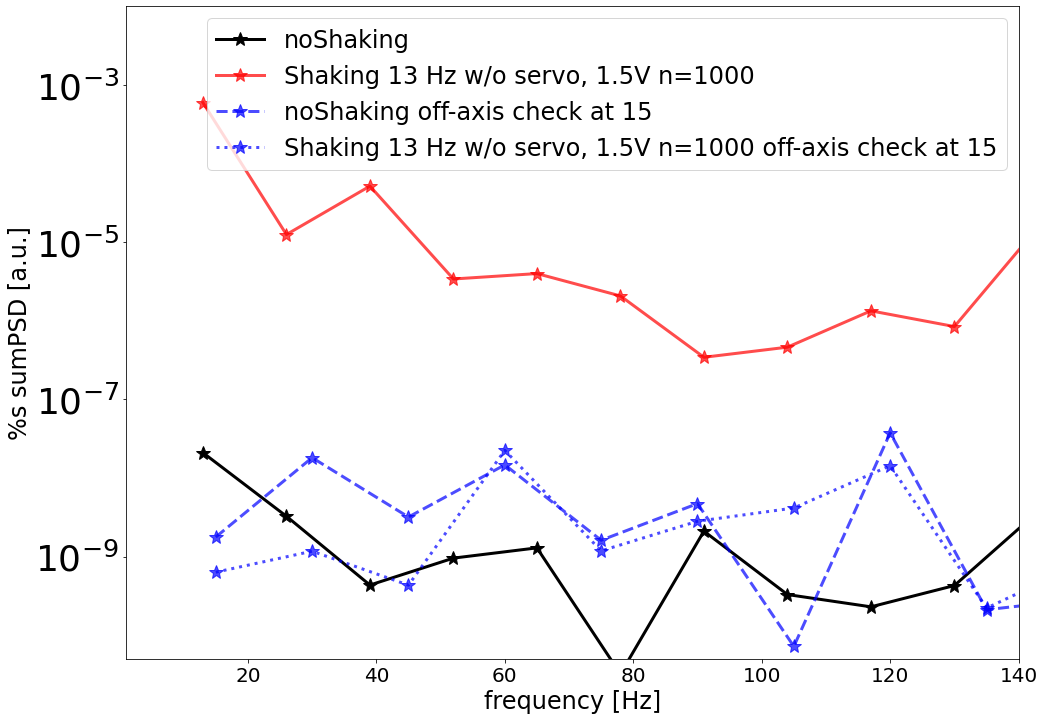

In [17]:
data1=df_NoShaking0_20220526
data2=df_Shaking13_20220526
plotQuickAlternatemethod(13,df_1=data1,df_2=data2,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.5V n=%d" %(len(data2)),offset=2,lowylim=5e-11,upylim=1e-2,lowxlim=1,upxlim=140,scaleFactor1=len(data1),scaleFactor2=len(data2))

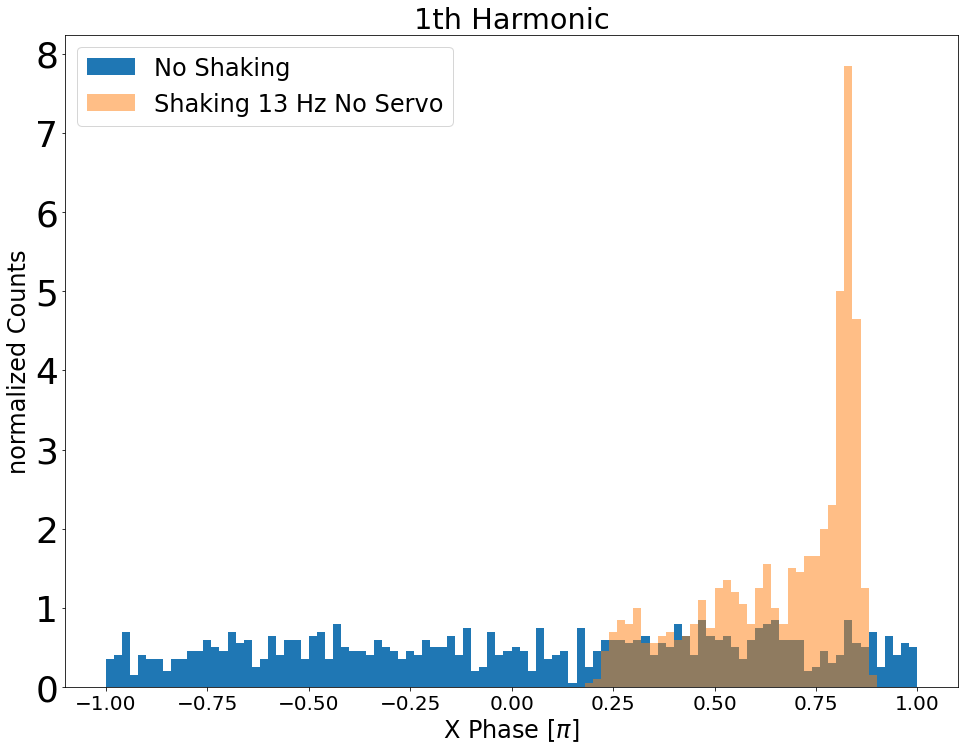

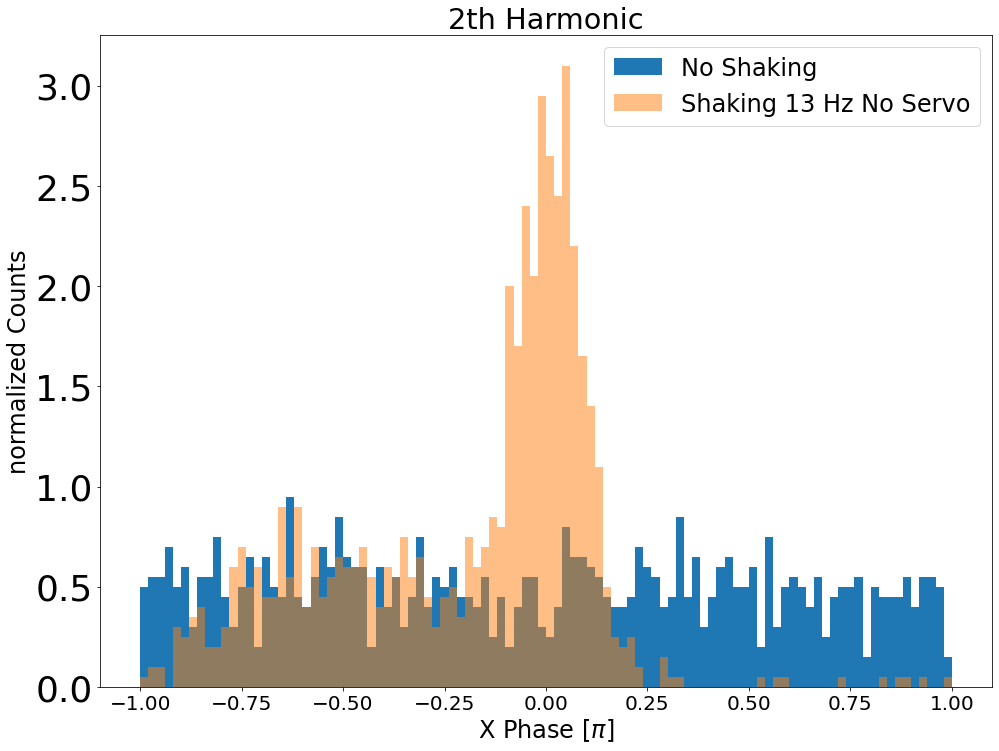

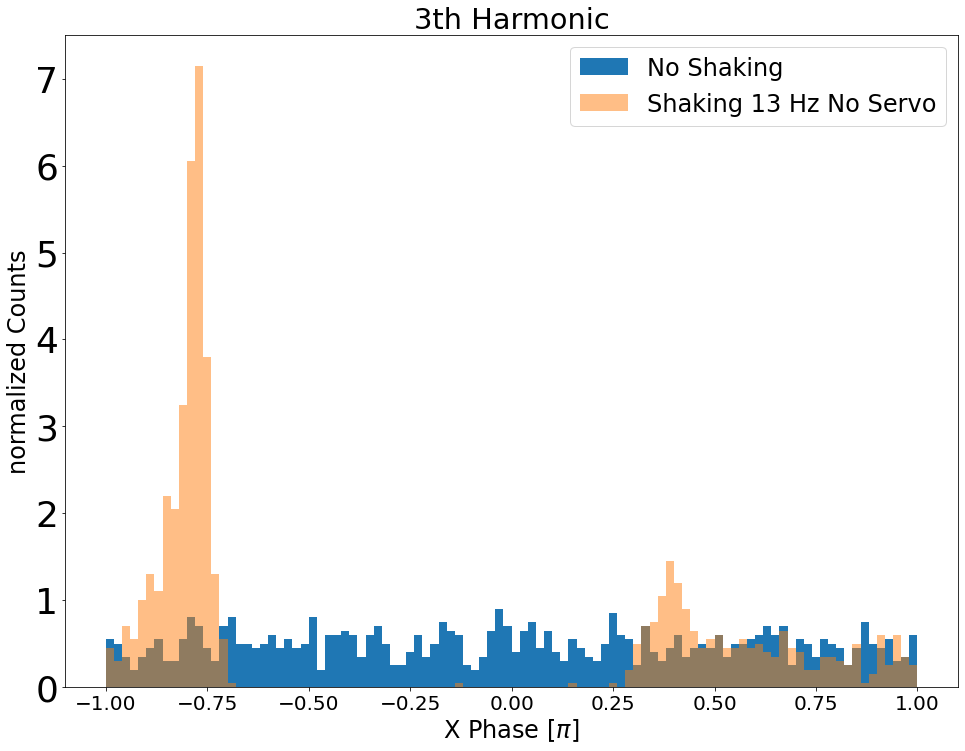

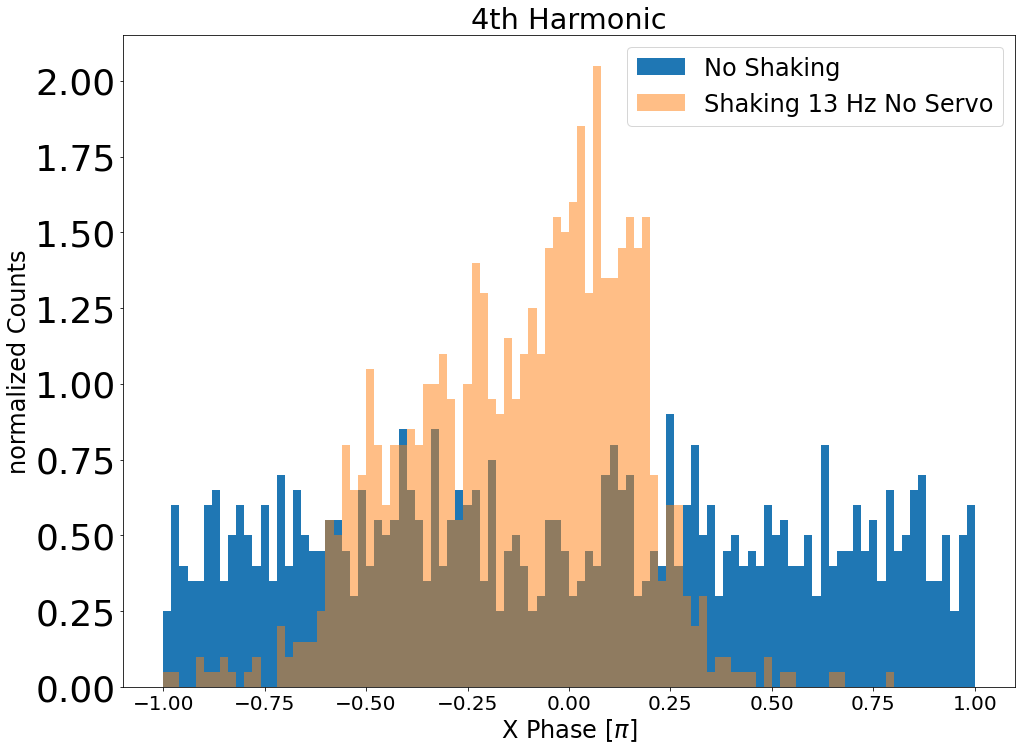

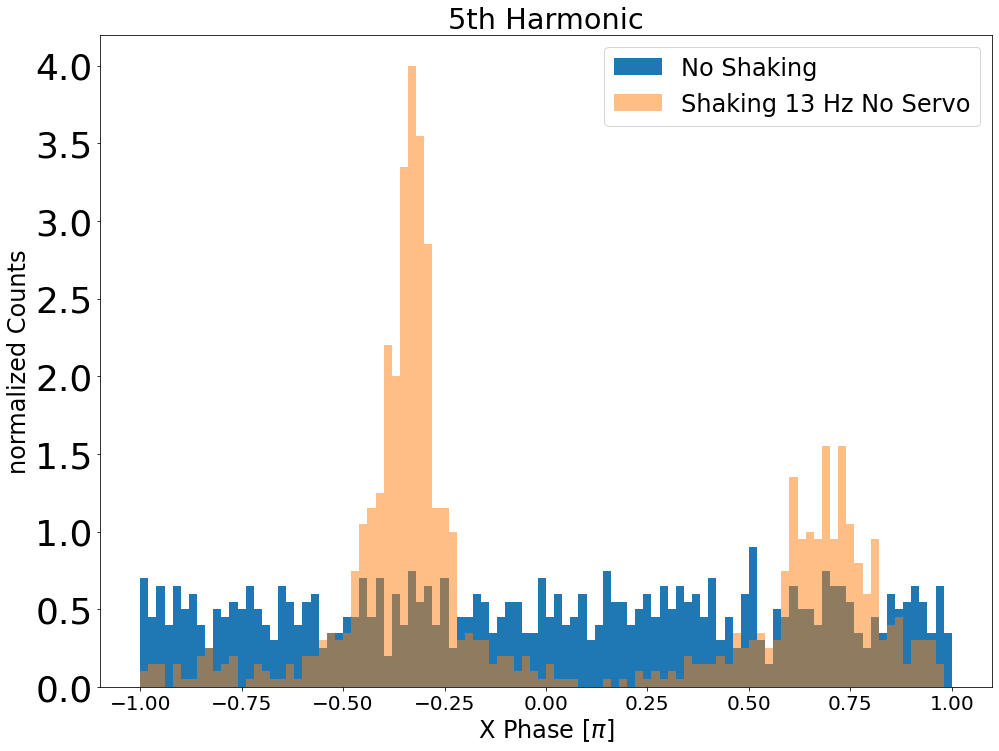

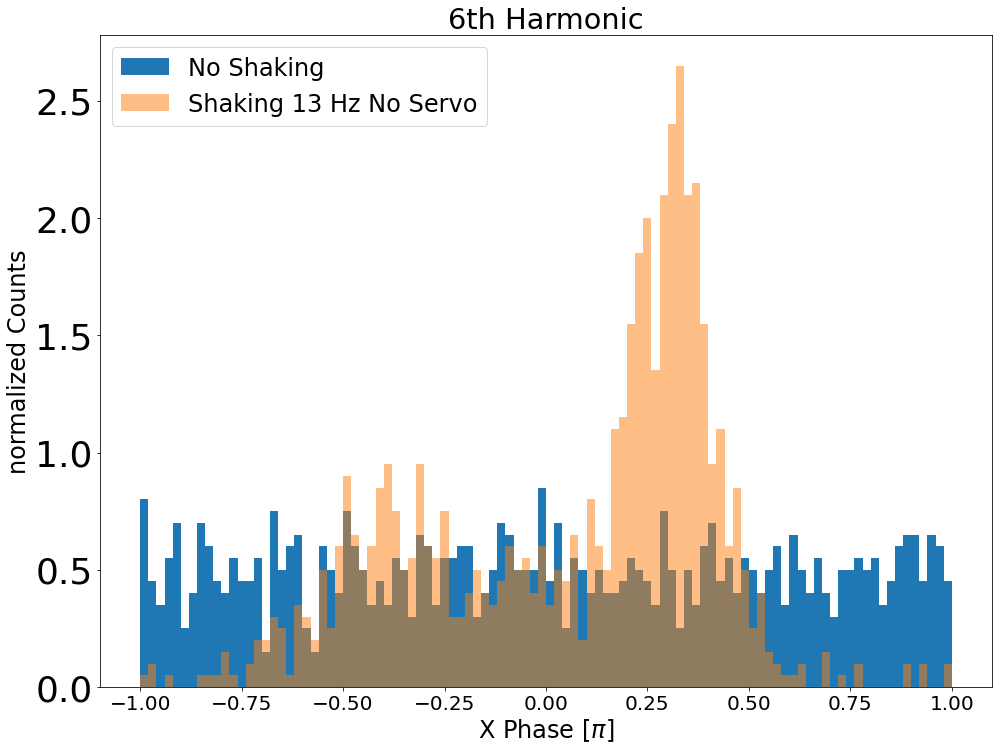

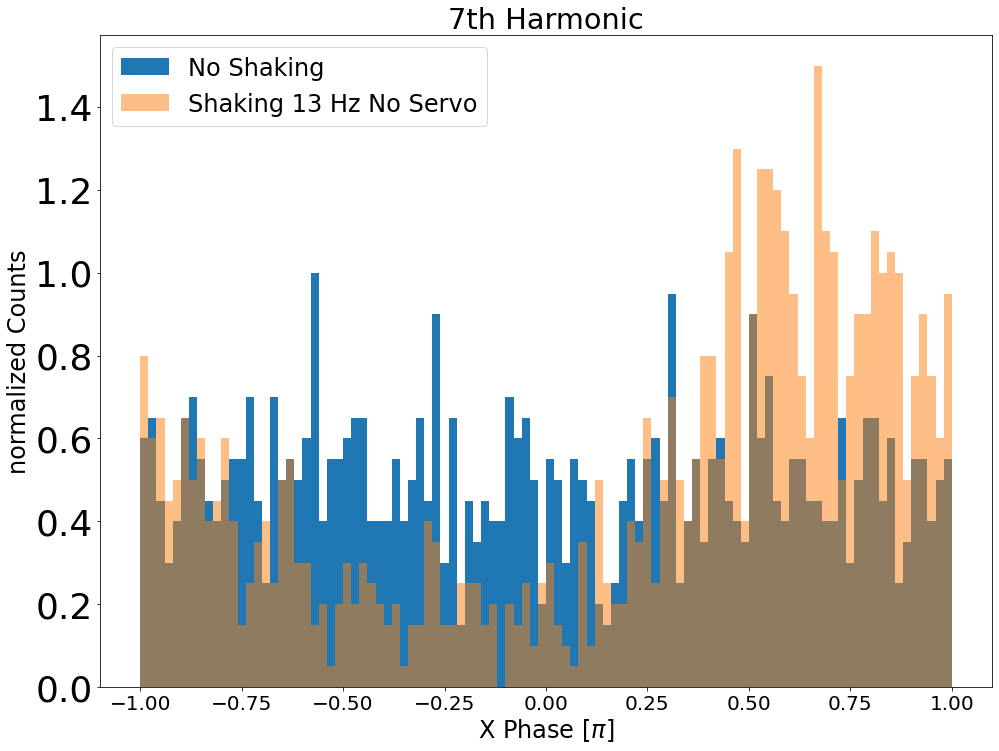

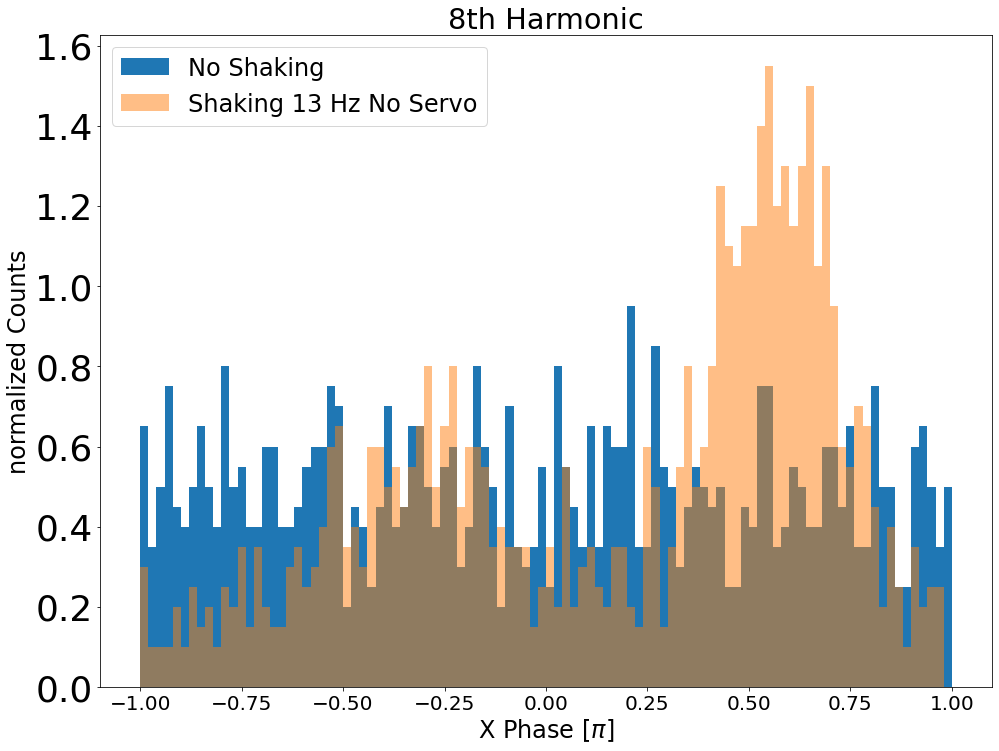

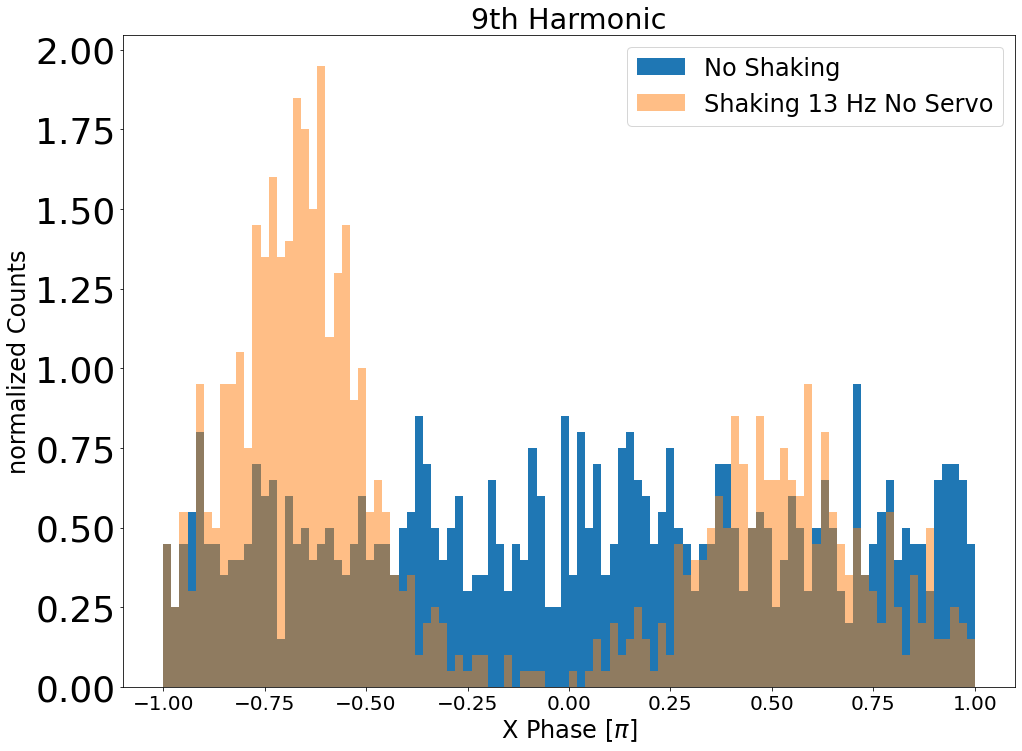

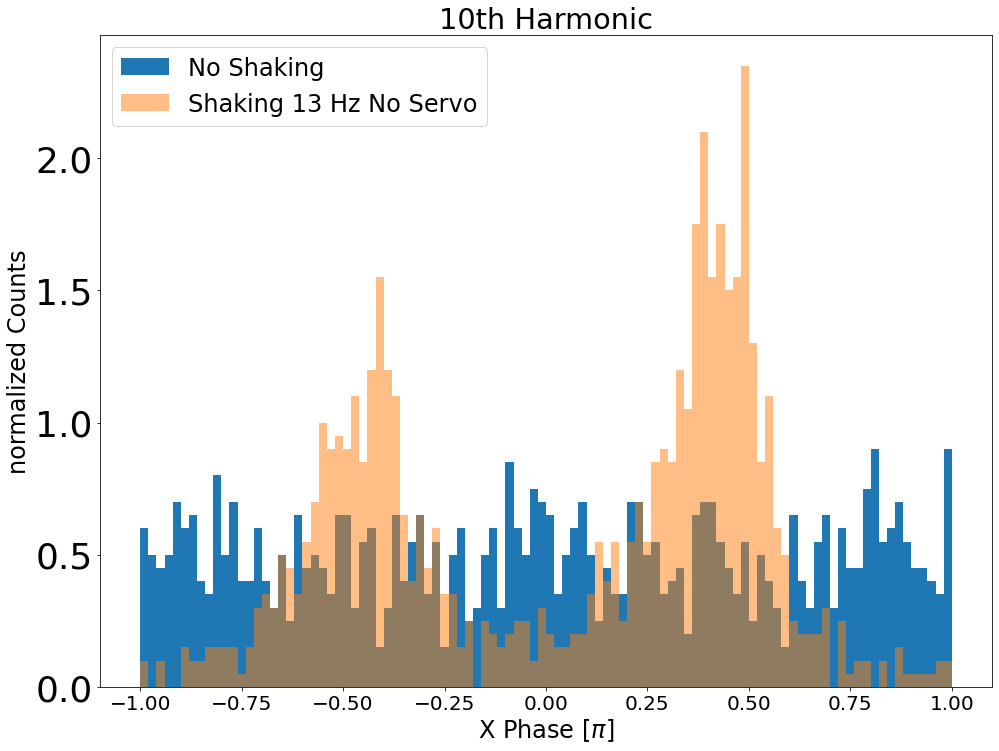

In [18]:
frequency=13
df0=df_NoShaking0_20220526
df1=df_Shaking13_20220526

for j in range(10):
    PhaseListX0 = []
    PhaseListX1 = []
    for i in range(len(df0)):
        PhaseListX0.append(df0["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListX1.append(df1["xPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("X Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListX0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListX1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    #plt.axvline(df_Shaking13["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()

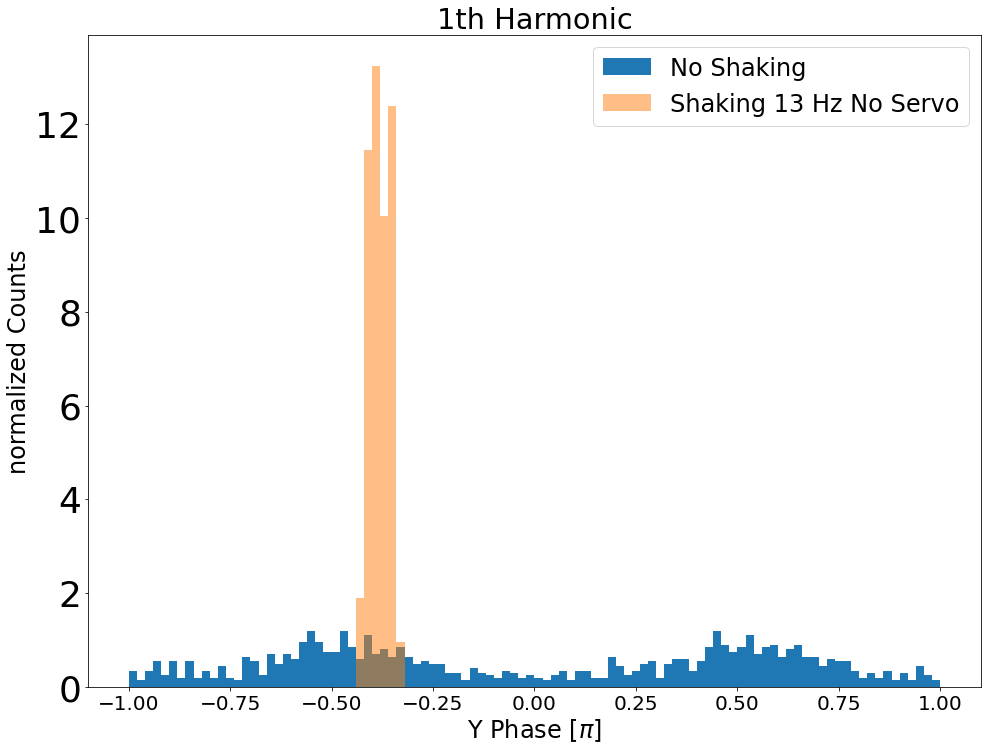

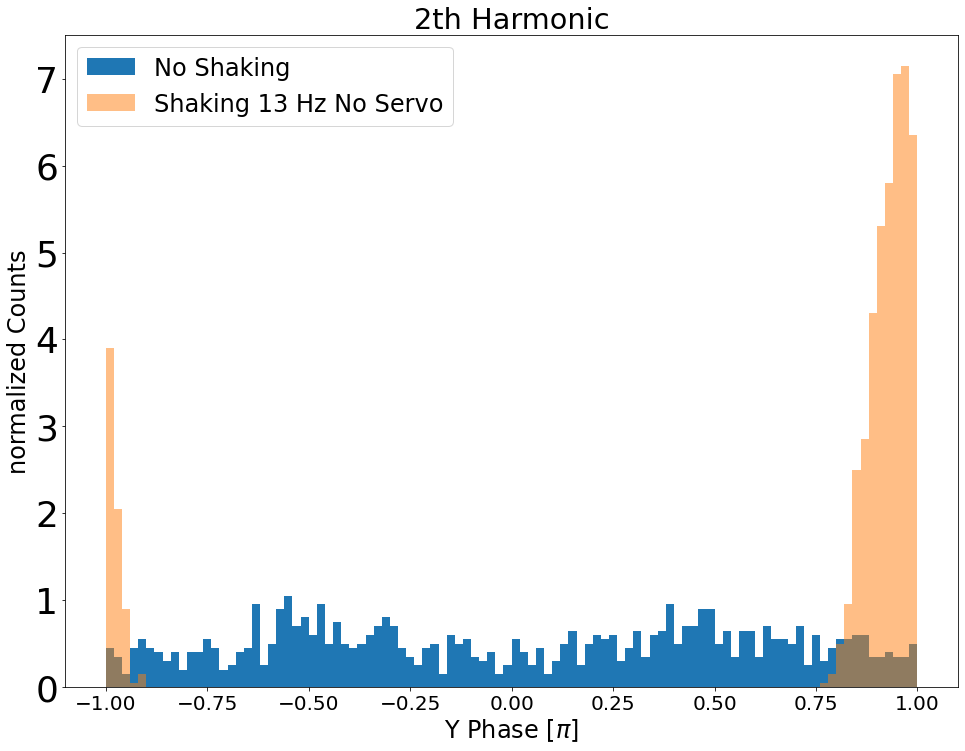

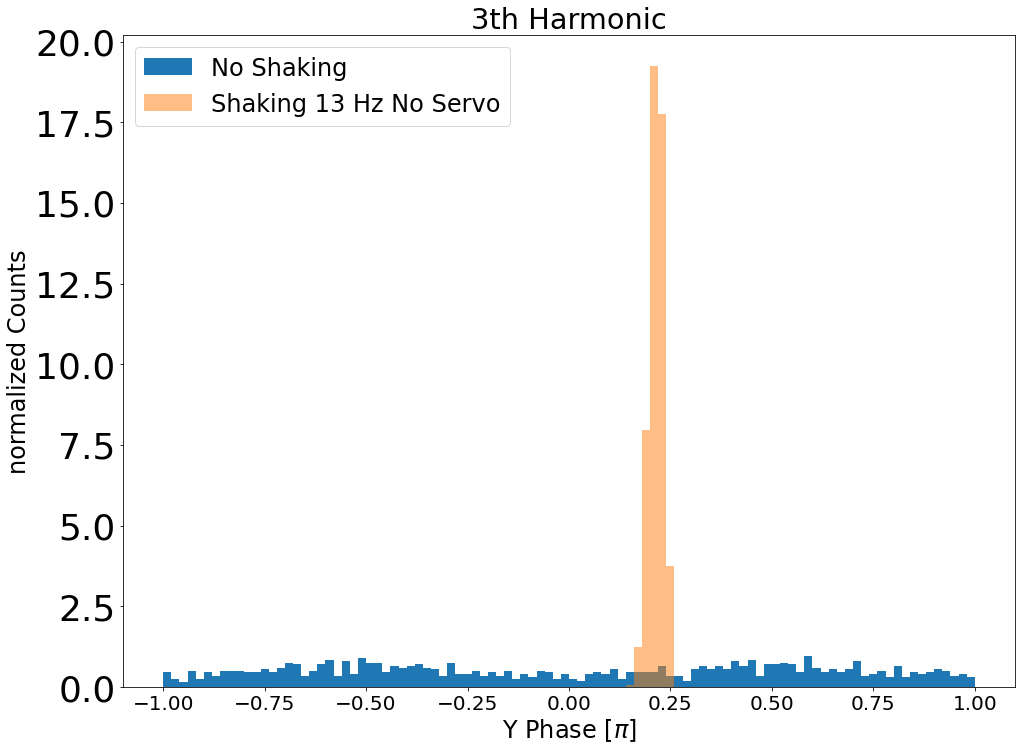

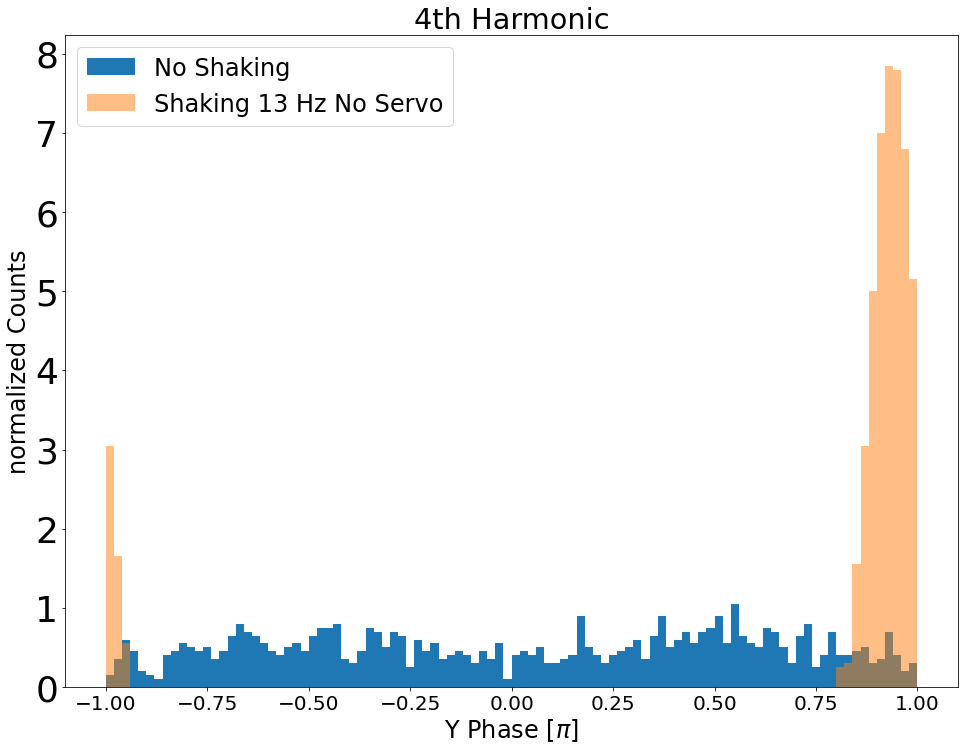

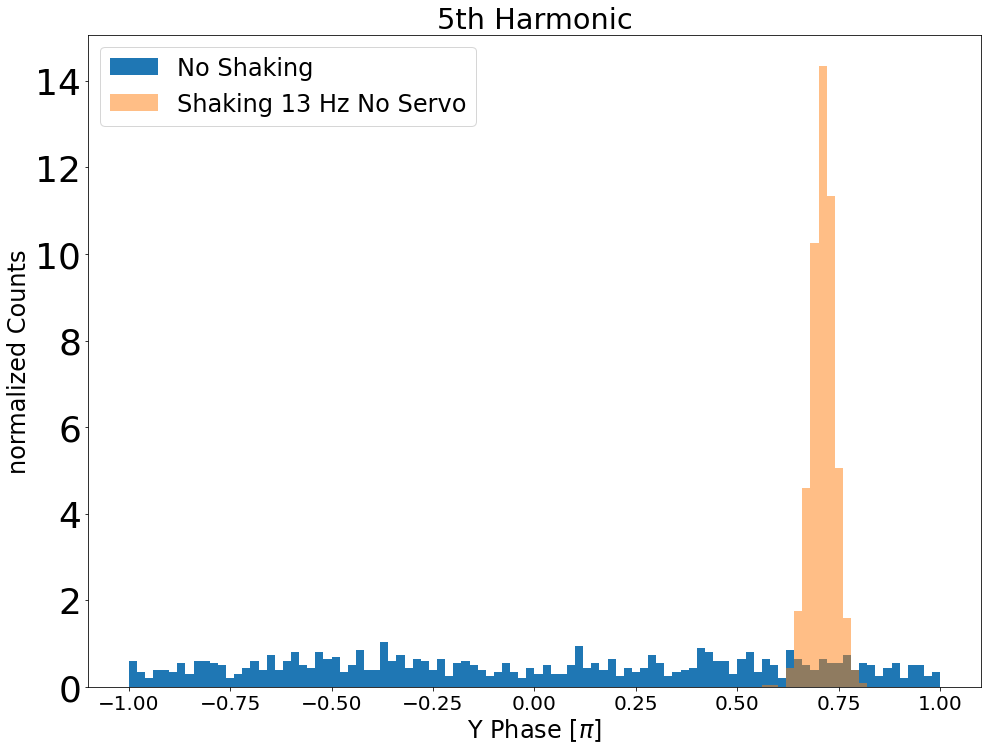

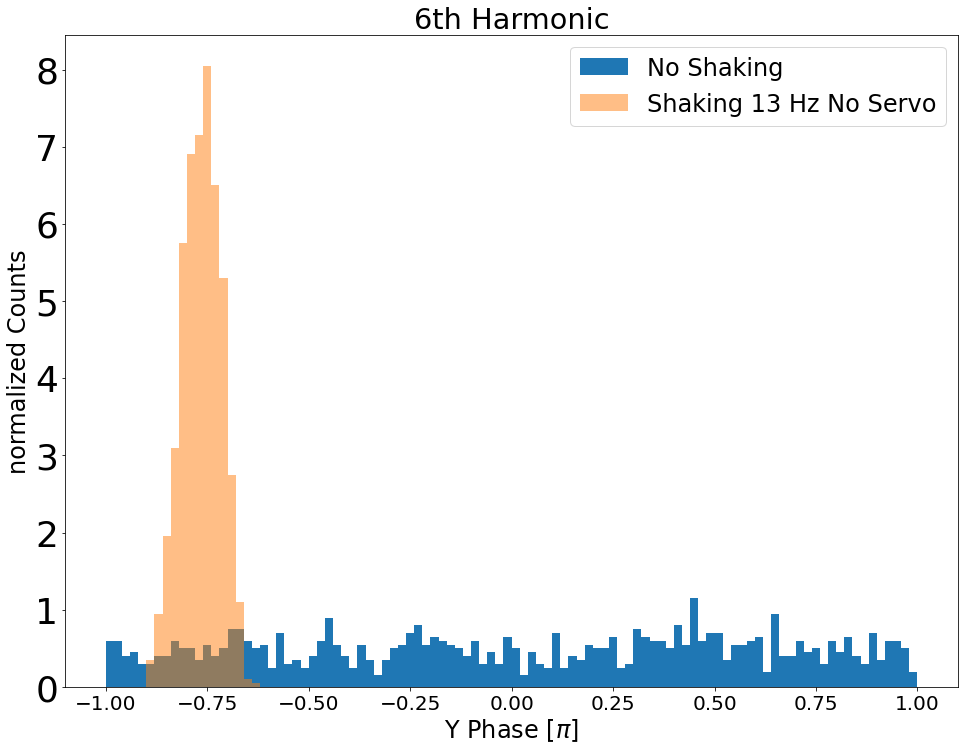

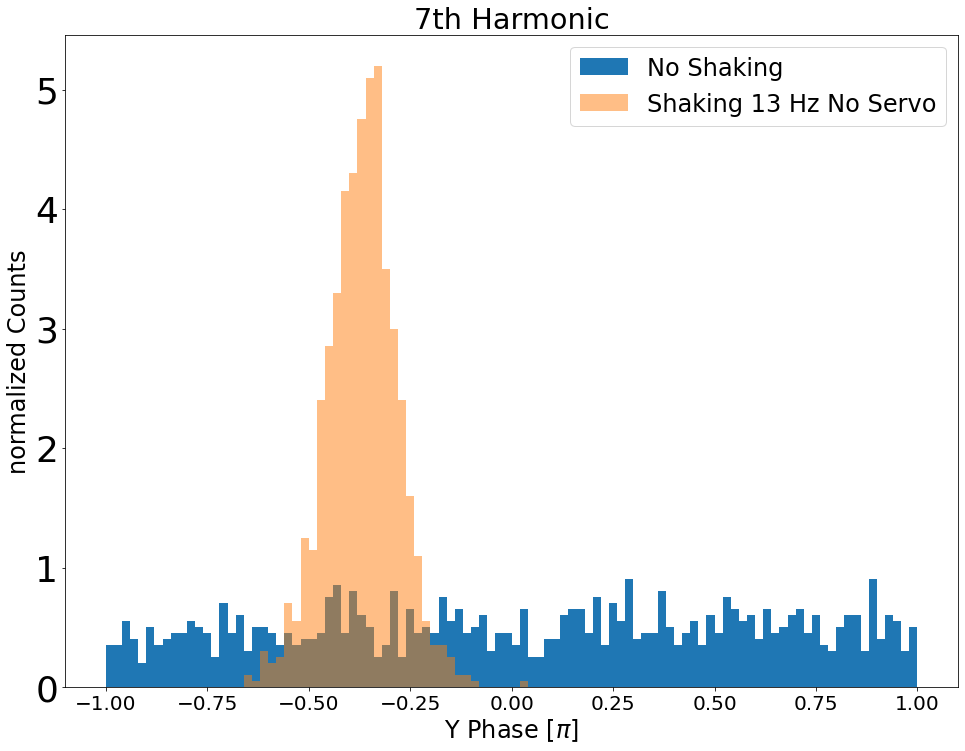

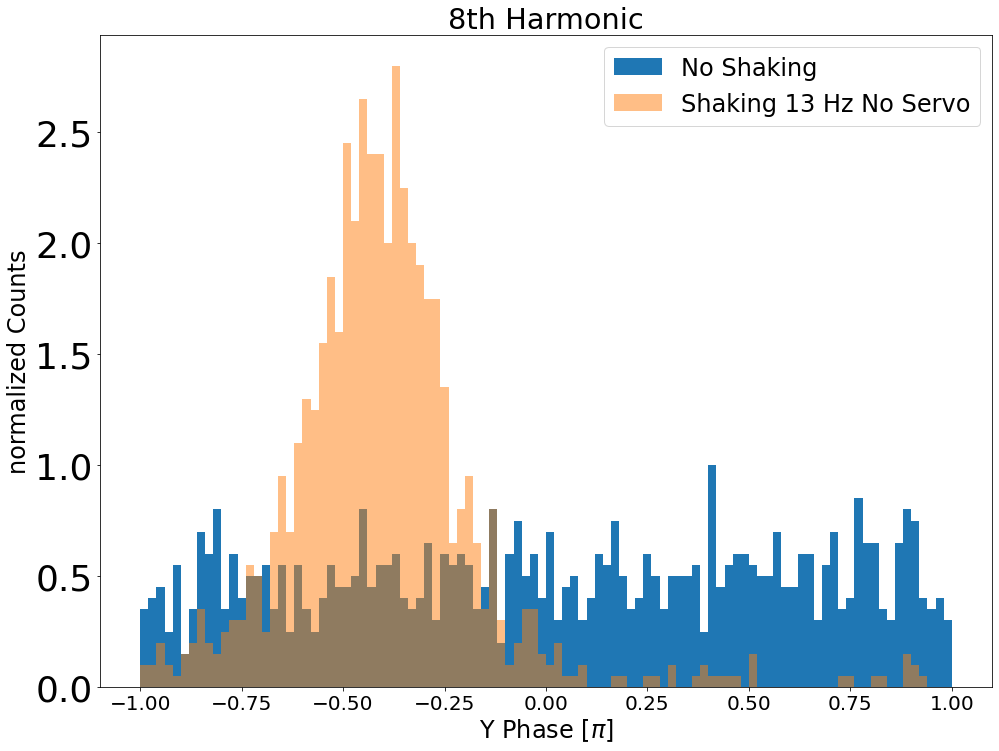

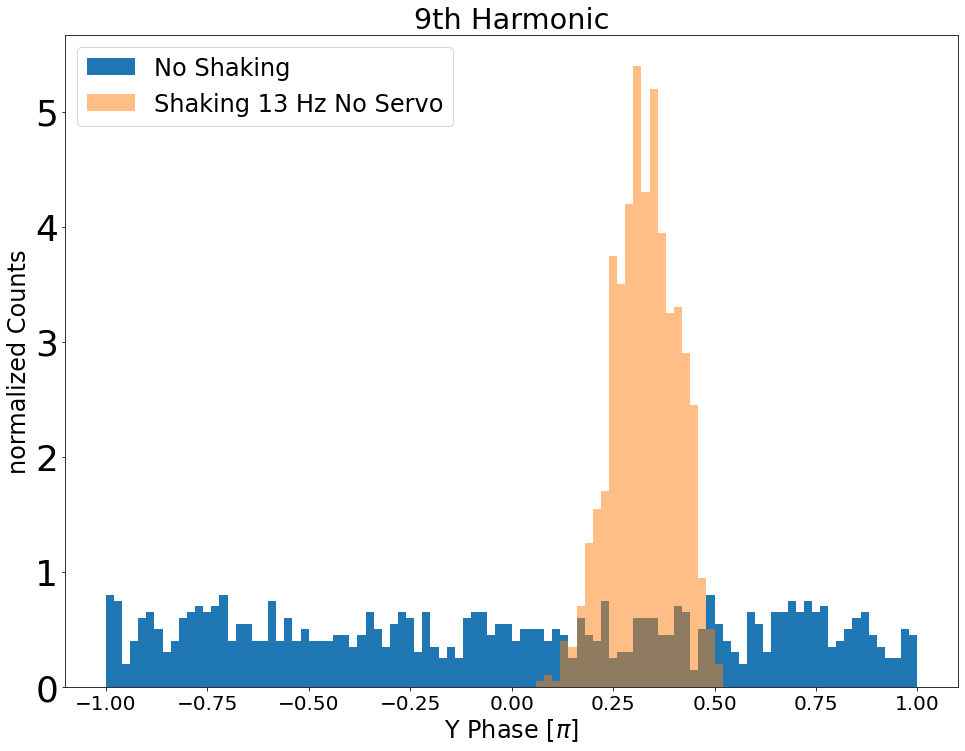

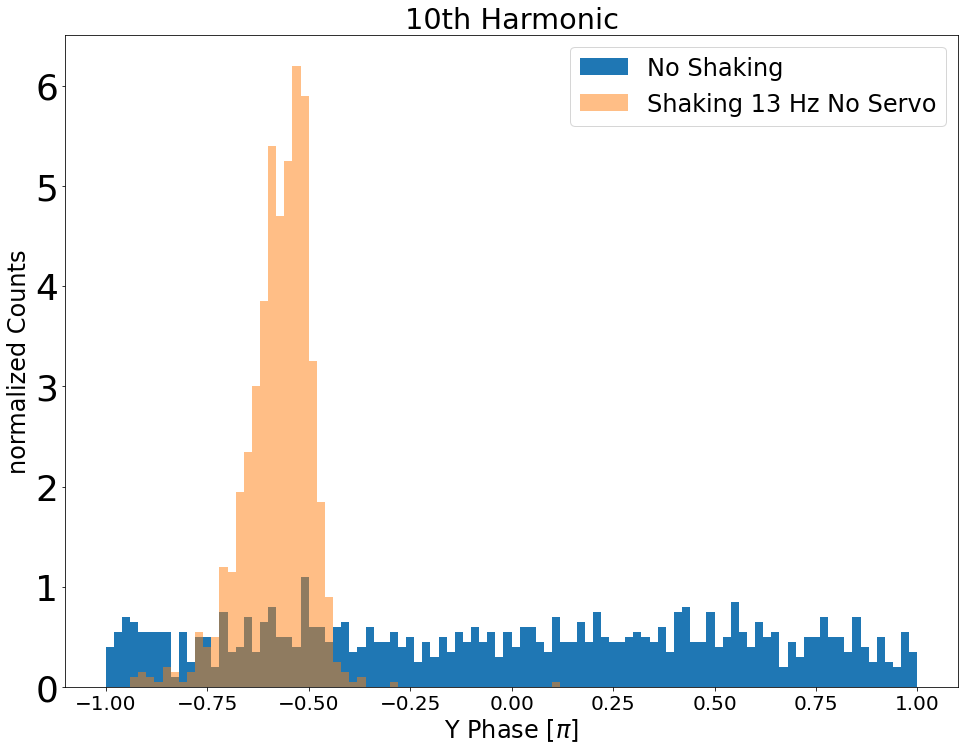

In [19]:
frequency=13
df0=df_NoShaking0_20220526
df1=df_Shaking13_20220526

for j in range(10):
    PhaseListY0 = []
    PhaseListY1 = []
    for i in range(len(df0)):
        PhaseListY0.append(df0["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    for i in range(len(df1)):
        PhaseListY1.append(df1["yPhase"][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
    plt.title("%sth Harmonic" %(j+1))    
    plt.xlabel("Y Phase [$\pi$]")
    plt.ylabel("normalized Counts")
    plt.hist(PhaseListY0,bins=100,range=(-1,1),label="No Shaking",density=True)
    plt.hist(PhaseListY1,bins=100,range=(-1,1),label="Shaking %s Hz No Servo" %frequency,alpha=0.5,density=True)
    #plt.axvline(df_Shaking13["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
    plt.legend()
    plt.show()